In [1]:
from os import listdir
from os.path import isfile, join
import justext
import ftfy
import re
import sys
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
import torch
from torch import nn , optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split , KFold

---

## Preparing the needed functions:

#### Grapping text from the text files and building the corpus:

In [2]:
def import_bbc_folder(category , corpus , lemmatize = False):
    '''
    Given a category name and a corpus class instance, the text files are read and sentences are extracted and then passed to
    the corpus for preprocessing, tokenization and saving vocabulary.
    '''
    folder = "bbc/" + category
    textfiles = [join(folder, f) for f in listdir(folder) if isfile(join(folder, f)) and f.endswith(".txt")]
    for tf in textfiles:
        with open(tf, encoding='utf-8') as f:
            try:
                lines = f.readlines()
            except:
                print(tf , ' had a problem')
            for line in lines:
                sentences = line.split('.') # saperating sentences by fullstops
                corpus.add_to_corpus(sentences, lemmatize)

#### The corpus class and helper functions:

In [3]:
# To convert nltk's pos tags to wordnet pos tags
def get_wordnet_pos(nltk_pos):
    if nltk_pos.startswith('J'):
        return wordnet.ADJ
    elif nltk_pos.startswith('V'):
        return wordnet.VERB
    elif nltk_pos.startswith('N'):
        return wordnet.NOUN
    elif nltk_pos.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

#-----------------------------------

def preprocess(text):
    numbers = re.compile(r'[\w|\.\_,-]*\d+[\w|-]*')
    cleaned_text = numbers.sub("", text) # removing numbers
    fixed_text = ftfy.fix_text(cleaned_text) # fixing the text
    return fixed_text
    
def tokenise(text):
    tokenise_re = re.compile(r"[-\w]+|\'[a-z]*") # capturing words and any apostrophes followed be letters
    tokens = tokenise_re.findall(text)
    return tokens

#-----------------------------------
    
class Corpus:
    def __init__(self, meta={}):
        self.meta = meta
        self.verbs_fql = Counter()
        self.vocabs_fql = Counter()
        self.rare_verbs = []
        self.verbs_to_learn = []
        self.rare_vocabs = []
        self.vocabs_to_learn = []
        self._lemmatizer = WordNetLemmatizer()
        
        
    def add_to_corpus(self, sentences , lemmatize):
        '''
        Given a set of sentences, each sentence is preprocessed, tokenized then POS tagged.
        Each word in the sentence is then checked:
            The word is added to the input vocabulary "vocabs" if the word is not a stop word..
            The word is added to the output vocabulary "verbs" if the POS tag of that word starts with "V"
        When lemmatize = True; the words are stemmed before being added to the corpus.
        '''
        for sent in sentences:
            p_sent = preprocess(sent)
            tokens = tokenise(p_sent)
            pos_tagged = nltk.pos_tag(tokens)
            
            for ps in pos_tagged:
                
                if lemmatize:
                    lemmatized_token = self._lemmatizer.lemmatize(ps[0], pos = get_wordnet_pos(ps[1]))
                    word = lemmatized_token.lower()
                else:
                    word = ps[0].lower()
                    
                if word not in stopwords.words('english'):
                    self.vocabs_fql.update([word])
                    if (ps[1].startswith('V')) and (not ps[0].startswith('\'')): # The POS tagger sometimes defines 's as a verb
                        self.verbs_fql.update([word])
                    
    def get_verbs_to_learn(self):
        '''
        Returns a list of distinct verbs that occured in the data at least 3 times
        '''
        if len(self.verbs_to_learn) == 0: # if the list wasn't made yet 
            for verb in self.verbs_fql.items():
                if verb[1] < 3:
                    self.rare_verbs.append(verb[0]) # if it occured less than 3 times, add it to the rare_verbs list
                else:
                    self.verbs_to_learn.append(verb[0])
        return self.verbs_to_learn
    
    def get_vocabs_to_learn(self):
        '''
        Returns a list of distinct vocabulary words that occured in the data at least 3 times
        '''
        if len(self.vocabs_to_learn) == 0:
            for vocab in self.vocabs_fql.items():
                if vocab[1] < 3:
                    self.rare_vocabs.append(vocab[0]) # if it occured less than 3 times, add it to the rare_verbs list
                else:
                    self.vocabs_to_learn.append(vocab[0])
        return self.vocabs_to_learn
                
    def get_vocabs_list(self):
        '''
        Returns a list of all the vocabulary captured from the text
        '''
        return list(self.vocabs_fql.keys())
    
    def get_vocab_index(self , word):
        '''
        Given a word (or a list of words), it returns the index of that word from the vocabulary corpus
        '''
        if type(word) == list:
            indexes = []
            for w in word:
                indexes.append(self.get_vocab_index(w))
            return indexes
        return self.get_vocabs_to_learn().index(word)
    
    def get_vocab_from_index(self, index):
        '''
        Given an index (or a list of indexes), it returns the word that correspond to that index from the vocabulary corpus
        '''
        if type(index) == list:
            words = []
            for i in index:
                words.append(self.get_vocab_from_index(i))
            return words
        return self.get_vocabs_to_learn()[index]
    
    def get_verbs_list(self):
        '''
        Returns a list of all the verbs captured from the text
        '''
        return list(self.verbs_fql.keys())
    
    def get_verb_index(self , word):
        '''
        Given a word (or a list of words), it returns the index of that word from the verbs corpus
        '''
        if type(word) == list:
            indexes = []
            for w in word:
                indexes.append(self.get_verb_index(w))
            return indexes
        return self.get_verbs_to_learn().index(word)
    
    def get_verb_from_index(self, index):
        '''
        Given an index (or a list of indexes), it returns the verb that correspond to that index from the verbs corpus
        '''
        if type(index) == list:
            words = []
            for i in index:
                words.append(self.get_verb_from_index(i))
            return words
        return self.get_verbs_to_learn()[index]

#### Preparing the sentences:

In [4]:
def build_sentences(category, corpus, window=3, lemmatize = False):
    '''
    Yields a list of words extracted from the sentences in the text file given the words in the vocabulary corpus.
    A sliding window is used to obtain the words by sliding it across each sentence to capture the words within that window and return them.
    '''
    lemmatizer = WordNetLemmatizer()
    folder = "bbc/" + category
    textfiles = [join(folder, f) for f in listdir(folder) if isfile(join(folder, f)) and f.endswith(".txt")]
    
    for tf in textfiles:
        with open(tf, encoding='utf-8') as f:
            try:
                lines = f.readlines()
            except:
                print(tf , ' had a problem')
                continue
                
            for line in lines:
                sentences = line.split('.')
                for sent in sentences:
                    sentence_words = []
                    if len(sent.split()) > window: # only consider the sentece if it has length greater than the size of the window
                        
                        p_sent = preprocess(sent.lower())
                        tokens = tokenise(p_sent)
                        pos_tagged = nltk.pos_tag(tokens)
                        for ps in pos_tagged:
                            if lemmatize:
                                lemmatized_token = lemmatizer.lemmatize(ps[0], pos = get_wordnet_pos(ps[1]))
                                word = lemmatized_token.lower()
                            else:
                                word = ps[0].lower()
                                
                            if word in corpus.get_vocabs_to_learn(): # only add words that are known to our vocabulary corpus
                                sentence_words.append(word)
                                
                    else: continue
                                
                    length = len(sentence_words)
                    # The sliding window:
                    for i in range(length):
                        if int(np.around((i+1)*window - i*(window-1))) <= length :
                            yield sentence_words[i : int((i+1)*window - i*(window-1))]

#### Building the dataset of sentences and target verbs:

In [5]:
def Build_Dataset(category, corpus, window = 3 , one_hot = False , lemmatize = False):
    '''
    Constructs the dataset as X, y
    It uses the build_sentences function to get one [X,y] pair at a time.
    X can be either a one-hot encoded sentence or a list of word indexes.
    '''
    x = []
    y = []
    for cat in category:
        for sent_words in build_sentences(cat, corpus, window, lemmatize):
            # get the verbs in the obtained filtered sentense that exist in the verbs corpus
            verbs = list(set(sent_words).intersection(set(corpus.get_verbs_to_learn())))
            
            if len(verbs) > 0: # make sure that we at least have one verb in the sentence (the filtered sentence => context words)
                target = random.choice(verbs) # to ensure that we choose one verb randomly when multiple verbs are captured by the window
                y.append(corpus.get_verb_index(target))
                sent_words.remove(target) # remove it before adding the words to the input variable (the input context words)
                
                sent_indxs = corpus.get_vocab_index(sent_words)
                
                if not one_hot:
                    x.append(sent_indxs)
                else: # make the context encoded vector by adding the one-hot encodings of the words
                    x_ = np.zeros(len(corpus.get_vocabs_to_learn()))
                    for inx in sent_indxs:
                        x_[inx] += 1 
                    x.append(x_)
                    
    return np.array(x, dtype = np.float32) , np.array(y)

#### Grapping batches of data for the model:

In [6]:
def get_batch(x ,y ,batch_size):
    '''
    Given the data as x and y, it yields batches of the data of size = batch_size.
    x and y are returned as torch tensors
    '''
    for i in range(int(np.floor(len(x)/batch_size))):
            
        batch_x = x[i*batch_size:(i+1)*batch_size]
        batch_y = y[i*batch_size:(i+1)*batch_size]
        
        yield torch.tensor(batch_x) , torch.tensor(batch_y)

#### The CBOW model:

In [7]:
class CBOW(nn.Module):
    '''
    The continous-bag-of-words model, made of 2 fully connected layers with a dropout layer in between followed by a log-softmax activation function.
    '''
    def __init__(self, vocab_size, hidden_dim, verbs_size):
        super(CBOW, self).__init__()
        self.linear1 = nn.Linear(vocab_size, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, verbs_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, inputs):
        out = self.linear1(inputs)
        out = self.dropout(out)
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

#### The training function:

In [8]:
def Train_model(model, lr, batch_size, n_epochs, file_name, x_train, y_train, x_valid, y_valid):
    '''
    Given the model, this function sets up the loss criterion and the optimizer used to train the model, then trains and validates the model.
    In each epoch, the model is trained using the training set and evaluated using the validation set, the model parameters are saved whenever a lower validation loss is reached.
    '''

    criterion = nn.NLLLoss() # setting the loss function that allows the error to be packprobagated
    optimizer = optim.Adam(model.parameters(), lr=lr) # the model optimizer
    
    # to keep track of the losses
    valid_loss_min = np.Inf
    train_losses, valid_losses = [], []

    for epoch in range(1, n_epochs+1):

        train_loss = 0.0
        valid_loss = 0.0

        # training the model #
        model.train() # to keep track of the operations and save the gradients
        for sentences, words in get_batch(x_train , y_train , batch_size):
            sentences, words = sentences.cuda(), words.cuda() # move the data to GPU
            optimizer.zero_grad() # clear the gradients
            output = model(sentences.float()) # pass the data to the model and get the output
            loss = criterion(output, words.long()) # measure the loss
            loss.backward() # backpropagate the loss and calculate the gradients
            optimizer.step() # update the model parameters
            train_loss += loss.item()*batch_size # add the obtained training loss
        del sentences, words, output

        # validating the model #
        model.eval() # to prevent keeping track of the operation since the gradients are not needed
        for sentences, words in get_batch(x_valid , y_valid , batch_size):
            sentences, words = sentences.cuda(), words.cuda()  # move the data to GPU
            output = model(sentences.float()) # pass the data to the model and get the output
            loss = criterion(output, words.long()) # measure the loss
            valid_loss += loss.item()*batch_size # add the obtained validation loss
        del sentences, words, output

        # normalizing the losses and appending them to their respective lists
        train_loss = train_loss/len(x_train)
        valid_loss = valid_loss/len(x_valid)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
        
        # saving the model if a lower validation loss is obtained
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.5f} --> {:.5f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), file_name)
            valid_loss_min = valid_loss
            
    return train_losses, valid_losses

#### The testing function:

In [9]:
def Test_model(model, x_test, y_test, batch_size):
    '''
    Using the testing set to evaluate predictions of the model by measuring the fration of times the true varb appeared in the top 5 and top 10 probabilites.
    '''
    model.eval()
    it=0 # iteration counter
    predicted_intop5 = 0
    predicted_intop10 = 0

    for sentences, words in get_batch(x_test, y_test, batch_size):
        it+=1
        output = model(sentences.cuda().float())
        ps = torch.exp(output).cpu() # to cancel the natural log of the outputs and get the probabilities
        top_p, top_class = ps.topk(10, dim=1) # to obtain the top 10 probabilities and classes

        for word, preds in zip(words,top_class):
            # counting the number of times the target word appeared in the top 5 and top 10 predicted classes
            if word in preds:
                predicted_intop10 +=1
            if word in preds[:5]:
                predicted_intop5 +=1
                
    # getting the fraction of those measures out of the number of instances (batch_size*it)
    predicted_intop10_fraction = predicted_intop10/(batch_size*it)
    predicted_intop5_fraction = predicted_intop5/(batch_size*it)
    
    return predicted_intop5_fraction, predicted_intop10_fraction

#### The K-fold cross validtion function:

In [10]:
def K_fold_Cross_validate(K , x , y , corpus, lr, batch_size, n_epochs , file_name, random_state):
    '''
    Performing K-fold cross validation given the dataset as X and y.
    '''
    
    training_losses, validation_losses, predicted_intop5, predicted_intop10 = [] , [] , [] , []
    
    kf = KFold(n_splits=K, random_state=random_state, shuffle=True) # the K-fold splitter
    
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Splitting the training set to train and valid sets
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=123)
        
        # Setting up the model
        vocab_size = len(corpus.get_vocabs_to_learn())
        verbs_size = len(corpus.get_verbs_to_learn())
        hidden_dim = 500

        model = CBOW(vocab_size, hidden_dim, verbs_size)
        model.cuda()
        
        # Train the model
        train_loss, valid_loss = Train_model(model, lr, batch_size, n_epochs, file_name, x_train, y_train, x_valid, y_valid)
        model.load_state_dict(torch.load(file_name)) # load the saved version of the model
        # Test the model
        predicted_intop5_fraction, predicted_intop10_fraction = Test_model(model, x_test, y_test, batch_size)
        
        # Append the recorded measures to their respective lists
        training_losses.append(train_loss)
        validation_losses.append(valid_loss)
        predicted_intop5.append(predicted_intop5_fraction)
        predicted_intop10.append(predicted_intop10_fraction)
        
    return training_losses, validation_losses, predicted_intop5, predicted_intop10

---

## Now Predicting :

### 1- Obtaining prediction results when learning the verbs in business articles:

In [13]:
category = 'business'

In [58]:
# Preparing the results dataframes:
windows = list(range(3,11))
columns = ['Predicted_top5_mean', 'Predicted_top5_std', 'Predicted_top10_mean', 'Predicted_top10_std']
Results_Nolemmatize = pd.DataFrame(index=index, columns=columns)
Results_lemmatize = pd.DataFrame(index=index, columns=columns)

# Getting some results:
for lemmatize in [False , True]:
    
    # Building the corpus
    corpus = Corpus(meta = 'Corpus BBC '+category+' News, only verbs as target, no stopwords.')
    import_bbc_folder(category,corpus , lemmatize = lemmatize)
    
    for window in windows:
                
        # Building the dataset:
        sentences , verbs = Build_Dataset([category], corpus, window, one_hot=True , lemmatize=lemmatize)
        
        print('\n Starting:...-> Lemmatize =',lemmatize,', window =', window , '\n')
        
        lr=0.001
        batch_size = 512
        n_epochs = 20
        file_name = 'CBOW_BBC_'+category+'_lemmatize='+str(lemmatize)+'_window='+str(window)+'_crossval.pt'
        random_state = 123
        K = 10
        
        # Cross validating the model:
        training_losses, validation_losses, predicted_intop5, predicted_intop10 = K_fold_Cross_validate(K , sentences , verbs,
                                                                                                corpus, lr,batch_size ,n_epochs,
                                                                                                file_name, random_state)
        
        # Getting the prediction measures mean and standard deviation:
        predicted_intop5_mean , predicted_intop5_std  = np.mean(predicted_intop5) , np.std(predicted_intop5)
        predicted_intop10_mean , predicted_intop10_std  = np.mean(predicted_intop10) , np.std(predicted_intop10)
        
        # Adding the measures to the corresponding dataframe:
        if lemmatize:
            Results_lemmatize.loc[window , 'Predicted_top5_mean'] = predicted_intop5_mean
            Results_lemmatize.loc[window , 'Predicted_top5_std'] = predicted_intop5_std
            Results_lemmatize.loc[window , 'Predicted_top10_mean'] = predicted_intop10_mean
            Results_lemmatize.loc[window , 'Predicted_top10_std'] = predicted_intop10_std
        else:
            Results_Nolemmatize.loc[window , 'Predicted_top5_mean'] = predicted_intop5_mean
            Results_Nolemmatize.loc[window , 'Predicted_top5_std'] = predicted_intop5_std
            Results_Nolemmatize.loc[window , 'Predicted_top10_mean'] = predicted_intop10_mean
            Results_Nolemmatize.loc[window , 'Predicted_top10_std'] = predicted_intop10_std
        


 Starting:...-> Lemmatize = False , window = 3 

Epoch: 1 	Training Loss: 6.658982 	Validation Loss: 5.639777
Validation loss decreased (inf --> 5.63978).  Saving model ...
Epoch: 2 	Training Loss: 6.157184 	Validation Loss: 5.550756
Validation loss decreased (5.63978 --> 5.55076).  Saving model ...
Epoch: 3 	Training Loss: 5.965014 	Validation Loss: 5.427280
Validation loss decreased (5.55076 --> 5.42728).  Saving model ...
Epoch: 4 	Training Loss: 5.676569 	Validation Loss: 5.250045
Validation loss decreased (5.42728 --> 5.25004).  Saving model ...
Epoch: 5 	Training Loss: 5.275452 	Validation Loss: 5.048991
Validation loss decreased (5.25004 --> 5.04899).  Saving model ...
Epoch: 6 	Training Loss: 4.793271 	Validation Loss: 4.853325
Validation loss decreased (5.04899 --> 4.85333).  Saving model ...
Epoch: 7 	Training Loss: 4.282009 	Validation Loss: 4.680234
Validation loss decreased (4.85333 --> 4.68023).  Saving model ...
Epoch: 8 	Training Loss: 3.784696 	Validation Loss: 4.5416

Epoch: 17 	Training Loss: 1.624016 	Validation Loss: 4.391511
Epoch: 18 	Training Loss: 1.550818 	Validation Loss: 4.422252
Epoch: 19 	Training Loss: 1.480884 	Validation Loss: 4.454697
Epoch: 20 	Training Loss: 1.425019 	Validation Loss: 4.489904
Epoch: 1 	Training Loss: 6.654436 	Validation Loss: 5.677383
Validation loss decreased (inf --> 5.67738).  Saving model ...
Epoch: 2 	Training Loss: 6.152224 	Validation Loss: 5.585193
Validation loss decreased (5.67738 --> 5.58519).  Saving model ...
Epoch: 3 	Training Loss: 5.963118 	Validation Loss: 5.468080
Validation loss decreased (5.58519 --> 5.46808).  Saving model ...
Epoch: 4 	Training Loss: 5.673894 	Validation Loss: 5.297629
Validation loss decreased (5.46808 --> 5.29763).  Saving model ...
Epoch: 5 	Training Loss: 5.273005 	Validation Loss: 5.099337
Validation loss decreased (5.29763 --> 5.09934).  Saving model ...
Epoch: 6 	Training Loss: 4.791683 	Validation Loss: 4.907388
Validation loss decreased (5.09934 --> 4.90739).  Savin

Epoch: 14 	Training Loss: 1.963426 	Validation Loss: 4.366529
Epoch: 15 	Training Loss: 1.824975 	Validation Loss: 4.379562
Epoch: 16 	Training Loss: 1.713211 	Validation Loss: 4.401786
Epoch: 17 	Training Loss: 1.618840 	Validation Loss: 4.429549
Epoch: 18 	Training Loss: 1.540535 	Validation Loss: 4.462355
Epoch: 19 	Training Loss: 1.473157 	Validation Loss: 4.496186
Epoch: 20 	Training Loss: 1.419667 	Validation Loss: 4.534260
Epoch: 1 	Training Loss: 6.660205 	Validation Loss: 5.631426
Validation loss decreased (inf --> 5.63143).  Saving model ...
Epoch: 2 	Training Loss: 6.163686 	Validation Loss: 5.537653
Validation loss decreased (5.63143 --> 5.53765).  Saving model ...
Epoch: 3 	Training Loss: 5.977683 	Validation Loss: 5.423298
Validation loss decreased (5.53765 --> 5.42330).  Saving model ...
Epoch: 4 	Training Loss: 5.693321 	Validation Loss: 5.253513
Validation loss decreased (5.42330 --> 5.25351).  Saving model ...
Epoch: 5 	Training Loss: 5.294067 	Validation Loss: 5.0558

Epoch: 12 	Training Loss: 1.387396 	Validation Loss: 3.843406
Validation loss decreased (3.90109 --> 3.84341).  Saving model ...
Epoch: 13 	Training Loss: 1.225025 	Validation Loss: 3.807399
Validation loss decreased (3.84341 --> 3.80740).  Saving model ...
Epoch: 14 	Training Loss: 1.094130 	Validation Loss: 3.786634
Validation loss decreased (3.80740 --> 3.78663).  Saving model ...
Epoch: 15 	Training Loss: 0.988730 	Validation Loss: 3.781497
Validation loss decreased (3.78663 --> 3.78150).  Saving model ...
Epoch: 16 	Training Loss: 0.899712 	Validation Loss: 3.784941
Epoch: 17 	Training Loss: 0.830186 	Validation Loss: 3.799548
Epoch: 18 	Training Loss: 0.772094 	Validation Loss: 3.816843
Epoch: 19 	Training Loss: 0.724545 	Validation Loss: 3.842470
Epoch: 20 	Training Loss: 0.678674 	Validation Loss: 3.867521
Epoch: 1 	Training Loss: 6.666127 	Validation Loss: 6.177465
Validation loss decreased (inf --> 6.17747).  Saving model ...
Epoch: 2 	Training Loss: 6.107864 	Validation Loss

Epoch: 7 	Training Loss: 3.218101 	Validation Loss: 4.440676
Validation loss decreased (4.71850 --> 4.44068).  Saving model ...
Epoch: 8 	Training Loss: 2.654220 	Validation Loss: 4.223110
Validation loss decreased (4.44068 --> 4.22311).  Saving model ...
Epoch: 9 	Training Loss: 2.207066 	Validation Loss: 4.060518
Validation loss decreased (4.22311 --> 4.06052).  Saving model ...
Epoch: 10 	Training Loss: 1.858553 	Validation Loss: 3.942239
Validation loss decreased (4.06052 --> 3.94224).  Saving model ...
Epoch: 11 	Training Loss: 1.593363 	Validation Loss: 3.856897
Validation loss decreased (3.94224 --> 3.85690).  Saving model ...
Epoch: 12 	Training Loss: 1.385514 	Validation Loss: 3.799411
Validation loss decreased (3.85690 --> 3.79941).  Saving model ...
Epoch: 13 	Training Loss: 1.220873 	Validation Loss: 3.762575
Validation loss decreased (3.79941 --> 3.76257).  Saving model ...
Epoch: 14 	Training Loss: 1.093543 	Validation Loss: 3.745122
Validation loss decreased (3.76257 -->

Epoch: 2 	Training Loss: 6.109538 	Validation Loss: 6.054535
Validation loss decreased (6.22927 --> 6.05453).  Saving model ...
Epoch: 3 	Training Loss: 5.775544 	Validation Loss: 5.785538
Validation loss decreased (6.05453 --> 5.78554).  Saving model ...
Epoch: 4 	Training Loss: 5.250339 	Validation Loss: 5.426163
Validation loss decreased (5.78554 --> 5.42616).  Saving model ...
Epoch: 5 	Training Loss: 4.579677 	Validation Loss: 5.055802
Validation loss decreased (5.42616 --> 5.05580).  Saving model ...
Epoch: 6 	Training Loss: 3.869065 	Validation Loss: 4.723974
Validation loss decreased (5.05580 --> 4.72397).  Saving model ...
Epoch: 7 	Training Loss: 3.211180 	Validation Loss: 4.447093
Validation loss decreased (4.72397 --> 4.44709).  Saving model ...
Epoch: 8 	Training Loss: 2.653194 	Validation Loss: 4.226247
Validation loss decreased (4.44709 --> 4.22625).  Saving model ...
Epoch: 9 	Training Loss: 2.207624 	Validation Loss: 4.057647
Validation loss decreased (4.22625 --> 4.05

Epoch: 13 	Training Loss: 0.784805 	Validation Loss: 2.810372
Validation loss decreased (2.85086 --> 2.81037).  Saving model ...
Epoch: 14 	Training Loss: 0.675468 	Validation Loss: 2.784881
Validation loss decreased (2.81037 --> 2.78488).  Saving model ...
Epoch: 15 	Training Loss: 0.592642 	Validation Loss: 2.775456
Validation loss decreased (2.78488 --> 2.77546).  Saving model ...
Epoch: 16 	Training Loss: 0.524873 	Validation Loss: 2.772684
Validation loss decreased (2.77546 --> 2.77268).  Saving model ...
Epoch: 17 	Training Loss: 0.468786 	Validation Loss: 2.776882
Epoch: 18 	Training Loss: 0.425155 	Validation Loss: 2.788518
Epoch: 19 	Training Loss: 0.388838 	Validation Loss: 2.803951
Epoch: 20 	Training Loss: 0.356666 	Validation Loss: 2.821713
Epoch: 1 	Training Loss: 6.556334 	Validation Loss: 5.673860
Validation loss decreased (inf --> 5.67386).  Saving model ...
Epoch: 2 	Training Loss: 5.950475 	Validation Loss: 5.451347
Validation loss decreased (5.67386 --> 5.45135).  S

Epoch: 6 	Training Loss: 3.226491 	Validation Loss: 3.856260
Validation loss decreased (4.21742 --> 3.85626).  Saving model ...
Epoch: 7 	Training Loss: 2.547093 	Validation Loss: 3.566576
Validation loss decreased (3.85626 --> 3.56658).  Saving model ...
Epoch: 8 	Training Loss: 2.013473 	Validation Loss: 3.342928
Validation loss decreased (3.56658 --> 3.34293).  Saving model ...
Epoch: 9 	Training Loss: 1.606528 	Validation Loss: 3.173832
Validation loss decreased (3.34293 --> 3.17383).  Saving model ...
Epoch: 10 	Training Loss: 1.309106 	Validation Loss: 3.047240
Validation loss decreased (3.17383 --> 3.04724).  Saving model ...
Epoch: 11 	Training Loss: 1.083978 	Validation Loss: 2.954001
Validation loss decreased (3.04724 --> 2.95400).  Saving model ...
Epoch: 12 	Training Loss: 0.910996 	Validation Loss: 2.887933
Validation loss decreased (2.95400 --> 2.88793).  Saving model ...
Epoch: 13 	Training Loss: 0.775294 	Validation Loss: 2.841985
Validation loss decreased (2.88793 --> 

Epoch: 17 	Training Loss: 0.458168 	Validation Loss: 2.803637
Epoch: 18 	Training Loss: 0.414285 	Validation Loss: 2.818436
Epoch: 19 	Training Loss: 0.378718 	Validation Loss: 2.833052
Epoch: 20 	Training Loss: 0.348162 	Validation Loss: 2.852832

 Starting:...-> Lemmatize = False , window = 6 

Epoch: 1 	Training Loss: 6.639942 	Validation Loss: 6.111496
Validation loss decreased (inf --> 6.11150).  Saving model ...
Epoch: 2 	Training Loss: 5.977563 	Validation Loss: 5.842026
Validation loss decreased (6.11150 --> 5.84203).  Saving model ...
Epoch: 3 	Training Loss: 5.446461 	Validation Loss: 5.412460
Validation loss decreased (5.84203 --> 5.41246).  Saving model ...
Epoch: 4 	Training Loss: 4.647106 	Validation Loss: 4.865343
Validation loss decreased (5.41246 --> 4.86534).  Saving model ...
Epoch: 5 	Training Loss: 3.724356 	Validation Loss: 4.331803
Validation loss decreased (4.86534 --> 4.33180).  Saving model ...
Epoch: 6 	Training Loss: 2.874869 	Validation Loss: 3.887812
Valid

Epoch: 9 	Training Loss: 1.312716 	Validation Loss: 3.058524
Validation loss decreased (3.25014 --> 3.05852).  Saving model ...
Epoch: 10 	Training Loss: 1.043076 	Validation Loss: 2.920171
Validation loss decreased (3.05852 --> 2.92017).  Saving model ...
Epoch: 11 	Training Loss: 0.841745 	Validation Loss: 2.822355
Validation loss decreased (2.92017 --> 2.82236).  Saving model ...
Epoch: 12 	Training Loss: 0.687180 	Validation Loss: 2.752936
Validation loss decreased (2.82236 --> 2.75294).  Saving model ...
Epoch: 13 	Training Loss: 0.571771 	Validation Loss: 2.700596
Validation loss decreased (2.75294 --> 2.70060).  Saving model ...
Epoch: 14 	Training Loss: 0.476711 	Validation Loss: 2.670771
Validation loss decreased (2.70060 --> 2.67077).  Saving model ...
Epoch: 15 	Training Loss: 0.408632 	Validation Loss: 2.657222
Validation loss decreased (2.67077 --> 2.65722).  Saving model ...
Epoch: 16 	Training Loss: 0.352063 	Validation Loss: 2.650416
Validation loss decreased (2.65722 -

Epoch: 2 	Training Loss: 5.981352 	Validation Loss: 5.847090
Validation loss decreased (6.13370 --> 5.84709).  Saving model ...
Epoch: 3 	Training Loss: 5.454782 	Validation Loss: 5.388968
Validation loss decreased (5.84709 --> 5.38897).  Saving model ...
Epoch: 4 	Training Loss: 4.652585 	Validation Loss: 4.814865
Validation loss decreased (5.38897 --> 4.81487).  Saving model ...
Epoch: 5 	Training Loss: 3.723622 	Validation Loss: 4.271150
Validation loss decreased (4.81487 --> 4.27115).  Saving model ...
Epoch: 6 	Training Loss: 2.871693 	Validation Loss: 3.821336
Validation loss decreased (4.27115 --> 3.82134).  Saving model ...
Epoch: 7 	Training Loss: 2.188113 	Validation Loss: 3.476978
Validation loss decreased (3.82134 --> 3.47698).  Saving model ...
Epoch: 8 	Training Loss: 1.684143 	Validation Loss: 3.218420
Validation loss decreased (3.47698 --> 3.21842).  Saving model ...
Epoch: 9 	Training Loss: 1.312606 	Validation Loss: 3.030834
Validation loss decreased (3.21842 --> 3.03

Epoch: 12 	Training Loss: 0.588547 	Validation Loss: 2.510524
Validation loss decreased (2.58045 --> 2.51052).  Saving model ...
Epoch: 13 	Training Loss: 0.475128 	Validation Loss: 2.461066
Validation loss decreased (2.51052 --> 2.46107).  Saving model ...
Epoch: 14 	Training Loss: 0.389048 	Validation Loss: 2.431495
Validation loss decreased (2.46107 --> 2.43150).  Saving model ...
Epoch: 15 	Training Loss: 0.323849 	Validation Loss: 2.412855
Validation loss decreased (2.43150 --> 2.41286).  Saving model ...
Epoch: 16 	Training Loss: 0.275495 	Validation Loss: 2.402404
Validation loss decreased (2.41286 --> 2.40240).  Saving model ...
Epoch: 17 	Training Loss: 0.236690 	Validation Loss: 2.398983
Validation loss decreased (2.40240 --> 2.39898).  Saving model ...
Epoch: 18 	Training Loss: 0.208020 	Validation Loss: 2.399777
Epoch: 19 	Training Loss: 0.186320 	Validation Loss: 2.405819
Epoch: 20 	Training Loss: 0.166518 	Validation Loss: 2.416728
Epoch: 1 	Training Loss: 6.570568 	Valid

Epoch: 3 	Training Loss: 5.338773 	Validation Loss: 5.207685
Validation loss decreased (5.65041 --> 5.20769).  Saving model ...
Epoch: 4 	Training Loss: 4.526411 	Validation Loss: 4.644579
Validation loss decreased (5.20769 --> 4.64458).  Saving model ...
Epoch: 5 	Training Loss: 3.580192 	Validation Loss: 4.097191
Validation loss decreased (4.64458 --> 4.09719).  Saving model ...
Epoch: 6 	Training Loss: 2.713473 	Validation Loss: 3.657353
Validation loss decreased (4.09719 --> 3.65735).  Saving model ...
Epoch: 7 	Training Loss: 2.041291 	Validation Loss: 3.333252
Validation loss decreased (3.65735 --> 3.33325).  Saving model ...
Epoch: 8 	Training Loss: 1.547123 	Validation Loss: 3.098779
Validation loss decreased (3.33325 --> 3.09878).  Saving model ...
Epoch: 9 	Training Loss: 1.188355 	Validation Loss: 2.927815
Validation loss decreased (3.09878 --> 2.92782).  Saving model ...
Epoch: 10 	Training Loss: 0.923082 	Validation Loss: 2.803166
Validation loss decreased (2.92782 --> 2.8

Epoch: 13 	Training Loss: 0.466556 	Validation Loss: 2.503322
Validation loss decreased (2.54781 --> 2.50332).  Saving model ...
Epoch: 14 	Training Loss: 0.381644 	Validation Loss: 2.474020
Validation loss decreased (2.50332 --> 2.47402).  Saving model ...
Epoch: 15 	Training Loss: 0.316439 	Validation Loss: 2.461447
Validation loss decreased (2.47402 --> 2.46145).  Saving model ...
Epoch: 16 	Training Loss: 0.268455 	Validation Loss: 2.456055
Validation loss decreased (2.46145 --> 2.45606).  Saving model ...
Epoch: 17 	Training Loss: 0.230959 	Validation Loss: 2.461119
Epoch: 18 	Training Loss: 0.205322 	Validation Loss: 2.466449
Epoch: 19 	Training Loss: 0.181512 	Validation Loss: 2.475372
Epoch: 20 	Training Loss: 0.162972 	Validation Loss: 2.483633
Epoch: 1 	Training Loss: 6.576874 	Validation Loss: 5.957267
Validation loss decreased (inf --> 5.95727).  Saving model ...
Epoch: 2 	Training Loss: 5.873601 	Validation Loss: 5.650247
Validation loss decreased (5.95727 --> 5.65025).  S

Epoch: 5 	Training Loss: 3.574864 	Validation Loss: 3.976339
Validation loss decreased (4.50415 --> 3.97634).  Saving model ...
Epoch: 6 	Training Loss: 2.713502 	Validation Loss: 3.543797
Validation loss decreased (3.97634 --> 3.54380).  Saving model ...
Epoch: 7 	Training Loss: 2.039323 	Validation Loss: 3.212932
Validation loss decreased (3.54380 --> 3.21293).  Saving model ...
Epoch: 8 	Training Loss: 1.544595 	Validation Loss: 2.968204
Validation loss decreased (3.21293 --> 2.96820).  Saving model ...
Epoch: 9 	Training Loss: 1.180699 	Validation Loss: 2.787005
Validation loss decreased (2.96820 --> 2.78700).  Saving model ...
Epoch: 10 	Training Loss: 0.910976 	Validation Loss: 2.654275
Validation loss decreased (2.78700 --> 2.65428).  Saving model ...
Epoch: 11 	Training Loss: 0.708163 	Validation Loss: 2.555895
Validation loss decreased (2.65428 --> 2.55590).  Saving model ...
Epoch: 12 	Training Loss: 0.554946 	Validation Loss: 2.482664
Validation loss decreased (2.55590 --> 2

Epoch: 14 	Training Loss: 0.351344 	Validation Loss: 2.392147
Validation loss decreased (2.42084 --> 2.39215).  Saving model ...
Epoch: 15 	Training Loss: 0.290429 	Validation Loss: 2.378437
Validation loss decreased (2.39215 --> 2.37844).  Saving model ...
Epoch: 16 	Training Loss: 0.241018 	Validation Loss: 2.374468
Validation loss decreased (2.37844 --> 2.37447).  Saving model ...
Epoch: 17 	Training Loss: 0.206614 	Validation Loss: 2.374713
Epoch: 18 	Training Loss: 0.177098 	Validation Loss: 2.378655
Epoch: 19 	Training Loss: 0.154885 	Validation Loss: 2.383805
Epoch: 20 	Training Loss: 0.140536 	Validation Loss: 2.393672
Epoch: 1 	Training Loss: 6.598577 	Validation Loss: 5.728148
Validation loss decreased (inf --> 5.72815).  Saving model ...
Epoch: 2 	Training Loss: 5.857515 	Validation Loss: 5.442684
Validation loss decreased (5.72815 --> 5.44268).  Saving model ...
Epoch: 3 	Training Loss: 5.307068 	Validation Loss: 5.018848
Validation loss decreased (5.44268 --> 5.01885).  Sa

Epoch: 6 	Training Loss: 2.716932 	Validation Loss: 3.577406
Validation loss decreased (4.00242 --> 3.57741).  Saving model ...
Epoch: 7 	Training Loss: 2.036637 	Validation Loss: 3.264864
Validation loss decreased (3.57741 --> 3.26486).  Saving model ...
Epoch: 8 	Training Loss: 1.538178 	Validation Loss: 3.035270
Validation loss decreased (3.26486 --> 3.03527).  Saving model ...
Epoch: 9 	Training Loss: 1.173580 	Validation Loss: 2.864453
Validation loss decreased (3.03527 --> 2.86445).  Saving model ...
Epoch: 10 	Training Loss: 0.906213 	Validation Loss: 2.739098
Validation loss decreased (2.86445 --> 2.73910).  Saving model ...
Epoch: 11 	Training Loss: 0.709583 	Validation Loss: 2.649291
Validation loss decreased (2.73910 --> 2.64929).  Saving model ...
Epoch: 12 	Training Loss: 0.553630 	Validation Loss: 2.585085
Validation loss decreased (2.64929 --> 2.58509).  Saving model ...
Epoch: 13 	Training Loss: 0.440215 	Validation Loss: 2.541409
Validation loss decreased (2.58509 --> 

Epoch: 15 	Training Loss: 0.288576 	Validation Loss: 2.350000
Validation loss decreased (2.37427 --> 2.35000).  Saving model ...
Epoch: 16 	Training Loss: 0.239028 	Validation Loss: 2.338743
Validation loss decreased (2.35000 --> 2.33874).  Saving model ...
Epoch: 17 	Training Loss: 0.200774 	Validation Loss: 2.337156
Validation loss decreased (2.33874 --> 2.33716).  Saving model ...
Epoch: 18 	Training Loss: 0.172127 	Validation Loss: 2.336963
Validation loss decreased (2.33716 --> 2.33696).  Saving model ...
Epoch: 19 	Training Loss: 0.149284 	Validation Loss: 2.342214
Epoch: 20 	Training Loss: 0.131656 	Validation Loss: 2.349450
Epoch: 1 	Training Loss: 6.636935 	Validation Loss: 5.506636
Validation loss decreased (inf --> 5.50664).  Saving model ...
Epoch: 2 	Training Loss: 5.855600 	Validation Loss: 5.248253
Validation loss decreased (5.50664 --> 5.24825).  Saving model ...
Epoch: 3 	Training Loss: 5.347615 	Validation Loss: 4.866918
Validation loss decreased (5.24825 --> 4.86692)

Epoch: 5 	Training Loss: 3.717338 	Validation Loss: 3.966395
Validation loss decreased (4.45607 --> 3.96640).  Saving model ...
Epoch: 6 	Training Loss: 2.857670 	Validation Loss: 3.555504
Validation loss decreased (3.96640 --> 3.55550).  Saving model ...
Epoch: 7 	Training Loss: 2.165052 	Validation Loss: 3.245743
Validation loss decreased (3.55550 --> 3.24574).  Saving model ...
Epoch: 8 	Training Loss: 1.647019 	Validation Loss: 3.018577
Validation loss decreased (3.24574 --> 3.01858).  Saving model ...
Epoch: 9 	Training Loss: 1.263050 	Validation Loss: 2.847038
Validation loss decreased (3.01858 --> 2.84704).  Saving model ...
Epoch: 10 	Training Loss: 0.974752 	Validation Loss: 2.714245
Validation loss decreased (2.84704 --> 2.71424).  Saving model ...
Epoch: 11 	Training Loss: 0.756496 	Validation Loss: 2.615140
Validation loss decreased (2.71424 --> 2.61514).  Saving model ...
Epoch: 12 	Training Loss: 0.589342 	Validation Loss: 2.541887
Validation loss decreased (2.61514 --> 2

Epoch: 15 	Training Loss: 0.294422 	Validation Loss: 2.506536
Validation loss decreased (2.52351 --> 2.50654).  Saving model ...
Epoch: 16 	Training Loss: 0.245251 	Validation Loss: 2.496194
Validation loss decreased (2.50654 --> 2.49619).  Saving model ...
Epoch: 17 	Training Loss: 0.203562 	Validation Loss: 2.497854
Epoch: 18 	Training Loss: 0.175022 	Validation Loss: 2.500401
Epoch: 19 	Training Loss: 0.152874 	Validation Loss: 2.506248
Epoch: 20 	Training Loss: 0.134897 	Validation Loss: 2.513834
Epoch: 1 	Training Loss: 6.632284 	Validation Loss: 5.494806
Validation loss decreased (inf --> 5.49481).  Saving model ...
Epoch: 2 	Training Loss: 5.864102 	Validation Loss: 5.262905
Validation loss decreased (5.49481 --> 5.26291).  Saving model ...
Epoch: 3 	Training Loss: 5.356933 	Validation Loss: 4.897543
Validation loss decreased (5.26291 --> 4.89754).  Saving model ...
Epoch: 4 	Training Loss: 4.611462 	Validation Loss: 4.407364
Validation loss decreased (4.89754 --> 4.40736).  Sav

Epoch: 6 	Training Loss: 3.060295 	Validation Loss: 3.353585
Validation loss decreased (3.72851 --> 3.35359).  Saving model ...
Epoch: 7 	Training Loss: 2.350071 	Validation Loss: 3.066712
Validation loss decreased (3.35359 --> 3.06671).  Saving model ...
Epoch: 8 	Training Loss: 1.806608 	Validation Loss: 2.851119
Validation loss decreased (3.06671 --> 2.85112).  Saving model ...
Epoch: 9 	Training Loss: 1.394997 	Validation Loss: 2.687290
Validation loss decreased (2.85112 --> 2.68729).  Saving model ...
Epoch: 10 	Training Loss: 1.084882 	Validation Loss: 2.563933
Validation loss decreased (2.68729 --> 2.56393).  Saving model ...
Epoch: 11 	Training Loss: 0.842349 	Validation Loss: 2.470662
Validation loss decreased (2.56393 --> 2.47066).  Saving model ...
Epoch: 12 	Training Loss: 0.657958 	Validation Loss: 2.404871
Validation loss decreased (2.47066 --> 2.40487).  Saving model ...
Epoch: 13 	Training Loss: 0.513011 	Validation Loss: 2.359564
Validation loss decreased (2.40487 --> 

Epoch: 14 	Training Loss: 0.407918 	Validation Loss: 2.316216
Validation loss decreased (2.34840 --> 2.31622).  Saving model ...
Epoch: 15 	Training Loss: 0.329147 	Validation Loss: 2.297361
Validation loss decreased (2.31622 --> 2.29736).  Saving model ...
Epoch: 16 	Training Loss: 0.266855 	Validation Loss: 2.286773
Validation loss decreased (2.29736 --> 2.28677).  Saving model ...
Epoch: 17 	Training Loss: 0.223136 	Validation Loss: 2.282102
Validation loss decreased (2.28677 --> 2.28210).  Saving model ...
Epoch: 18 	Training Loss: 0.190588 	Validation Loss: 2.281251
Validation loss decreased (2.28210 --> 2.28125).  Saving model ...
Epoch: 19 	Training Loss: 0.164571 	Validation Loss: 2.288658
Epoch: 20 	Training Loss: 0.144330 	Validation Loss: 2.292891
Epoch: 1 	Training Loss: 6.793041 	Validation Loss: 5.120508
Validation loss decreased (inf --> 5.12051).  Saving model ...
Epoch: 2 	Training Loss: 5.944881 	Validation Loss: 4.871764
Validation loss decreased (5.12051 --> 4.87176

Epoch: 5 	Training Loss: 3.899493 	Validation Loss: 3.790601
Validation loss decreased (4.20619 --> 3.79060).  Saving model ...
Epoch: 6 	Training Loss: 3.038859 	Validation Loss: 3.428942
Validation loss decreased (3.79060 --> 3.42894).  Saving model ...
Epoch: 7 	Training Loss: 2.321786 	Validation Loss: 3.155581
Validation loss decreased (3.42894 --> 3.15558).  Saving model ...
Epoch: 8 	Training Loss: 1.775359 	Validation Loss: 2.957193
Validation loss decreased (3.15558 --> 2.95719).  Saving model ...
Epoch: 9 	Training Loss: 1.370769 	Validation Loss: 2.813079
Validation loss decreased (2.95719 --> 2.81308).  Saving model ...
Epoch: 10 	Training Loss: 1.063844 	Validation Loss: 2.708020
Validation loss decreased (2.81308 --> 2.70802).  Saving model ...
Epoch: 11 	Training Loss: 0.828510 	Validation Loss: 2.632715
Validation loss decreased (2.70802 --> 2.63272).  Saving model ...
Epoch: 12 	Training Loss: 0.646899 	Validation Loss: 2.574733
Validation loss decreased (2.63272 --> 2

Epoch: 5 	Training Loss: 4.707674 	Validation Loss: 4.927927
Validation loss decreased (5.10699 --> 4.92793).  Saving model ...
Epoch: 6 	Training Loss: 4.311845 	Validation Loss: 4.777057
Validation loss decreased (4.92793 --> 4.77706).  Saving model ...
Epoch: 7 	Training Loss: 3.924250 	Validation Loss: 4.664176
Validation loss decreased (4.77706 --> 4.66418).  Saving model ...
Epoch: 8 	Training Loss: 3.573771 	Validation Loss: 4.585435
Validation loss decreased (4.66418 --> 4.58543).  Saving model ...
Epoch: 9 	Training Loss: 3.268498 	Validation Loss: 4.537402
Validation loss decreased (4.58543 --> 4.53740).  Saving model ...
Epoch: 10 	Training Loss: 3.010652 	Validation Loss: 4.514457
Validation loss decreased (4.53740 --> 4.51446).  Saving model ...
Epoch: 11 	Training Loss: 2.794423 	Validation Loss: 4.509243
Validation loss decreased (4.51446 --> 4.50924).  Saving model ...
Epoch: 12 	Training Loss: 2.617619 	Validation Loss: 4.515278
Epoch: 13 	Training Loss: 2.469409 	Vali

Epoch: 8 	Training Loss: 3.584555 	Validation Loss: 4.629931
Validation loss decreased (4.70622 --> 4.62993).  Saving model ...
Epoch: 9 	Training Loss: 3.285168 	Validation Loss: 4.585134
Validation loss decreased (4.62993 --> 4.58513).  Saving model ...
Epoch: 10 	Training Loss: 3.029236 	Validation Loss: 4.564037
Validation loss decreased (4.58513 --> 4.56404).  Saving model ...
Epoch: 11 	Training Loss: 2.813840 	Validation Loss: 4.560771
Validation loss decreased (4.56404 --> 4.56077).  Saving model ...
Epoch: 12 	Training Loss: 2.634227 	Validation Loss: 4.570369
Epoch: 13 	Training Loss: 2.486609 	Validation Loss: 4.587300
Epoch: 14 	Training Loss: 2.364140 	Validation Loss: 4.612785
Epoch: 15 	Training Loss: 2.262960 	Validation Loss: 4.643648
Epoch: 16 	Training Loss: 2.177003 	Validation Loss: 4.676544
Epoch: 17 	Training Loss: 2.104776 	Validation Loss: 4.712985
Epoch: 18 	Training Loss: 2.045226 	Validation Loss: 4.751250
Epoch: 19 	Training Loss: 1.990891 	Validation Loss:

Epoch: 10 	Training Loss: 2.183466 	Validation Loss: 3.851949
Validation loss decreased (3.91145 --> 3.85195).  Saving model ...
Epoch: 11 	Training Loss: 1.976673 	Validation Loss: 3.812663
Validation loss decreased (3.85195 --> 3.81266).  Saving model ...
Epoch: 12 	Training Loss: 1.807177 	Validation Loss: 3.791011
Validation loss decreased (3.81266 --> 3.79101).  Saving model ...
Epoch: 13 	Training Loss: 1.671256 	Validation Loss: 3.781110
Validation loss decreased (3.79101 --> 3.78111).  Saving model ...
Epoch: 14 	Training Loss: 1.554718 	Validation Loss: 3.783326
Epoch: 15 	Training Loss: 1.460368 	Validation Loss: 3.794590
Epoch: 16 	Training Loss: 1.381514 	Validation Loss: 3.813846
Epoch: 17 	Training Loss: 1.311709 	Validation Loss: 3.836524
Epoch: 18 	Training Loss: 1.251670 	Validation Loss: 3.866153
Epoch: 19 	Training Loss: 1.203326 	Validation Loss: 3.895541
Epoch: 20 	Training Loss: 1.165848 	Validation Loss: 3.928594
Epoch: 1 	Training Loss: 6.020845 	Validation Loss

Epoch: 9 	Training Loss: 2.451962 	Validation Loss: 3.999836
Validation loss decreased (4.08544 --> 3.99984).  Saving model ...
Epoch: 10 	Training Loss: 2.190390 	Validation Loss: 3.939546
Validation loss decreased (3.99984 --> 3.93955).  Saving model ...
Epoch: 11 	Training Loss: 1.981123 	Validation Loss: 3.902749
Validation loss decreased (3.93955 --> 3.90275).  Saving model ...
Epoch: 12 	Training Loss: 1.813876 	Validation Loss: 3.881820
Validation loss decreased (3.90275 --> 3.88182).  Saving model ...
Epoch: 13 	Training Loss: 1.674679 	Validation Loss: 3.872987
Validation loss decreased (3.88182 --> 3.87299).  Saving model ...
Epoch: 14 	Training Loss: 1.562355 	Validation Loss: 3.875246
Epoch: 15 	Training Loss: 1.466259 	Validation Loss: 3.886449
Epoch: 16 	Training Loss: 1.383259 	Validation Loss: 3.906047
Epoch: 17 	Training Loss: 1.318300 	Validation Loss: 3.927704
Epoch: 18 	Training Loss: 1.257765 	Validation Loss: 3.954971
Epoch: 19 	Training Loss: 1.212005 	Validation

Epoch: 8 	Training Loss: 2.767731 	Validation Loss: 4.089214
Validation loss decreased (4.20465 --> 4.08921).  Saving model ...
Epoch: 9 	Training Loss: 2.448627 	Validation Loss: 4.007661
Validation loss decreased (4.08921 --> 4.00766).  Saving model ...
Epoch: 10 	Training Loss: 2.191296 	Validation Loss: 3.952000
Validation loss decreased (4.00766 --> 3.95200).  Saving model ...
Epoch: 11 	Training Loss: 1.982125 	Validation Loss: 3.919387
Validation loss decreased (3.95200 --> 3.91939).  Saving model ...
Epoch: 12 	Training Loss: 1.813589 	Validation Loss: 3.901702
Validation loss decreased (3.91939 --> 3.90170).  Saving model ...
Epoch: 13 	Training Loss: 1.676990 	Validation Loss: 3.895827
Validation loss decreased (3.90170 --> 3.89583).  Saving model ...
Epoch: 14 	Training Loss: 1.565366 	Validation Loss: 3.900522
Epoch: 15 	Training Loss: 1.469715 	Validation Loss: 3.914260
Epoch: 16 	Training Loss: 1.388080 	Validation Loss: 3.933488
Epoch: 17 	Training Loss: 1.321421 	Valida

Epoch: 6 	Training Loss: 3.208036 	Validation Loss: 3.749294
Validation loss decreased (4.00889 --> 3.74929).  Saving model ...
Epoch: 7 	Training Loss: 2.702768 	Validation Loss: 3.548075
Validation loss decreased (3.74929 --> 3.54808).  Saving model ...
Epoch: 8 	Training Loss: 2.297145 	Validation Loss: 3.400636
Validation loss decreased (3.54808 --> 3.40064).  Saving model ...
Epoch: 9 	Training Loss: 1.973665 	Validation Loss: 3.294626
Validation loss decreased (3.40064 --> 3.29463).  Saving model ...
Epoch: 10 	Training Loss: 1.716746 	Validation Loss: 3.219729
Validation loss decreased (3.29463 --> 3.21973).  Saving model ...
Epoch: 11 	Training Loss: 1.513202 	Validation Loss: 3.170381
Validation loss decreased (3.21973 --> 3.17038).  Saving model ...
Epoch: 12 	Training Loss: 1.350858 	Validation Loss: 3.138918
Validation loss decreased (3.17038 --> 3.13892).  Saving model ...
Epoch: 13 	Training Loss: 1.217632 	Validation Loss: 3.124370
Validation loss decreased (3.13892 --> 

Epoch: 3 	Training Loss: 5.008299 	Validation Loss: 4.691967
Validation loss decreased (5.01874 --> 4.69197).  Saving model ...
Epoch: 4 	Training Loss: 4.428162 	Validation Loss: 4.345648
Validation loss decreased (4.69197 --> 4.34565).  Saving model ...
Epoch: 5 	Training Loss: 3.795660 	Validation Loss: 4.030912
Validation loss decreased (4.34565 --> 4.03091).  Saving model ...
Epoch: 6 	Training Loss: 3.197144 	Validation Loss: 3.775673
Validation loss decreased (4.03091 --> 3.77567).  Saving model ...
Epoch: 7 	Training Loss: 2.691725 	Validation Loss: 3.581750
Validation loss decreased (3.77567 --> 3.58175).  Saving model ...
Epoch: 8 	Training Loss: 2.284141 	Validation Loss: 3.438748
Validation loss decreased (3.58175 --> 3.43875).  Saving model ...
Epoch: 9 	Training Loss: 1.961296 	Validation Loss: 3.335901
Validation loss decreased (3.43875 --> 3.33590).  Saving model ...
Epoch: 10 	Training Loss: 1.708631 	Validation Loss: 3.264133
Validation loss decreased (3.33590 --> 3.2

Epoch: 18 	Training Loss: 0.554079 	Validation Loss: 2.979979
Epoch: 19 	Training Loss: 0.510698 	Validation Loss: 3.009810
Epoch: 20 	Training Loss: 0.474580 	Validation Loss: 3.040810
Epoch: 1 	Training Loss: 5.982676 	Validation Loss: 5.082710
Validation loss decreased (inf --> 5.08271).  Saving model ...
Epoch: 2 	Training Loss: 5.382921 	Validation Loss: 4.825329
Validation loss decreased (5.08271 --> 4.82533).  Saving model ...
Epoch: 3 	Training Loss: 4.907364 	Validation Loss: 4.467643
Validation loss decreased (4.82533 --> 4.46764).  Saving model ...
Epoch: 4 	Training Loss: 4.272073 	Validation Loss: 4.091232
Validation loss decreased (4.46764 --> 4.09123).  Saving model ...
Epoch: 5 	Training Loss: 3.585416 	Validation Loss: 3.756690
Validation loss decreased (4.09123 --> 3.75669).  Saving model ...
Epoch: 6 	Training Loss: 2.951242 	Validation Loss: 3.491900
Validation loss decreased (3.75669 --> 3.49190).  Saving model ...
Epoch: 7 	Training Loss: 2.429864 	Validation Loss

Epoch: 13 	Training Loss: 0.942049 	Validation Loss: 2.938486
Validation loss decreased (2.95531 --> 2.93849).  Saving model ...
Epoch: 14 	Training Loss: 0.833940 	Validation Loss: 2.932346
Validation loss decreased (2.93849 --> 2.93235).  Saving model ...
Epoch: 15 	Training Loss: 0.746695 	Validation Loss: 2.933889
Epoch: 16 	Training Loss: 0.672646 	Validation Loss: 2.943291
Epoch: 17 	Training Loss: 0.608967 	Validation Loss: 2.959695
Epoch: 18 	Training Loss: 0.559506 	Validation Loss: 2.984984
Epoch: 19 	Training Loss: 0.514922 	Validation Loss: 3.015043
Epoch: 20 	Training Loss: 0.477532 	Validation Loss: 3.042070
Epoch: 1 	Training Loss: 5.980385 	Validation Loss: 5.130228
Validation loss decreased (inf --> 5.13023).  Saving model ...
Epoch: 2 	Training Loss: 5.368583 	Validation Loss: 4.890485
Validation loss decreased (5.13023 --> 4.89049).  Saving model ...
Epoch: 3 	Training Loss: 4.883723 	Validation Loss: 4.553851
Validation loss decreased (4.89049 --> 4.55385).  Saving 

Epoch: 10 	Training Loss: 1.447258 	Validation Loss: 2.998825
Validation loss decreased (3.08339 --> 2.99882).  Saving model ...
Epoch: 11 	Training Loss: 1.248064 	Validation Loss: 2.936882
Validation loss decreased (2.99882 --> 2.93688).  Saving model ...
Epoch: 12 	Training Loss: 1.084412 	Validation Loss: 2.894242
Validation loss decreased (2.93688 --> 2.89424).  Saving model ...
Epoch: 13 	Training Loss: 0.953697 	Validation Loss: 2.866197
Validation loss decreased (2.89424 --> 2.86620).  Saving model ...
Epoch: 14 	Training Loss: 0.846167 	Validation Loss: 2.853401
Validation loss decreased (2.86620 --> 2.85340).  Saving model ...
Epoch: 15 	Training Loss: 0.752274 	Validation Loss: 2.849213
Validation loss decreased (2.85340 --> 2.84921).  Saving model ...
Epoch: 16 	Training Loss: 0.678493 	Validation Loss: 2.852894
Epoch: 17 	Training Loss: 0.614863 	Validation Loss: 2.865150
Epoch: 18 	Training Loss: 0.566195 	Validation Loss: 2.881802
Epoch: 19 	Training Loss: 0.521951 	Vali

Epoch: 5 	Training Loss: 3.513986 	Validation Loss: 3.684108
Validation loss decreased (4.02546 --> 3.68411).  Saving model ...
Epoch: 6 	Training Loss: 2.856560 	Validation Loss: 3.409787
Validation loss decreased (3.68411 --> 3.40979).  Saving model ...
Epoch: 7 	Training Loss: 2.318699 	Validation Loss: 3.199944
Validation loss decreased (3.40979 --> 3.19994).  Saving model ...
Epoch: 8 	Training Loss: 1.893299 	Validation Loss: 3.041786
Validation loss decreased (3.19994 --> 3.04179).  Saving model ...
Epoch: 9 	Training Loss: 1.563836 	Validation Loss: 2.925943
Validation loss decreased (3.04179 --> 2.92594).  Saving model ...
Epoch: 10 	Training Loss: 1.305771 	Validation Loss: 2.842021
Validation loss decreased (2.92594 --> 2.84202).  Saving model ...
Epoch: 11 	Training Loss: 1.100688 	Validation Loss: 2.782682
Validation loss decreased (2.84202 --> 2.78268).  Saving model ...
Epoch: 12 	Training Loss: 0.938467 	Validation Loss: 2.746837
Validation loss decreased (2.78268 --> 2

Epoch: 19 	Training Loss: 0.383273 	Validation Loss: 2.669851
Epoch: 20 	Training Loss: 0.348855 	Validation Loss: 2.689721
Epoch: 1 	Training Loss: 6.063649 	Validation Loss: 5.042500
Validation loss decreased (inf --> 5.04250).  Saving model ...
Epoch: 2 	Training Loss: 5.404717 	Validation Loss: 4.790917
Validation loss decreased (5.04250 --> 4.79092).  Saving model ...
Epoch: 3 	Training Loss: 4.901730 	Validation Loss: 4.436692
Validation loss decreased (4.79092 --> 4.43669).  Saving model ...
Epoch: 4 	Training Loss: 4.237550 	Validation Loss: 4.043547
Validation loss decreased (4.43669 --> 4.04355).  Saving model ...
Epoch: 5 	Training Loss: 3.520226 	Validation Loss: 3.682987
Validation loss decreased (4.04355 --> 3.68299).  Saving model ...
Epoch: 6 	Training Loss: 2.867515 	Validation Loss: 3.384917
Validation loss decreased (3.68299 --> 3.38492).  Saving model ...
Epoch: 7 	Training Loss: 2.326141 	Validation Loss: 3.154979
Validation loss decreased (3.38492 --> 3.15498).  S

Epoch: 13 	Training Loss: 0.797535 	Validation Loss: 2.787556
Validation loss decreased (2.80226 --> 2.78756).  Saving model ...
Epoch: 14 	Training Loss: 0.692773 	Validation Loss: 2.782059
Validation loss decreased (2.78756 --> 2.78206).  Saving model ...
Epoch: 15 	Training Loss: 0.603696 	Validation Loss: 2.786016
Epoch: 16 	Training Loss: 0.533588 	Validation Loss: 2.796758
Epoch: 17 	Training Loss: 0.471875 	Validation Loss: 2.815723
Epoch: 18 	Training Loss: 0.426231 	Validation Loss: 2.836172
Epoch: 19 	Training Loss: 0.383709 	Validation Loss: 2.860898
Epoch: 20 	Training Loss: 0.349214 	Validation Loss: 2.886900

 Starting:...-> Lemmatize = True , window = 8 

Epoch: 1 	Training Loss: 6.097589 	Validation Loss: 4.876963
Validation loss decreased (inf --> 4.87696).  Saving model ...
Epoch: 2 	Training Loss: 5.416290 	Validation Loss: 4.628160
Validation loss decreased (4.87696 --> 4.62816).  Saving model ...
Epoch: 3 	Training Loss: 4.925245 	Validation Loss: 4.290087
Validati

Epoch: 7 	Training Loss: 2.316546 	Validation Loss: 3.111647
Validation loss decreased (3.31881 --> 3.11165).  Saving model ...
Epoch: 8 	Training Loss: 1.873322 	Validation Loss: 2.957577
Validation loss decreased (3.11165 --> 2.95758).  Saving model ...
Epoch: 9 	Training Loss: 1.528790 	Validation Loss: 2.842001
Validation loss decreased (2.95758 --> 2.84200).  Saving model ...
Epoch: 10 	Training Loss: 1.257014 	Validation Loss: 2.758316
Validation loss decreased (2.84200 --> 2.75832).  Saving model ...
Epoch: 11 	Training Loss: 1.040765 	Validation Loss: 2.695130
Validation loss decreased (2.75832 --> 2.69513).  Saving model ...
Epoch: 12 	Training Loss: 0.866688 	Validation Loss: 2.655566
Validation loss decreased (2.69513 --> 2.65557).  Saving model ...
Epoch: 13 	Training Loss: 0.727363 	Validation Loss: 2.628092
Validation loss decreased (2.65557 --> 2.62809).  Saving model ...
Epoch: 14 	Training Loss: 0.614284 	Validation Loss: 2.612723
Validation loss decreased (2.62809 -->

Epoch: 2 	Training Loss: 5.419703 	Validation Loss: 4.623196
Validation loss decreased (4.86086 --> 4.62320).  Saving model ...
Epoch: 3 	Training Loss: 4.929125 	Validation Loss: 4.294623
Validation loss decreased (4.62320 --> 4.29462).  Saving model ...
Epoch: 4 	Training Loss: 4.267414 	Validation Loss: 3.935422
Validation loss decreased (4.29462 --> 3.93542).  Saving model ...
Epoch: 5 	Training Loss: 3.541380 	Validation Loss: 3.599710
Validation loss decreased (3.93542 --> 3.59971).  Saving model ...
Epoch: 6 	Training Loss: 2.868867 	Validation Loss: 3.322728
Validation loss decreased (3.59971 --> 3.32273).  Saving model ...
Epoch: 7 	Training Loss: 2.311924 	Validation Loss: 3.109640
Validation loss decreased (3.32273 --> 3.10964).  Saving model ...
Epoch: 8 	Training Loss: 1.873186 	Validation Loss: 2.948548
Validation loss decreased (3.10964 --> 2.94855).  Saving model ...
Epoch: 9 	Training Loss: 1.528652 	Validation Loss: 2.826523
Validation loss decreased (2.94855 --> 2.82

Epoch: 13 	Training Loss: 0.719660 	Validation Loss: 2.542712
Validation loss decreased (2.57996 --> 2.54271).  Saving model ...
Epoch: 14 	Training Loss: 0.596144 	Validation Loss: 2.520128
Validation loss decreased (2.54271 --> 2.52013).  Saving model ...
Epoch: 15 	Training Loss: 0.498207 	Validation Loss: 2.509909
Validation loss decreased (2.52013 --> 2.50991).  Saving model ...
Epoch: 16 	Training Loss: 0.417180 	Validation Loss: 2.507866
Validation loss decreased (2.50991 --> 2.50787).  Saving model ...
Epoch: 17 	Training Loss: 0.355605 	Validation Loss: 2.510718
Epoch: 18 	Training Loss: 0.306512 	Validation Loss: 2.520785
Epoch: 19 	Training Loss: 0.265211 	Validation Loss: 2.535253
Epoch: 20 	Training Loss: 0.234289 	Validation Loss: 2.551016
Epoch: 1 	Training Loss: 6.130063 	Validation Loss: 4.681938
Validation loss decreased (inf --> 4.68194).  Saving model ...
Epoch: 2 	Training Loss: 5.414842 	Validation Loss: 4.481820
Validation loss decreased (4.68194 --> 4.48182).  S

Epoch: 6 	Training Loss: 3.006772 	Validation Loss: 3.311056
Validation loss decreased (3.56871 --> 3.31106).  Saving model ...
Epoch: 7 	Training Loss: 2.425168 	Validation Loss: 3.113022
Validation loss decreased (3.31106 --> 3.11302).  Saving model ...
Epoch: 8 	Training Loss: 1.958811 	Validation Loss: 2.960991
Validation loss decreased (3.11302 --> 2.96099).  Saving model ...
Epoch: 9 	Training Loss: 1.587063 	Validation Loss: 2.841682
Validation loss decreased (2.96099 --> 2.84168).  Saving model ...
Epoch: 10 	Training Loss: 1.292502 	Validation Loss: 2.750277
Validation loss decreased (2.84168 --> 2.75028).  Saving model ...
Epoch: 11 	Training Loss: 1.059166 	Validation Loss: 2.679879
Validation loss decreased (2.75028 --> 2.67988).  Saving model ...
Epoch: 12 	Training Loss: 0.867660 	Validation Loss: 2.627695
Validation loss decreased (2.67988 --> 2.62769).  Saving model ...
Epoch: 13 	Training Loss: 0.718006 	Validation Loss: 2.590357
Validation loss decreased (2.62769 --> 

Epoch: 18 	Training Loss: 0.304489 	Validation Loss: 2.538402
Epoch: 19 	Training Loss: 0.263758 	Validation Loss: 2.548203
Epoch: 20 	Training Loss: 0.234210 	Validation Loss: 2.562739
Epoch: 1 	Training Loss: 6.119083 	Validation Loss: 4.737137
Validation loss decreased (inf --> 4.73714).  Saving model ...
Epoch: 2 	Training Loss: 5.412817 	Validation Loss: 4.535795
Validation loss decreased (4.73714 --> 4.53580).  Saving model ...
Epoch: 3 	Training Loss: 4.976649 	Validation Loss: 4.264071
Validation loss decreased (4.53580 --> 4.26407).  Saving model ...
Epoch: 4 	Training Loss: 4.377496 	Validation Loss: 3.939354
Validation loss decreased (4.26407 --> 3.93935).  Saving model ...
Epoch: 5 	Training Loss: 3.692305 	Validation Loss: 3.616826
Validation loss decreased (3.93935 --> 3.61683).  Saving model ...
Epoch: 6 	Training Loss: 3.017692 	Validation Loss: 3.340704
Validation loss decreased (3.61683 --> 3.34070).  Saving model ...
Epoch: 7 	Training Loss: 2.442298 	Validation Loss

Epoch: 11 	Training Loss: 1.126323 	Validation Loss: 2.536678
Validation loss decreased (2.60867 --> 2.53668).  Saving model ...
Epoch: 12 	Training Loss: 0.920921 	Validation Loss: 2.483755
Validation loss decreased (2.53668 --> 2.48375).  Saving model ...
Epoch: 13 	Training Loss: 0.754546 	Validation Loss: 2.444984
Validation loss decreased (2.48375 --> 2.44498).  Saving model ...
Epoch: 14 	Training Loss: 0.615925 	Validation Loss: 2.420016
Validation loss decreased (2.44498 --> 2.42002).  Saving model ...
Epoch: 15 	Training Loss: 0.510398 	Validation Loss: 2.404182
Validation loss decreased (2.42002 --> 2.40418).  Saving model ...
Epoch: 16 	Training Loss: 0.426140 	Validation Loss: 2.398903
Validation loss decreased (2.40418 --> 2.39890).  Saving model ...
Epoch: 17 	Training Loss: 0.355805 	Validation Loss: 2.399734
Epoch: 18 	Training Loss: 0.304416 	Validation Loss: 2.404137
Epoch: 19 	Training Loss: 0.260696 	Validation Loss: 2.414492
Epoch: 20 	Training Loss: 0.228290 	Vali

Epoch: 3 	Training Loss: 5.048429 	Validation Loss: 3.951525
Validation loss decreased (4.18994 --> 3.95152).  Saving model ...
Epoch: 4 	Training Loss: 4.494802 	Validation Loss: 3.661372
Validation loss decreased (3.95152 --> 3.66137).  Saving model ...
Epoch: 5 	Training Loss: 3.832210 	Validation Loss: 3.373621
Validation loss decreased (3.66137 --> 3.37362).  Saving model ...
Epoch: 6 	Training Loss: 3.163189 	Validation Loss: 3.125148
Validation loss decreased (3.37362 --> 3.12515).  Saving model ...
Epoch: 7 	Training Loss: 2.573868 	Validation Loss: 2.927255
Validation loss decreased (3.12515 --> 2.92726).  Saving model ...
Epoch: 8 	Training Loss: 2.087283 	Validation Loss: 2.771778
Validation loss decreased (2.92726 --> 2.77178).  Saving model ...
Epoch: 9 	Training Loss: 1.692783 	Validation Loss: 2.649552
Validation loss decreased (2.77178 --> 2.64955).  Saving model ...
Epoch: 10 	Training Loss: 1.374612 	Validation Loss: 2.555465
Validation loss decreased (2.64955 --> 2.5

Epoch: 14 	Training Loss: 0.610958 	Validation Loss: 2.423430
Validation loss decreased (2.44390 --> 2.42343).  Saving model ...
Epoch: 15 	Training Loss: 0.503670 	Validation Loss: 2.408809
Validation loss decreased (2.42343 --> 2.40881).  Saving model ...
Epoch: 16 	Training Loss: 0.418604 	Validation Loss: 2.403882
Validation loss decreased (2.40881 --> 2.40388).  Saving model ...
Epoch: 17 	Training Loss: 0.349179 	Validation Loss: 2.406882
Epoch: 18 	Training Loss: 0.297323 	Validation Loss: 2.411294
Epoch: 19 	Training Loss: 0.257801 	Validation Loss: 2.420206
Epoch: 20 	Training Loss: 0.223973 	Validation Loss: 2.433082
Epoch: 1 	Training Loss: 6.203069 	Validation Loss: 4.367530
Validation loss decreased (inf --> 4.36753).  Saving model ...
Epoch: 2 	Training Loss: 5.446525 	Validation Loss: 4.213299
Validation loss decreased (4.36753 --> 4.21330).  Saving model ...
Epoch: 3 	Training Loss: 5.056578 	Validation Loss: 3.987539
Validation loss decreased (4.21330 --> 3.98754).  Sa

In [59]:
with open(category+'results.pkl', 'wb') as f:
    pickle.dump((Results_lemmatize , Results_Nolemmatize),f)

In [60]:
with open(category+'results.pkl', 'rb') as f:
    Results_lemmatize , Results_Nolemmatize = pickle.load(f)

In [61]:
Results_lemmatize

,Predicted_top5_mean,Predicted_top5_std,Predicted_top10_mean,Predicted_top10_std
3,0.354883,0.00562758,0.454277,0.00431764
4,0.500586,0.00717199,0.60043,0.00764209
5,0.5977,0.00917422,0.684462,0.00653064
6,0.64646,0.00415964,0.718237,0.00570835
7,0.67832,0.00340688,0.73697,0.00455586
8,0.687207,0.00521738,0.736979,0.00478194
9,0.676602,0.00799675,0.722773,0.00806818
10,0.672021,0.00568612,0.711182,0.00560674


In [62]:
Results_Nolemmatize

,Predicted_top5_mean,Predicted_top5_std,Predicted_top10_mean,Predicted_top10_std
3,0.356812,0.00891648,0.451465,0.00978928
4,0.566471,0.00670292,0.65842,0.00757002
5,0.680518,0.00642716,0.745337,0.00404338
6,0.743443,0.005869,0.789983,0.0071464
7,0.758761,0.00703789,0.794196,0.00588748
8,0.752767,0.00473574,0.782357,0.00505596
9,0.740195,0.0087459,0.766719,0.00655226
10,0.724121,0.00867713,0.750244,0.00835018


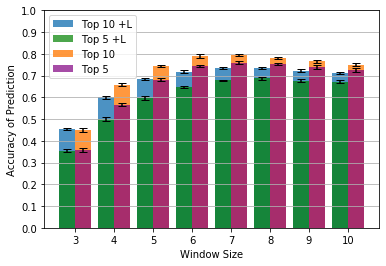

In [67]:
fig, ax = plt.subplots()
ax.bar(Results_lemmatize.index.values, Results_lemmatize['Predicted_top10_mean'].values, yerr=Results_lemmatize['Predicted_top10_std'].values, width=-0.4, align='edge', alpha=0.8, ecolor='black', capsize=4,  label='Top 10 +L')
ax.bar(Results_lemmatize.index.values, Results_lemmatize['Predicted_top5_mean'].values, yerr=Results_lemmatize['Predicted_top5_std'].values, color='green', width=-0.4, align='edge', alpha=0.7, ecolor='black', capsize=4, label='Top 5 +L')
ax.bar(Results_Nolemmatize.index.values, Results_Nolemmatize['Predicted_top10_mean'].values, yerr=Results_Nolemmatize['Predicted_top10_std'].values, width=0.4, align='edge', alpha=0.8, ecolor='black', capsize=4,  label='Top 10')
ax.bar(Results_Nolemmatize.index.values, Results_Nolemmatize['Predicted_top5_mean'].values, yerr=Results_Nolemmatize['Predicted_top5_std'].values, color='purple', width=0.4, align='edge', alpha=0.7, ecolor='black', capsize=4, label='Top 5')
ax.set_ylabel('Accuracy of Prediction')
ax.set_xlabel('Window Size')
ax.set_xticks(Results_lemmatize.index.values)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.yaxis.grid(True)
ax.legend()
plt.savefig(category+'-bars.pdf', dpi=500, bbox_inches='tight')

### Taking a look at the predicted probabilities of the best setup:

In [240]:
lemmatize = False
window = 7

# Building the corpus
corpus = Corpus(meta = 'Corpus BBC '+category+' News, only verbs as target, no stopwords.')
import_bbc_folder(category,corpus , lemmatize = lemmatize)

# Building the dataset
sentences , verbs = Build_Dataset([category], corpus, window, one_hot=True , lemmatize=lemmatize)

# Getting the train_valid_test data:
x_train, x_test, y_train, y_test = train_test_split(sentences, verbs, test_size=0.1, random_state=123)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=123)

# Building the model
vocab_size = len(corpus.get_vocabs_to_learn())
verbs_size = len(corpus.get_verbs_to_learn())
hidden_dim = 500

model = CBOW(vocab_size, hidden_dim, verbs_size)
model.cuda()

# Training the model
lr=0.001
batch_size = 512
n_epochs = 20
file_name = 'CBOW_BBC'+category+'_window='+str(window)+'_forevaluation.pt'

train_losses, valid_losses = Train_model(model, lr, batch_size, n_epochs, file_name, x_train, y_train, x_valid, y_valid)

# Loading the best model parameters
model.load_state_dict(torch.load(file_name))

Epoch: 1 	Training Loss: 6.578046 	Validation Loss: 5.933753
Validation loss decreased (inf --> 5.93375).  Saving model ...
Epoch: 2 	Training Loss: 5.880662 	Validation Loss: 5.641151
Validation loss decreased (5.93375 --> 5.64115).  Saving model ...
Epoch: 3 	Training Loss: 5.328329 	Validation Loss: 5.192880
Validation loss decreased (5.64115 --> 5.19288).  Saving model ...
Epoch: 4 	Training Loss: 4.503368 	Validation Loss: 4.626440
Validation loss decreased (5.19288 --> 4.62644).  Saving model ...
Epoch: 5 	Training Loss: 3.559255 	Validation Loss: 4.085675
Validation loss decreased (4.62644 --> 4.08567).  Saving model ...
Epoch: 6 	Training Loss: 2.704724 	Validation Loss: 3.648505
Validation loss decreased (4.08567 --> 3.64850).  Saving model ...
Epoch: 7 	Training Loss: 2.035357 	Validation Loss: 3.320251
Validation loss decreased (3.64850 --> 3.32025).  Saving model ...
Epoch: 8 	Training Loss: 1.542706 	Validation Loss: 3.080491
Validation loss decreased (3.32025 --> 3.08049)

<All keys matched successfully>

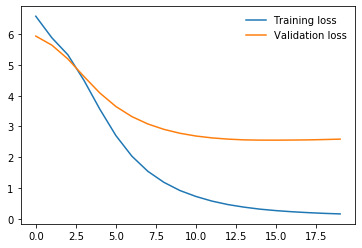

In [241]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(valid_losses, label = 'Validation loss')
plt.legend(frameon=False)

Looking into a sample of predictions:

In [242]:
getbatch = iter(get_batch(x_test, y_test , 16))
sentences, verbs = next(getbatch)

In [243]:
model.eval()
output = model(sentences.cuda().float())
ps = torch.exp(output)
top_p, top_class = ps.topk(10, dim=1)

In [244]:
for clas, t in zip(top_class, verbs):
    print(corpus.get_verb_from_index(t.item()) , ': ')
    print('\t' ,  end='' )
    for val in clas:
        print(corpus.get_verb_from_index(val.item()), end='\t' )
    print()

sold
	sold	bid	dropped	report	pay	produced	close	went	started	seem	
came
	buying	holds	profit	bought	sold	came	announced	revealed	owned	fell	
euro
	euro	help	makes	remained	given	accounts	focusing	fund	strengthened	said	
represent
	claims	wants	holding	claim	making	buy	gain	control	backing	bid	
added
	see	added	expects	start	expected	back	reported	hit	closed	holding	
help
	increase	needed	use	sent	programme	cuts	linked	return	solve	recommended	
including
	including	helped	enjoyed	said	boosting	includes	rise	mobile	demand	employed	
called
	left	called	yukos	trying	following	investigate	said	confirmed	saying	return	
dominate
	build	provide	dominate	prefer	starting	demand	said	recall	including	launch	
slowed
	slowed	grown	fuelled	estimate	back	accelerated	marked	fell	bounced	seeing	
force
	show	said	force	created	following	pursue	buy	attend	opened	including	
remains
	remains	seen	falling	slowing	fell	means	growing	going	said	struggling	
shown
	shown	surrounding	reject	offer	made	says	give

In [42]:
i = -1
sent = np.where(np.array(sentences[i]) != 0)[0]
corpus.get_vocab_from_index(sent.tolist())

"['increase', 'rising', 'prices', 'product', 'able', 'ore']"

In [20]:
probs = top_p[i].tolist()
vrbs = corpus.get_verb_from_index(top_class[i].tolist())

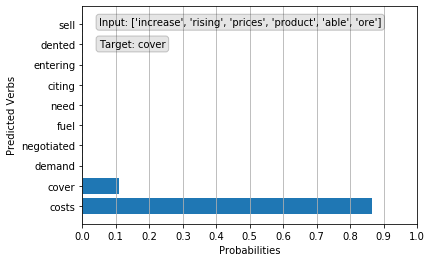

In [61]:
fig, ax = plt.subplots()
props = dict(boxstyle='round', facecolor='grey', alpha=0.2)
ax.text(0.05, 0.95, 'Input: '+str(corpus.get_vocab_from_index(sent.tolist())), transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
ax.text(0.05, 0.85, 'Target: '+corpus.get_verb_from_index(verbs[i].item()), transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
ax.barh(vrbs, probs, align='center')
plt.xlabel('Probabilities')
plt.ylabel('Predicted Verbs')
ax.set_xticks(np.arange(0,1.1,0.1))
ax.xaxis.grid(True)
plt.savefig(category+'-probs.pdf', dpi=500, bbox_inches='tight')
plt.show()

### 2- Obtaining prediction results when learning the verbs in entertainment articles:

In [69]:
category = 'entertainment'

In [70]:
# Preparing the results dataframes:
windows = list(range(3,11))
columns = ['Predicted_top5_mean', 'Predicted_top5_std', 'Predicted_top10_mean', 'Predicted_top10_std']
Results_Nolemmatize = pd.DataFrame(index=index, columns=columns)
Results_lemmatize = pd.DataFrame(index=index, columns=columns)

# Getting some results:
for lemmatize in [False , True]:
    
    # Building the corpus
    corpus = Corpus(meta = 'Corpus BBC '+category+' News, only verbs as target, no stopwords.')
    import_bbc_folder(category,corpus , lemmatize = lemmatize)
    
    for window in windows:
                
        # Building the dataset:
        sentences , verbs = Build_Dataset([category], corpus, window, one_hot=True , lemmatize=lemmatize)
        
        print('\n Starting:...-> Lemmatize =',lemmatize,', window =', window , '\n')
        
        lr=0.001
        batch_size = 512
        n_epochs = 20
        file_name = 'CBOW_BBC_'+category+'_lemmatize='+str(lemmatize)+'_window='+str(window)+'_crossval.pt'
        random_state = 123
        K = 10
        
        # Cross validating the model:
        training_losses, validation_losses, predicted_intop5, predicted_intop10 = K_fold_Cross_validate(K , sentences , verbs,
                                                                                                corpus, lr,batch_size ,n_epochs,
                                                                                                file_name, random_state)
        
        # Getting the prediction measures mean and standard deviation:
        predicted_intop5_mean , predicted_intop5_std  = np.mean(predicted_intop5) , np.std(predicted_intop5)
        predicted_intop10_mean , predicted_intop10_std  = np.mean(predicted_intop10) , np.std(predicted_intop10)
        
        # Adding the measures to the corresponding dataframe:
        if lemmatize:
            Results_lemmatize.loc[window , 'Predicted_top5_mean'] = predicted_intop5_mean
            Results_lemmatize.loc[window , 'Predicted_top5_std'] = predicted_intop5_std
            Results_lemmatize.loc[window , 'Predicted_top10_mean'] = predicted_intop10_mean
            Results_lemmatize.loc[window , 'Predicted_top10_std'] = predicted_intop10_std
        else:
            Results_Nolemmatize.loc[window , 'Predicted_top5_mean'] = predicted_intop5_mean
            Results_Nolemmatize.loc[window , 'Predicted_top5_std'] = predicted_intop5_std
            Results_Nolemmatize.loc[window , 'Predicted_top10_mean'] = predicted_intop10_mean
            Results_Nolemmatize.loc[window , 'Predicted_top10_std'] = predicted_intop10_std
        


 Starting:...-> Lemmatize = False , window = 3 

Epoch: 1 	Training Loss: 6.443262 	Validation Loss: 5.268994
Validation loss decreased (inf --> 5.26899).  Saving model ...
Epoch: 2 	Training Loss: 5.846994 	Validation Loss: 5.169582
Validation loss decreased (5.26899 --> 5.16958).  Saving model ...
Epoch: 3 	Training Loss: 5.652926 	Validation Loss: 5.057024
Validation loss decreased (5.16958 --> 5.05702).  Saving model ...
Epoch: 4 	Training Loss: 5.388341 	Validation Loss: 4.900677
Validation loss decreased (5.05702 --> 4.90068).  Saving model ...
Epoch: 5 	Training Loss: 5.031251 	Validation Loss: 4.718679
Validation loss decreased (4.90068 --> 4.71868).  Saving model ...
Epoch: 6 	Training Loss: 4.611068 	Validation Loss: 4.531679
Validation loss decreased (4.71868 --> 4.53168).  Saving model ...
Epoch: 7 	Training Loss: 4.153723 	Validation Loss: 4.356729
Validation loss decreased (4.53168 --> 4.35673).  Saving model ...
Epoch: 8 	Training Loss: 3.693818 	Validation Loss: 4.2080

Epoch: 14 	Training Loss: 1.838676 	Validation Loss: 3.878027
Validation loss decreased (3.88251 --> 3.87803).  Saving model ...
Epoch: 15 	Training Loss: 1.687105 	Validation Loss: 3.884712
Epoch: 16 	Training Loss: 1.564241 	Validation Loss: 3.898528
Epoch: 17 	Training Loss: 1.463798 	Validation Loss: 3.917621
Epoch: 18 	Training Loss: 1.378163 	Validation Loss: 3.941279
Epoch: 19 	Training Loss: 1.307734 	Validation Loss: 3.969736
Epoch: 20 	Training Loss: 1.249341 	Validation Loss: 3.999980
Epoch: 1 	Training Loss: 6.445588 	Validation Loss: 5.269687
Validation loss decreased (inf --> 5.26969).  Saving model ...
Epoch: 2 	Training Loss: 5.847068 	Validation Loss: 5.165260
Validation loss decreased (5.26969 --> 5.16526).  Saving model ...
Epoch: 3 	Training Loss: 5.654934 	Validation Loss: 5.056477
Validation loss decreased (5.16526 --> 5.05648).  Saving model ...
Epoch: 4 	Training Loss: 5.393125 	Validation Loss: 4.904117
Validation loss decreased (5.05648 --> 4.90412).  Saving m

Epoch: 10 	Training Loss: 2.873787 	Validation Loss: 4.029783
Validation loss decreased (4.11639 --> 4.02978).  Saving model ...
Epoch: 11 	Training Loss: 2.543343 	Validation Loss: 3.967442
Validation loss decreased (4.02978 --> 3.96744).  Saving model ...
Epoch: 12 	Training Loss: 2.268788 	Validation Loss: 3.926887
Validation loss decreased (3.96744 --> 3.92689).  Saving model ...
Epoch: 13 	Training Loss: 2.036691 	Validation Loss: 3.904898
Validation loss decreased (3.92689 --> 3.90490).  Saving model ...
Epoch: 14 	Training Loss: 1.849844 	Validation Loss: 3.896637
Validation loss decreased (3.90490 --> 3.89664).  Saving model ...
Epoch: 15 	Training Loss: 1.698958 	Validation Loss: 3.898015
Epoch: 16 	Training Loss: 1.571944 	Validation Loss: 3.908695
Epoch: 17 	Training Loss: 1.472975 	Validation Loss: 3.926372
Epoch: 18 	Training Loss: 1.386191 	Validation Loss: 3.950348
Epoch: 19 	Training Loss: 1.318562 	Validation Loss: 3.978226
Epoch: 20 	Training Loss: 1.258217 	Validatio

Epoch: 4 	Training Loss: 4.973702 	Validation Loss: 4.371941
Validation loss decreased (4.65531 --> 4.37194).  Saving model ...
Epoch: 5 	Training Loss: 4.388835 	Validation Loss: 4.077193
Validation loss decreased (4.37194 --> 4.07719).  Saving model ...
Epoch: 6 	Training Loss: 3.761088 	Validation Loss: 3.801445
Validation loss decreased (4.07719 --> 3.80145).  Saving model ...
Epoch: 7 	Training Loss: 3.155813 	Validation Loss: 3.564599
Validation loss decreased (3.80145 --> 3.56460).  Saving model ...
Epoch: 8 	Training Loss: 2.619701 	Validation Loss: 3.374505
Validation loss decreased (3.56460 --> 3.37450).  Saving model ...
Epoch: 9 	Training Loss: 2.180665 	Validation Loss: 3.227003
Validation loss decreased (3.37450 --> 3.22700).  Saving model ...
Epoch: 10 	Training Loss: 1.824287 	Validation Loss: 3.116391
Validation loss decreased (3.22700 --> 3.11639).  Saving model ...
Epoch: 11 	Training Loss: 1.546304 	Validation Loss: 3.036792
Validation loss decreased (3.11639 --> 3.

Epoch: 15 	Training Loss: 0.911894 	Validation Loss: 2.894554
Validation loss decreased (2.90884 --> 2.89455).  Saving model ...
Epoch: 16 	Training Loss: 0.823913 	Validation Loss: 2.889777
Validation loss decreased (2.89455 --> 2.88978).  Saving model ...
Epoch: 17 	Training Loss: 0.758705 	Validation Loss: 2.891303
Epoch: 18 	Training Loss: 0.696156 	Validation Loss: 2.899735
Epoch: 19 	Training Loss: 0.644134 	Validation Loss: 2.913717
Epoch: 20 	Training Loss: 0.607707 	Validation Loss: 2.930686
Epoch: 1 	Training Loss: 6.425081 	Validation Loss: 5.039090
Validation loss decreased (inf --> 5.03909).  Saving model ...
Epoch: 2 	Training Loss: 5.772487 	Validation Loss: 4.893992
Validation loss decreased (5.03909 --> 4.89399).  Saving model ...
Epoch: 3 	Training Loss: 5.445103 	Validation Loss: 4.680194
Validation loss decreased (4.89399 --> 4.68019).  Saving model ...
Epoch: 4 	Training Loss: 4.976732 	Validation Loss: 4.403187
Validation loss decreased (4.68019 --> 4.40319).  Sav

Epoch: 8 	Training Loss: 2.609166 	Validation Loss: 3.358015
Validation loss decreased (3.55668 --> 3.35802).  Saving model ...
Epoch: 9 	Training Loss: 2.159240 	Validation Loss: 3.205641
Validation loss decreased (3.35802 --> 3.20564).  Saving model ...
Epoch: 10 	Training Loss: 1.802886 	Validation Loss: 3.092874
Validation loss decreased (3.20564 --> 3.09287).  Saving model ...
Epoch: 11 	Training Loss: 1.524324 	Validation Loss: 3.012784
Validation loss decreased (3.09287 --> 3.01278).  Saving model ...
Epoch: 12 	Training Loss: 1.309410 	Validation Loss: 2.954679
Validation loss decreased (3.01278 --> 2.95468).  Saving model ...
Epoch: 13 	Training Loss: 1.136570 	Validation Loss: 2.918747
Validation loss decreased (2.95468 --> 2.91875).  Saving model ...
Epoch: 14 	Training Loss: 1.008025 	Validation Loss: 2.897926
Validation loss decreased (2.91875 --> 2.89793).  Saving model ...
Epoch: 15 	Training Loss: 0.902717 	Validation Loss: 2.886384
Validation loss decreased (2.89793 --

Epoch: 18 	Training Loss: 0.404219 	Validation Loss: 2.401777
Epoch: 19 	Training Loss: 0.371802 	Validation Loss: 2.408976
Epoch: 20 	Training Loss: 0.338461 	Validation Loss: 2.422838
Epoch: 1 	Training Loss: 6.411038 	Validation Loss: 5.221544
Validation loss decreased (inf --> 5.22154).  Saving model ...
Epoch: 2 	Training Loss: 5.698214 	Validation Loss: 5.000460
Validation loss decreased (5.22154 --> 5.00046).  Saving model ...
Epoch: 3 	Training Loss: 5.251827 	Validation Loss: 4.678883
Validation loss decreased (5.00046 --> 4.67888).  Saving model ...
Epoch: 4 	Training Loss: 4.633882 	Validation Loss: 4.280340
Validation loss decreased (4.67888 --> 4.28034).  Saving model ...
Epoch: 5 	Training Loss: 3.908574 	Validation Loss: 3.865809
Validation loss decreased (4.28034 --> 3.86581).  Saving model ...
Epoch: 6 	Training Loss: 3.179275 	Validation Loss: 3.494167
Validation loss decreased (3.86581 --> 3.49417).  Saving model ...
Epoch: 7 	Training Loss: 2.529831 	Validation Loss

Epoch: 9 	Training Loss: 1.594464 	Validation Loss: 2.770271
Validation loss decreased (2.94650 --> 2.77027).  Saving model ...
Epoch: 10 	Training Loss: 1.290777 	Validation Loss: 2.639330
Validation loss decreased (2.77027 --> 2.63933).  Saving model ...
Epoch: 11 	Training Loss: 1.063094 	Validation Loss: 2.541730
Validation loss decreased (2.63933 --> 2.54173).  Saving model ...
Epoch: 12 	Training Loss: 0.888238 	Validation Loss: 2.472136
Validation loss decreased (2.54173 --> 2.47214).  Saving model ...
Epoch: 13 	Training Loss: 0.754671 	Validation Loss: 2.422423
Validation loss decreased (2.47214 --> 2.42242).  Saving model ...
Epoch: 14 	Training Loss: 0.651902 	Validation Loss: 2.388282
Validation loss decreased (2.42242 --> 2.38828).  Saving model ...
Epoch: 15 	Training Loss: 0.569800 	Validation Loss: 2.367029
Validation loss decreased (2.38828 --> 2.36703).  Saving model ...
Epoch: 16 	Training Loss: 0.504353 	Validation Loss: 2.354838
Validation loss decreased (2.36703 -

Epoch: 19 	Training Loss: 0.370756 	Validation Loss: 2.418752
Epoch: 20 	Training Loss: 0.339604 	Validation Loss: 2.430356
Epoch: 1 	Training Loss: 6.406526 	Validation Loss: 5.200338
Validation loss decreased (inf --> 5.20034).  Saving model ...
Epoch: 2 	Training Loss: 5.700178 	Validation Loss: 4.973012
Validation loss decreased (5.20034 --> 4.97301).  Saving model ...
Epoch: 3 	Training Loss: 5.256714 	Validation Loss: 4.648941
Validation loss decreased (4.97301 --> 4.64894).  Saving model ...
Epoch: 4 	Training Loss: 4.641194 	Validation Loss: 4.255426
Validation loss decreased (4.64894 --> 4.25543).  Saving model ...
Epoch: 5 	Training Loss: 3.916275 	Validation Loss: 3.856235
Validation loss decreased (4.25543 --> 3.85624).  Saving model ...
Epoch: 6 	Training Loss: 3.181852 	Validation Loss: 3.496875
Validation loss decreased (3.85624 --> 3.49688).  Saving model ...
Epoch: 7 	Training Loss: 2.531318 	Validation Loss: 3.200084
Validation loss decreased (3.49688 --> 3.20008).  S

Epoch: 9 	Training Loss: 1.312194 	Validation Loss: 2.867143
Validation loss decreased (3.04613 --> 2.86714).  Saving model ...
Epoch: 10 	Training Loss: 1.043715 	Validation Loss: 2.733992
Validation loss decreased (2.86714 --> 2.73399).  Saving model ...
Epoch: 11 	Training Loss: 0.837503 	Validation Loss: 2.637111
Validation loss decreased (2.73399 --> 2.63711).  Saving model ...
Epoch: 12 	Training Loss: 0.683203 	Validation Loss: 2.568385
Validation loss decreased (2.63711 --> 2.56838).  Saving model ...
Epoch: 13 	Training Loss: 0.565238 	Validation Loss: 2.522262
Validation loss decreased (2.56838 --> 2.52226).  Saving model ...
Epoch: 14 	Training Loss: 0.477261 	Validation Loss: 2.492817
Validation loss decreased (2.52226 --> 2.49282).  Saving model ...
Epoch: 15 	Training Loss: 0.405475 	Validation Loss: 2.473931
Validation loss decreased (2.49282 --> 2.47393).  Saving model ...
Epoch: 16 	Training Loss: 0.350946 	Validation Loss: 2.465400
Validation loss decreased (2.47393 -

Epoch: 19 	Training Loss: 0.251724 	Validation Loss: 2.251362
Epoch: 20 	Training Loss: 0.227524 	Validation Loss: 2.256171
Epoch: 1 	Training Loss: 6.303171 	Validation Loss: 5.628332
Validation loss decreased (inf --> 5.62833).  Saving model ...
Epoch: 2 	Training Loss: 5.549041 	Validation Loss: 5.360211
Validation loss decreased (5.62833 --> 5.36021).  Saving model ...
Epoch: 3 	Training Loss: 5.056272 	Validation Loss: 4.969088
Validation loss decreased (5.36021 --> 4.96909).  Saving model ...
Epoch: 4 	Training Loss: 4.385559 	Validation Loss: 4.492105
Validation loss decreased (4.96909 --> 4.49211).  Saving model ...
Epoch: 5 	Training Loss: 3.606486 	Validation Loss: 4.020398
Validation loss decreased (4.49211 --> 4.02040).  Saving model ...
Epoch: 6 	Training Loss: 2.849228 	Validation Loss: 3.616761
Validation loss decreased (4.02040 --> 3.61676).  Saving model ...
Epoch: 7 	Training Loss: 2.203077 	Validation Loss: 3.296696
Validation loss decreased (3.61676 --> 3.29670).  S

Epoch: 10 	Training Loss: 1.047234 	Validation Loss: 2.786700
Validation loss decreased (2.91795 --> 2.78670).  Saving model ...
Epoch: 11 	Training Loss: 0.838759 	Validation Loss: 2.694300
Validation loss decreased (2.78670 --> 2.69430).  Saving model ...
Epoch: 12 	Training Loss: 0.683625 	Validation Loss: 2.627280
Validation loss decreased (2.69430 --> 2.62728).  Saving model ...
Epoch: 13 	Training Loss: 0.566771 	Validation Loss: 2.578432
Validation loss decreased (2.62728 --> 2.57843).  Saving model ...
Epoch: 14 	Training Loss: 0.473671 	Validation Loss: 2.545999
Validation loss decreased (2.57843 --> 2.54600).  Saving model ...
Epoch: 15 	Training Loss: 0.405412 	Validation Loss: 2.525173
Validation loss decreased (2.54600 --> 2.52517).  Saving model ...
Epoch: 16 	Training Loss: 0.348517 	Validation Loss: 2.515751
Validation loss decreased (2.52517 --> 2.51575).  Saving model ...
Epoch: 17 	Training Loss: 0.307565 	Validation Loss: 2.513163
Validation loss decreased (2.51575 

Epoch: 17 	Training Loss: 0.256267 	Validation Loss: 2.069509
Validation loss decreased (2.07432 --> 2.06951).  Saving model ...
Epoch: 18 	Training Loss: 0.223129 	Validation Loss: 2.070531
Epoch: 19 	Training Loss: 0.201584 	Validation Loss: 2.072565
Epoch: 20 	Training Loss: 0.179806 	Validation Loss: 2.076944
Epoch: 1 	Training Loss: 6.339262 	Validation Loss: 5.030840
Validation loss decreased (inf --> 5.03084).  Saving model ...
Epoch: 2 	Training Loss: 5.518342 	Validation Loss: 4.743910
Validation loss decreased (5.03084 --> 4.74391).  Saving model ...
Epoch: 3 	Training Loss: 4.993498 	Validation Loss: 4.366017
Validation loss decreased (4.74391 --> 4.36602).  Saving model ...
Epoch: 4 	Training Loss: 4.288981 	Validation Loss: 3.926275
Validation loss decreased (4.36602 --> 3.92628).  Saving model ...
Epoch: 5 	Training Loss: 3.489031 	Validation Loss: 3.490188
Validation loss decreased (3.92628 --> 3.49019).  Saving model ...
Epoch: 6 	Training Loss: 2.728749 	Validation Los

Epoch: 8 	Training Loss: 1.593859 	Validation Loss: 2.665739
Validation loss decreased (2.89538 --> 2.66574).  Saving model ...
Epoch: 9 	Training Loss: 1.233966 	Validation Loss: 2.495978
Validation loss decreased (2.66574 --> 2.49598).  Saving model ...
Epoch: 10 	Training Loss: 0.969818 	Validation Loss: 2.373312
Validation loss decreased (2.49598 --> 2.37331).  Saving model ...
Epoch: 11 	Training Loss: 0.769462 	Validation Loss: 2.285052
Validation loss decreased (2.37331 --> 2.28505).  Saving model ...
Epoch: 12 	Training Loss: 0.619366 	Validation Loss: 2.220429
Validation loss decreased (2.28505 --> 2.22043).  Saving model ...
Epoch: 13 	Training Loss: 0.503519 	Validation Loss: 2.177197
Validation loss decreased (2.22043 --> 2.17720).  Saving model ...
Epoch: 14 	Training Loss: 0.417106 	Validation Loss: 2.147879
Validation loss decreased (2.17720 --> 2.14788).  Saving model ...
Epoch: 15 	Training Loss: 0.344991 	Validation Loss: 2.131225
Validation loss decreased (2.14788 --

Epoch: 16 	Training Loss: 0.293526 	Validation Loss: 1.974082
Validation loss decreased (1.98616 --> 1.97408).  Saving model ...
Epoch: 17 	Training Loss: 0.254405 	Validation Loss: 1.966805
Validation loss decreased (1.97408 --> 1.96680).  Saving model ...
Epoch: 18 	Training Loss: 0.221139 	Validation Loss: 1.965582
Validation loss decreased (1.96680 --> 1.96558).  Saving model ...
Epoch: 19 	Training Loss: 0.197996 	Validation Loss: 1.967181
Epoch: 20 	Training Loss: 0.177436 	Validation Loss: 1.973358

 Starting:...-> Lemmatize = False , window = 8 

Epoch: 1 	Training Loss: 6.332326 	Validation Loss: 4.418834
Validation loss decreased (inf --> 4.41883).  Saving model ...
Epoch: 2 	Training Loss: 5.445841 	Validation Loss: 4.134397
Validation loss decreased (4.41883 --> 4.13440).  Saving model ...
Epoch: 3 	Training Loss: 4.928945 	Validation Loss: 3.815652
Validation loss decreased (4.13440 --> 3.81565).  Saving model ...
Epoch: 4 	Training Loss: 4.246859 	Validation Loss: 3.43234

Epoch: 5 	Training Loss: 3.458638 	Validation Loss: 3.162922
Validation loss decreased (3.53042 --> 3.16292).  Saving model ...
Epoch: 6 	Training Loss: 2.724407 	Validation Loss: 2.836613
Validation loss decreased (3.16292 --> 2.83661).  Saving model ...
Epoch: 7 	Training Loss: 2.103475 	Validation Loss: 2.572085
Validation loss decreased (2.83661 --> 2.57209).  Saving model ...
Epoch: 8 	Training Loss: 1.619487 	Validation Loss: 2.372530
Validation loss decreased (2.57209 --> 2.37253).  Saving model ...
Epoch: 9 	Training Loss: 1.252866 	Validation Loss: 2.227066
Validation loss decreased (2.37253 --> 2.22707).  Saving model ...
Epoch: 10 	Training Loss: 0.979502 	Validation Loss: 2.121152
Validation loss decreased (2.22707 --> 2.12115).  Saving model ...
Epoch: 11 	Training Loss: 0.770881 	Validation Loss: 2.042226
Validation loss decreased (2.12115 --> 2.04223).  Saving model ...
Epoch: 12 	Training Loss: 0.612188 	Validation Loss: 1.983436
Validation loss decreased (2.04223 --> 1

Epoch: 13 	Training Loss: 0.494901 	Validation Loss: 1.875758
Validation loss decreased (1.91763 --> 1.87576).  Saving model ...
Epoch: 14 	Training Loss: 0.401384 	Validation Loss: 1.847353
Validation loss decreased (1.87576 --> 1.84735).  Saving model ...
Epoch: 15 	Training Loss: 0.331938 	Validation Loss: 1.829139
Validation loss decreased (1.84735 --> 1.82914).  Saving model ...
Epoch: 16 	Training Loss: 0.275564 	Validation Loss: 1.817016
Validation loss decreased (1.82914 --> 1.81702).  Saving model ...
Epoch: 17 	Training Loss: 0.235744 	Validation Loss: 1.811722
Validation loss decreased (1.81702 --> 1.81172).  Saving model ...
Epoch: 18 	Training Loss: 0.204908 	Validation Loss: 1.811220
Validation loss decreased (1.81172 --> 1.81122).  Saving model ...
Epoch: 19 	Training Loss: 0.179091 	Validation Loss: 1.813298
Epoch: 20 	Training Loss: 0.159104 	Validation Loss: 1.815541
Epoch: 1 	Training Loss: 6.338475 	Validation Loss: 4.405892
Validation loss decreased (inf --> 4.4058

Epoch: 2 	Training Loss: 5.435211 	Validation Loss: 5.018038
Validation loss decreased (5.42921 --> 5.01804).  Saving model ...
Epoch: 3 	Training Loss: 4.929756 	Validation Loss: 4.664087
Validation loss decreased (5.01804 --> 4.66409).  Saving model ...
Epoch: 4 	Training Loss: 4.296098 	Validation Loss: 4.235284
Validation loss decreased (4.66409 --> 4.23528).  Saving model ...
Epoch: 5 	Training Loss: 3.559539 	Validation Loss: 3.809832
Validation loss decreased (4.23528 --> 3.80983).  Saving model ...
Epoch: 6 	Training Loss: 2.839672 	Validation Loss: 3.447521
Validation loss decreased (3.80983 --> 3.44752).  Saving model ...
Epoch: 7 	Training Loss: 2.224178 	Validation Loss: 3.157452
Validation loss decreased (3.44752 --> 3.15745).  Saving model ...
Epoch: 8 	Training Loss: 1.732609 	Validation Loss: 2.929064
Validation loss decreased (3.15745 --> 2.92906).  Saving model ...
Epoch: 9 	Training Loss: 1.352404 	Validation Loss: 2.753103
Validation loss decreased (2.92906 --> 2.75

Epoch: 9 	Training Loss: 1.360893 	Validation Loss: 2.729418
Validation loss decreased (2.90186 --> 2.72942).  Saving model ...
Epoch: 10 	Training Loss: 1.067722 	Validation Loss: 2.596637
Validation loss decreased (2.72942 --> 2.59664).  Saving model ...
Epoch: 11 	Training Loss: 0.843286 	Validation Loss: 2.496983
Validation loss decreased (2.59664 --> 2.49698).  Saving model ...
Epoch: 12 	Training Loss: 0.670904 	Validation Loss: 2.425306
Validation loss decreased (2.49698 --> 2.42531).  Saving model ...
Epoch: 13 	Training Loss: 0.533855 	Validation Loss: 2.375006
Validation loss decreased (2.42531 --> 2.37501).  Saving model ...
Epoch: 14 	Training Loss: 0.431035 	Validation Loss: 2.341094
Validation loss decreased (2.37501 --> 2.34109).  Saving model ...
Epoch: 15 	Training Loss: 0.351183 	Validation Loss: 2.319606
Validation loss decreased (2.34109 --> 2.31961).  Saving model ...
Epoch: 16 	Training Loss: 0.292916 	Validation Loss: 2.308320
Validation loss decreased (2.31961 -

Epoch: 16 	Training Loss: 0.297306 	Validation Loss: 2.236452
Validation loss decreased (2.25575 --> 2.23645).  Saving model ...
Epoch: 17 	Training Loss: 0.251651 	Validation Loss: 2.226609
Validation loss decreased (2.23645 --> 2.22661).  Saving model ...
Epoch: 18 	Training Loss: 0.215507 	Validation Loss: 2.221772
Validation loss decreased (2.22661 --> 2.22177).  Saving model ...
Epoch: 19 	Training Loss: 0.186437 	Validation Loss: 2.219583
Validation loss decreased (2.22177 --> 2.21958).  Saving model ...
Epoch: 20 	Training Loss: 0.164533 	Validation Loss: 2.221198
Epoch: 1 	Training Loss: 6.351537 	Validation Loss: 5.451334
Validation loss decreased (inf --> 5.45133).  Saving model ...
Epoch: 2 	Training Loss: 5.433097 	Validation Loss: 5.073117
Validation loss decreased (5.45133 --> 5.07312).  Saving model ...
Epoch: 3 	Training Loss: 4.931895 	Validation Loss: 4.728418
Validation loss decreased (5.07312 --> 4.72842).  Saving model ...
Epoch: 4 	Training Loss: 4.305429 	Validat

Epoch: 3 	Training Loss: 5.056239 	Validation Loss: 3.867142
Validation loss decreased (4.13691 --> 3.86714).  Saving model ...
Epoch: 4 	Training Loss: 4.464192 	Validation Loss: 3.556947
Validation loss decreased (3.86714 --> 3.55695).  Saving model ...
Epoch: 5 	Training Loss: 3.773094 	Validation Loss: 3.225582
Validation loss decreased (3.55695 --> 3.22558).  Saving model ...
Epoch: 6 	Training Loss: 3.066230 	Validation Loss: 2.914014
Validation loss decreased (3.22558 --> 2.91401).  Saving model ...
Epoch: 7 	Training Loss: 2.433720 	Validation Loss: 2.656347
Validation loss decreased (2.91401 --> 2.65635).  Saving model ...
Epoch: 8 	Training Loss: 1.918090 	Validation Loss: 2.454940
Validation loss decreased (2.65635 --> 2.45494).  Saving model ...
Epoch: 9 	Training Loss: 1.513724 	Validation Loss: 2.296554
Validation loss decreased (2.45494 --> 2.29655).  Saving model ...
Epoch: 10 	Training Loss: 1.200038 	Validation Loss: 2.174694
Validation loss decreased (2.29655 --> 2.1

Epoch: 9 	Training Loss: 1.501489 	Validation Loss: 2.271624
Validation loss decreased (2.41971 --> 2.27162).  Saving model ...
Epoch: 10 	Training Loss: 1.194722 	Validation Loss: 2.157637
Validation loss decreased (2.27162 --> 2.15764).  Saving model ...
Epoch: 11 	Training Loss: 0.949506 	Validation Loss: 2.068870
Validation loss decreased (2.15764 --> 2.06887).  Saving model ...
Epoch: 12 	Training Loss: 0.757153 	Validation Loss: 2.002945
Validation loss decreased (2.06887 --> 2.00294).  Saving model ...
Epoch: 13 	Training Loss: 0.609825 	Validation Loss: 1.952936
Validation loss decreased (2.00294 --> 1.95294).  Saving model ...
Epoch: 14 	Training Loss: 0.491449 	Validation Loss: 1.918873
Validation loss decreased (1.95294 --> 1.91887).  Saving model ...
Epoch: 15 	Training Loss: 0.397980 	Validation Loss: 1.897830
Validation loss decreased (1.91887 --> 1.89783).  Saving model ...
Epoch: 16 	Training Loss: 0.328626 	Validation Loss: 1.881329
Validation loss decreased (1.89783 -

Epoch: 15 	Training Loss: 0.408344 	Validation Loss: 1.810099
Validation loss decreased (1.83384 --> 1.81010).  Saving model ...
Epoch: 16 	Training Loss: 0.337762 	Validation Loss: 1.792616
Validation loss decreased (1.81010 --> 1.79262).  Saving model ...
Epoch: 17 	Training Loss: 0.281201 	Validation Loss: 1.780438
Validation loss decreased (1.79262 --> 1.78044).  Saving model ...
Epoch: 18 	Training Loss: 0.240035 	Validation Loss: 1.773868
Validation loss decreased (1.78044 --> 1.77387).  Saving model ...
Epoch: 19 	Training Loss: 0.205990 	Validation Loss: 1.770171
Validation loss decreased (1.77387 --> 1.77017).  Saving model ...
Epoch: 20 	Training Loss: 0.180914 	Validation Loss: 1.767144
Validation loss decreased (1.77017 --> 1.76714).  Saving model ...
Epoch: 1 	Training Loss: 6.545631 	Validation Loss: 4.582066
Validation loss decreased (inf --> 4.58207).  Saving model ...
Epoch: 2 	Training Loss: 5.593050 	Validation Loss: 4.125456
Validation loss decreased (4.58207 --> 4.


 Starting:...-> Lemmatize = True , window = 3 

Epoch: 1 	Training Loss: 5.876977 	Validation Loss: 4.860609
Validation loss decreased (inf --> 4.86061).  Saving model ...
Epoch: 2 	Training Loss: 5.295933 	Validation Loss: 4.757221
Validation loss decreased (4.86061 --> 4.75722).  Saving model ...
Epoch: 3 	Training Loss: 5.091509 	Validation Loss: 4.619859
Validation loss decreased (4.75722 --> 4.61986).  Saving model ...
Epoch: 4 	Training Loss: 4.811563 	Validation Loss: 4.459714
Validation loss decreased (4.61986 --> 4.45971).  Saving model ...
Epoch: 5 	Training Loss: 4.474874 	Validation Loss: 4.305955
Validation loss decreased (4.45971 --> 4.30596).  Saving model ...
Epoch: 6 	Training Loss: 4.111210 	Validation Loss: 4.172909
Validation loss decreased (4.30596 --> 4.17291).  Saving model ...
Epoch: 7 	Training Loss: 3.745110 	Validation Loss: 4.066892
Validation loss decreased (4.17291 --> 4.06689).  Saving model ...
Epoch: 8 	Training Loss: 3.398300 	Validation Loss: 3.98849

Epoch: 20 	Training Loss: 1.624211 	Validation Loss: 3.923831
Epoch: 1 	Training Loss: 5.876944 	Validation Loss: 4.887624
Validation loss decreased (inf --> 4.88762).  Saving model ...
Epoch: 2 	Training Loss: 5.285149 	Validation Loss: 4.778390
Validation loss decreased (4.88762 --> 4.77839).  Saving model ...
Epoch: 3 	Training Loss: 5.080483 	Validation Loss: 4.642167
Validation loss decreased (4.77839 --> 4.64217).  Saving model ...
Epoch: 4 	Training Loss: 4.803781 	Validation Loss: 4.480305
Validation loss decreased (4.64217 --> 4.48030).  Saving model ...
Epoch: 5 	Training Loss: 4.468730 	Validation Loss: 4.324137
Validation loss decreased (4.48030 --> 4.32414).  Saving model ...
Epoch: 6 	Training Loss: 4.110106 	Validation Loss: 4.187130
Validation loss decreased (4.32414 --> 4.18713).  Saving model ...
Epoch: 7 	Training Loss: 3.751944 	Validation Loss: 4.073313
Validation loss decreased (4.18713 --> 4.07331).  Saving model ...
Epoch: 8 	Training Loss: 3.410001 	Validation 

Epoch: 18 	Training Loss: 1.732453 	Validation Loss: 3.918380
Epoch: 19 	Training Loss: 1.679888 	Validation Loss: 3.948537
Epoch: 20 	Training Loss: 1.628011 	Validation Loss: 3.980945
Epoch: 1 	Training Loss: 5.882134 	Validation Loss: 4.836437
Validation loss decreased (inf --> 4.83644).  Saving model ...
Epoch: 2 	Training Loss: 5.292649 	Validation Loss: 4.724861
Validation loss decreased (4.83644 --> 4.72486).  Saving model ...
Epoch: 3 	Training Loss: 5.084102 	Validation Loss: 4.586519
Validation loss decreased (4.72486 --> 4.58652).  Saving model ...
Epoch: 4 	Training Loss: 4.804768 	Validation Loss: 4.429985
Validation loss decreased (4.58652 --> 4.42998).  Saving model ...
Epoch: 5 	Training Loss: 4.468629 	Validation Loss: 4.279337
Validation loss decreased (4.42998 --> 4.27934).  Saving model ...
Epoch: 6 	Training Loss: 4.106392 	Validation Loss: 4.150485
Validation loss decreased (4.27934 --> 4.15048).  Saving model ...
Epoch: 7 	Training Loss: 3.741880 	Validation Loss

Epoch: 15 	Training Loss: 1.285745 	Validation Loss: 3.138174
Validation loss decreased (3.13834 --> 3.13817).  Saving model ...
Epoch: 16 	Training Loss: 1.204440 	Validation Loss: 3.142587
Epoch: 17 	Training Loss: 1.130937 	Validation Loss: 3.153233
Epoch: 18 	Training Loss: 1.075320 	Validation Loss: 3.170139
Epoch: 19 	Training Loss: 1.024222 	Validation Loss: 3.191228
Epoch: 20 	Training Loss: 0.978435 	Validation Loss: 3.214923
Epoch: 1 	Training Loss: 5.907171 	Validation Loss: 4.799096
Validation loss decreased (inf --> 4.79910).  Saving model ...
Epoch: 2 	Training Loss: 5.272029 	Validation Loss: 4.616558
Validation loss decreased (4.79910 --> 4.61656).  Saving model ...
Epoch: 3 	Training Loss: 4.936938 	Validation Loss: 4.375314
Validation loss decreased (4.61656 --> 4.37531).  Saving model ...
Epoch: 4 	Training Loss: 4.497326 	Validation Loss: 4.128078
Validation loss decreased (4.37531 --> 4.12808).  Saving model ...
Epoch: 5 	Training Loss: 4.006941 	Validation Loss: 3

Epoch: 11 	Training Loss: 1.829693 	Validation Loss: 3.330900
Validation loss decreased (3.37218 --> 3.33090).  Saving model ...
Epoch: 12 	Training Loss: 1.651371 	Validation Loss: 3.303647
Validation loss decreased (3.33090 --> 3.30365).  Saving model ...
Epoch: 13 	Training Loss: 1.506362 	Validation Loss: 3.289765
Validation loss decreased (3.30365 --> 3.28977).  Saving model ...
Epoch: 14 	Training Loss: 1.386472 	Validation Loss: 3.286258
Validation loss decreased (3.28977 --> 3.28626).  Saving model ...
Epoch: 15 	Training Loss: 1.285406 	Validation Loss: 3.291962
Epoch: 16 	Training Loss: 1.206599 	Validation Loss: 3.304174
Epoch: 17 	Training Loss: 1.136346 	Validation Loss: 3.324114
Epoch: 18 	Training Loss: 1.078775 	Validation Loss: 3.342953
Epoch: 19 	Training Loss: 1.028600 	Validation Loss: 3.366116
Epoch: 20 	Training Loss: 0.980730 	Validation Loss: 3.395098
Epoch: 1 	Training Loss: 5.907428 	Validation Loss: 4.798589
Validation loss decreased (inf --> 4.79859).  Savin

Epoch: 8 	Training Loss: 2.660823 	Validation Loss: 3.408687
Validation loss decreased (3.53921 --> 3.40869).  Saving model ...
Epoch: 9 	Training Loss: 2.330130 	Validation Loss: 3.309659
Validation loss decreased (3.40869 --> 3.30966).  Saving model ...
Epoch: 10 	Training Loss: 2.051989 	Validation Loss: 3.236528
Validation loss decreased (3.30966 --> 3.23653).  Saving model ...
Epoch: 11 	Training Loss: 1.829952 	Validation Loss: 3.185787
Validation loss decreased (3.23653 --> 3.18579).  Saving model ...
Epoch: 12 	Training Loss: 1.650855 	Validation Loss: 3.154455
Validation loss decreased (3.18579 --> 3.15445).  Saving model ...
Epoch: 13 	Training Loss: 1.504512 	Validation Loss: 3.138395
Validation loss decreased (3.15445 --> 3.13839).  Saving model ...
Epoch: 14 	Training Loss: 1.387785 	Validation Loss: 3.133948
Validation loss decreased (3.13839 --> 3.13395).  Saving model ...
Epoch: 15 	Training Loss: 1.285931 	Validation Loss: 3.137621
Epoch: 16 	Training Loss: 1.204369 	V

Epoch: 3 	Training Loss: 4.759627 	Validation Loss: 4.516434
Validation loss decreased (4.82803 --> 4.51643).  Saving model ...
Epoch: 4 	Training Loss: 4.233566 	Validation Loss: 4.182496
Validation loss decreased (4.51643 --> 4.18250).  Saving model ...
Epoch: 5 	Training Loss: 3.653701 	Validation Loss: 3.866149
Validation loss decreased (4.18250 --> 3.86615).  Saving model ...
Epoch: 6 	Training Loss: 3.089444 	Validation Loss: 3.601761
Validation loss decreased (3.86615 --> 3.60176).  Saving model ...
Epoch: 7 	Training Loss: 2.593557 	Validation Loss: 3.391595
Validation loss decreased (3.60176 --> 3.39159).  Saving model ...
Epoch: 8 	Training Loss: 2.184239 	Validation Loss: 3.231688
Validation loss decreased (3.39159 --> 3.23169).  Saving model ...
Epoch: 9 	Training Loss: 1.850563 	Validation Loss: 3.113723
Validation loss decreased (3.23169 --> 3.11372).  Saving model ...
Epoch: 10 	Training Loss: 1.588671 	Validation Loss: 3.024626
Validation loss decreased (3.11372 --> 3.0

Epoch: 15 	Training Loss: 0.883679 	Validation Loss: 2.984524
Epoch: 16 	Training Loss: 0.808677 	Validation Loss: 2.993902
Epoch: 17 	Training Loss: 0.749738 	Validation Loss: 3.006175
Epoch: 18 	Training Loss: 0.698468 	Validation Loss: 3.026187
Epoch: 19 	Training Loss: 0.652095 	Validation Loss: 3.050079
Epoch: 20 	Training Loss: 0.615368 	Validation Loss: 3.075581
Epoch: 1 	Training Loss: 5.839726 	Validation Loss: 5.084419
Validation loss decreased (inf --> 5.08442).  Saving model ...
Epoch: 2 	Training Loss: 5.156790 	Validation Loss: 4.838811
Validation loss decreased (5.08442 --> 4.83881).  Saving model ...
Epoch: 3 	Training Loss: 4.745219 	Validation Loss: 4.523976
Validation loss decreased (4.83881 --> 4.52398).  Saving model ...
Epoch: 4 	Training Loss: 4.212852 	Validation Loss: 4.202882
Validation loss decreased (4.52398 --> 4.20288).  Saving model ...
Epoch: 5 	Training Loss: 3.636297 	Validation Loss: 3.903903
Validation loss decreased (4.20288 --> 3.90390).  Saving mo

Epoch: 10 	Training Loss: 1.362007 	Validation Loss: 2.555196
Validation loss decreased (2.63280 --> 2.55520).  Saving model ...
Epoch: 11 	Training Loss: 1.159637 	Validation Loss: 2.499467
Validation loss decreased (2.55520 --> 2.49947).  Saving model ...
Epoch: 12 	Training Loss: 1.003079 	Validation Loss: 2.459798
Validation loss decreased (2.49947 --> 2.45980).  Saving model ...
Epoch: 13 	Training Loss: 0.871003 	Validation Loss: 2.430322
Validation loss decreased (2.45980 --> 2.43032).  Saving model ...
Epoch: 14 	Training Loss: 0.765579 	Validation Loss: 2.416076
Validation loss decreased (2.43032 --> 2.41608).  Saving model ...
Epoch: 15 	Training Loss: 0.679093 	Validation Loss: 2.410096
Validation loss decreased (2.41608 --> 2.41010).  Saving model ...
Epoch: 16 	Training Loss: 0.612526 	Validation Loss: 2.411595
Epoch: 17 	Training Loss: 0.552953 	Validation Loss: 2.415822
Epoch: 18 	Training Loss: 0.501518 	Validation Loss: 2.430203
Epoch: 19 	Training Loss: 0.462564 	Vali

Epoch: 5 	Training Loss: 3.452908 	Validation Loss: 3.409971
Validation loss decreased (3.71496 --> 3.40997).  Saving model ...
Epoch: 6 	Training Loss: 2.859257 	Validation Loss: 3.156001
Validation loss decreased (3.40997 --> 3.15600).  Saving model ...
Epoch: 7 	Training Loss: 2.352311 	Validation Loss: 2.951953
Validation loss decreased (3.15600 --> 2.95195).  Saving model ...
Epoch: 8 	Training Loss: 1.945229 	Validation Loss: 2.793491
Validation loss decreased (2.95195 --> 2.79349).  Saving model ...
Epoch: 9 	Training Loss: 1.622922 	Validation Loss: 2.671616
Validation loss decreased (2.79349 --> 2.67162).  Saving model ...
Epoch: 10 	Training Loss: 1.366642 	Validation Loss: 2.581996
Validation loss decreased (2.67162 --> 2.58200).  Saving model ...
Epoch: 11 	Training Loss: 1.164085 	Validation Loss: 2.519013
Validation loss decreased (2.58200 --> 2.51901).  Saving model ...
Epoch: 12 	Training Loss: 1.003977 	Validation Loss: 2.474740
Validation loss decreased (2.51901 --> 2

Epoch: 17 	Training Loss: 0.552819 	Validation Loss: 2.383462
Epoch: 18 	Training Loss: 0.503733 	Validation Loss: 2.392771
Epoch: 19 	Training Loss: 0.465611 	Validation Loss: 2.405043
Epoch: 20 	Training Loss: 0.427940 	Validation Loss: 2.421881
Epoch: 1 	Training Loss: 5.889926 	Validation Loss: 4.636245
Validation loss decreased (inf --> 4.63625).  Saving model ...
Epoch: 2 	Training Loss: 5.153514 	Validation Loss: 4.382750
Validation loss decreased (4.63625 --> 4.38275).  Saving model ...
Epoch: 3 	Training Loss: 4.685591 	Validation Loss: 4.068898
Validation loss decreased (4.38275 --> 4.06890).  Saving model ...
Epoch: 4 	Training Loss: 4.094089 	Validation Loss: 3.738869
Validation loss decreased (4.06890 --> 3.73887).  Saving model ...
Epoch: 5 	Training Loss: 3.456750 	Validation Loss: 3.430991
Validation loss decreased (3.73887 --> 3.43099).  Saving model ...
Epoch: 6 	Training Loss: 2.859140 	Validation Loss: 3.170482
Validation loss decreased (3.43099 --> 3.17048).  Savin

Epoch: 10 	Training Loss: 1.247000 	Validation Loss: 2.907762
Validation loss decreased (3.00648 --> 2.90776).  Saving model ...
Epoch: 11 	Training Loss: 1.043614 	Validation Loss: 2.836704
Validation loss decreased (2.90776 --> 2.83670).  Saving model ...
Epoch: 12 	Training Loss: 0.877929 	Validation Loss: 2.787368
Validation loss decreased (2.83670 --> 2.78737).  Saving model ...
Epoch: 13 	Training Loss: 0.747259 	Validation Loss: 2.755178
Validation loss decreased (2.78737 --> 2.75518).  Saving model ...
Epoch: 14 	Training Loss: 0.642640 	Validation Loss: 2.736843
Validation loss decreased (2.75518 --> 2.73684).  Saving model ...
Epoch: 15 	Training Loss: 0.557479 	Validation Loss: 2.728382
Validation loss decreased (2.73684 --> 2.72838).  Saving model ...
Epoch: 16 	Training Loss: 0.489692 	Validation Loss: 2.727823
Validation loss decreased (2.72838 --> 2.72782).  Saving model ...
Epoch: 17 	Training Loss: 0.434403 	Validation Loss: 2.734457
Epoch: 18 	Training Loss: 0.387338 

Epoch: 4 	Training Loss: 3.993866 	Validation Loss: 4.306294
Validation loss decreased (4.69239 --> 4.30629).  Saving model ...
Epoch: 5 	Training Loss: 3.352729 	Validation Loss: 3.946433
Validation loss decreased (4.30629 --> 3.94643).  Saving model ...
Epoch: 6 	Training Loss: 2.748938 	Validation Loss: 3.642652
Validation loss decreased (3.94643 --> 3.64265).  Saving model ...
Epoch: 7 	Training Loss: 2.234664 	Validation Loss: 3.399675
Validation loss decreased (3.64265 --> 3.39967).  Saving model ...
Epoch: 8 	Training Loss: 1.819398 	Validation Loss: 3.213429
Validation loss decreased (3.39967 --> 3.21343).  Saving model ...
Epoch: 9 	Training Loss: 1.493694 	Validation Loss: 3.074023
Validation loss decreased (3.21343 --> 3.07402).  Saving model ...
Epoch: 10 	Training Loss: 1.236650 	Validation Loss: 2.974064
Validation loss decreased (3.07402 --> 2.97406).  Saving model ...
Epoch: 11 	Training Loss: 1.035709 	Validation Loss: 2.903771
Validation loss decreased (2.97406 --> 2.

Epoch: 15 	Training Loss: 0.553117 	Validation Loss: 2.840396
Validation loss decreased (2.84169 --> 2.84040).  Saving model ...
Epoch: 16 	Training Loss: 0.483959 	Validation Loss: 2.847516
Epoch: 17 	Training Loss: 0.430761 	Validation Loss: 2.861068
Epoch: 18 	Training Loss: 0.382150 	Validation Loss: 2.876744
Epoch: 19 	Training Loss: 0.347196 	Validation Loss: 2.897436
Epoch: 20 	Training Loss: 0.316208 	Validation Loss: 2.922285
Epoch: 1 	Training Loss: 5.836364 	Validation Loss: 5.328334
Validation loss decreased (inf --> 5.32833).  Saving model ...
Epoch: 2 	Training Loss: 5.049459 	Validation Loss: 5.039531
Validation loss decreased (5.32833 --> 5.03953).  Saving model ...
Epoch: 3 	Training Loss: 4.582431 	Validation Loss: 4.677492
Validation loss decreased (5.03953 --> 4.67749).  Saving model ...
Epoch: 4 	Training Loss: 3.994744 	Validation Loss: 4.283713
Validation loss decreased (4.67749 --> 4.28371).  Saving model ...
Epoch: 5 	Training Loss: 3.355956 	Validation Loss: 3

Epoch: 7 	Training Loss: 2.282567 	Validation Loss: 3.094659
Validation loss decreased (3.32999 --> 3.09466).  Saving model ...
Epoch: 8 	Training Loss: 1.858371 	Validation Loss: 2.912633
Validation loss decreased (3.09466 --> 2.91263).  Saving model ...
Epoch: 9 	Training Loss: 1.520674 	Validation Loss: 2.773558
Validation loss decreased (2.91263 --> 2.77356).  Saving model ...
Epoch: 10 	Training Loss: 1.249070 	Validation Loss: 2.670441
Validation loss decreased (2.77356 --> 2.67044).  Saving model ...
Epoch: 11 	Training Loss: 1.035181 	Validation Loss: 2.594078
Validation loss decreased (2.67044 --> 2.59408).  Saving model ...
Epoch: 12 	Training Loss: 0.866428 	Validation Loss: 2.539406
Validation loss decreased (2.59408 --> 2.53941).  Saving model ...
Epoch: 13 	Training Loss: 0.727032 	Validation Loss: 2.503797
Validation loss decreased (2.53941 --> 2.50380).  Saving model ...
Epoch: 14 	Training Loss: 0.618365 	Validation Loss: 2.482850
Validation loss decreased (2.50380 -->

Epoch: 17 	Training Loss: 0.388821 	Validation Loss: 2.539998
Epoch: 18 	Training Loss: 0.342080 	Validation Loss: 2.549228
Epoch: 19 	Training Loss: 0.301846 	Validation Loss: 2.561817
Epoch: 20 	Training Loss: 0.274066 	Validation Loss: 2.576525
Epoch: 1 	Training Loss: 5.950619 	Validation Loss: 4.910557
Validation loss decreased (inf --> 4.91056).  Saving model ...
Epoch: 2 	Training Loss: 5.110302 	Validation Loss: 4.657396
Validation loss decreased (4.91056 --> 4.65740).  Saving model ...
Epoch: 3 	Training Loss: 4.642754 	Validation Loss: 4.321752
Validation loss decreased (4.65740 --> 4.32175).  Saving model ...
Epoch: 4 	Training Loss: 4.057950 	Validation Loss: 3.957259
Validation loss decreased (4.32175 --> 3.95726).  Saving model ...
Epoch: 5 	Training Loss: 3.416096 	Validation Loss: 3.614209
Validation loss decreased (3.95726 --> 3.61421).  Saving model ...
Epoch: 6 	Training Loss: 2.800390 	Validation Loss: 3.324063
Validation loss decreased (3.61421 --> 3.32406).  Savin

Epoch: 10 	Training Loss: 1.244668 	Validation Loss: 2.789605
Validation loss decreased (2.89464 --> 2.78961).  Saving model ...
Epoch: 11 	Training Loss: 1.032025 	Validation Loss: 2.710154
Validation loss decreased (2.78961 --> 2.71015).  Saving model ...
Epoch: 12 	Training Loss: 0.856666 	Validation Loss: 2.654401
Validation loss decreased (2.71015 --> 2.65440).  Saving model ...
Epoch: 13 	Training Loss: 0.718243 	Validation Loss: 2.616097
Validation loss decreased (2.65440 --> 2.61610).  Saving model ...
Epoch: 14 	Training Loss: 0.607320 	Validation Loss: 2.590213
Validation loss decreased (2.61610 --> 2.59021).  Saving model ...
Epoch: 15 	Training Loss: 0.518860 	Validation Loss: 2.574744
Validation loss decreased (2.59021 --> 2.57474).  Saving model ...
Epoch: 16 	Training Loss: 0.445761 	Validation Loss: 2.566659
Validation loss decreased (2.57474 --> 2.56666).  Saving model ...
Epoch: 17 	Training Loss: 0.387605 	Validation Loss: 2.568354
Epoch: 18 	Training Loss: 0.340977 

Epoch: 2 	Training Loss: 5.065623 	Validation Loss: 4.237897
Validation loss decreased (4.48573 --> 4.23790).  Saving model ...
Epoch: 3 	Training Loss: 4.643472 	Validation Loss: 3.967063
Validation loss decreased (4.23790 --> 3.96706).  Saving model ...
Epoch: 4 	Training Loss: 4.112489 	Validation Loss: 3.659329
Validation loss decreased (3.96706 --> 3.65933).  Saving model ...
Epoch: 5 	Training Loss: 3.508462 	Validation Loss: 3.358801
Validation loss decreased (3.65933 --> 3.35880).  Saving model ...
Epoch: 6 	Training Loss: 2.914673 	Validation Loss: 3.097550
Validation loss decreased (3.35880 --> 3.09755).  Saving model ...
Epoch: 7 	Training Loss: 2.388766 	Validation Loss: 2.888896
Validation loss decreased (3.09755 --> 2.88890).  Saving model ...
Epoch: 8 	Training Loss: 1.949642 	Validation Loss: 2.727567
Validation loss decreased (2.88890 --> 2.72757).  Saving model ...
Epoch: 9 	Training Loss: 1.596872 	Validation Loss: 2.604601
Validation loss decreased (2.72757 --> 2.60

Epoch: 12 	Training Loss: 0.886554 	Validation Loss: 2.426220
Validation loss decreased (2.47350 --> 2.42622).  Saving model ...
Epoch: 13 	Training Loss: 0.737543 	Validation Loss: 2.393768
Validation loss decreased (2.42622 --> 2.39377).  Saving model ...
Epoch: 14 	Training Loss: 0.613682 	Validation Loss: 2.370705
Validation loss decreased (2.39377 --> 2.37071).  Saving model ...
Epoch: 15 	Training Loss: 0.516989 	Validation Loss: 2.358395
Validation loss decreased (2.37071 --> 2.35840).  Saving model ...
Epoch: 16 	Training Loss: 0.440098 	Validation Loss: 2.353539
Validation loss decreased (2.35840 --> 2.35354).  Saving model ...
Epoch: 17 	Training Loss: 0.372031 	Validation Loss: 2.356826
Epoch: 18 	Training Loss: 0.322805 	Validation Loss: 2.364465
Epoch: 19 	Training Loss: 0.280691 	Validation Loss: 2.374738
Epoch: 20 	Training Loss: 0.248864 	Validation Loss: 2.387572
Epoch: 1 	Training Loss: 5.968136 	Validation Loss: 4.452189
Validation loss decreased (inf --> 4.45219).  

Epoch: 3 	Training Loss: 4.697572 	Validation Loss: 3.315563
Validation loss decreased (3.51845 --> 3.31556).  Saving model ...
Epoch: 4 	Training Loss: 4.210101 	Validation Loss: 3.082255
Validation loss decreased (3.31556 --> 3.08225).  Saving model ...
Epoch: 5 	Training Loss: 3.643682 	Validation Loss: 2.845550
Validation loss decreased (3.08225 --> 2.84555).  Saving model ...
Epoch: 6 	Training Loss: 3.069145 	Validation Loss: 2.629346
Validation loss decreased (2.84555 --> 2.62935).  Saving model ...
Epoch: 7 	Training Loss: 2.541294 	Validation Loss: 2.447009
Validation loss decreased (2.62935 --> 2.44701).  Saving model ...
Epoch: 8 	Training Loss: 2.090318 	Validation Loss: 2.300923
Validation loss decreased (2.44701 --> 2.30092).  Saving model ...
Epoch: 9 	Training Loss: 1.715400 	Validation Loss: 2.185324
Validation loss decreased (2.30092 --> 2.18532).  Saving model ...
Epoch: 10 	Training Loss: 1.408341 	Validation Loss: 2.097098
Validation loss decreased (2.18532 --> 2.0

Epoch: 12 	Training Loss: 0.965402 	Validation Loss: 1.959471
Validation loss decreased (2.01214 --> 1.95947).  Saving model ...
Epoch: 13 	Training Loss: 0.797074 	Validation Loss: 1.921638
Validation loss decreased (1.95947 --> 1.92164).  Saving model ...
Epoch: 14 	Training Loss: 0.662668 	Validation Loss: 1.894777
Validation loss decreased (1.92164 --> 1.89478).  Saving model ...
Epoch: 15 	Training Loss: 0.554967 	Validation Loss: 1.877373
Validation loss decreased (1.89478 --> 1.87737).  Saving model ...
Epoch: 16 	Training Loss: 0.462677 	Validation Loss: 1.866723
Validation loss decreased (1.87737 --> 1.86672).  Saving model ...
Epoch: 17 	Training Loss: 0.397518 	Validation Loss: 1.864145
Validation loss decreased (1.86672 --> 1.86415).  Saving model ...
Epoch: 18 	Training Loss: 0.339710 	Validation Loss: 1.865536
Epoch: 19 	Training Loss: 0.295967 	Validation Loss: 1.871594
Epoch: 20 	Training Loss: 0.257574 	Validation Loss: 1.876365
Epoch: 1 	Training Loss: 6.060554 	Valid

Epoch: 2 	Training Loss: 5.113593 	Validation Loss: 3.479080
Validation loss decreased (3.77599 --> 3.47908).  Saving model ...
Epoch: 3 	Training Loss: 4.700477 	Validation Loss: 3.273981
Validation loss decreased (3.47908 --> 3.27398).  Saving model ...
Epoch: 4 	Training Loss: 4.213911 	Validation Loss: 3.039118
Validation loss decreased (3.27398 --> 3.03912).  Saving model ...
Epoch: 5 	Training Loss: 3.651246 	Validation Loss: 2.801902
Validation loss decreased (3.03912 --> 2.80190).  Saving model ...
Epoch: 6 	Training Loss: 3.075761 	Validation Loss: 2.589484
Validation loss decreased (2.80190 --> 2.58948).  Saving model ...
Epoch: 7 	Training Loss: 2.551296 	Validation Loss: 2.413683
Validation loss decreased (2.58948 --> 2.41368).  Saving model ...
Epoch: 8 	Training Loss: 2.100022 	Validation Loss: 2.273279
Validation loss decreased (2.41368 --> 2.27328).  Saving model ...
Epoch: 9 	Training Loss: 1.722104 	Validation Loss: 2.160836
Validation loss decreased (2.27328 --> 2.16

In [71]:
with open(category+'results.pkl', 'wb') as f:
    pickle.dump((Results_lemmatize , Results_Nolemmatize),f)

In [72]:
with open(category+'results.pkl', 'rb') as f:
    Results_lemmatize , Results_Nolemmatize = pickle.load(f)

In [73]:
Results_lemmatize

,Predicted_top5_mean,Predicted_top5_std,Predicted_top10_mean,Predicted_top10_std
3,0.416323,0.00699712,0.524888,0.00910454
4,0.564174,0.00791251,0.661579,0.00743827
5,0.658371,0.00712256,0.737137,0.0070437
6,0.708138,0.0064272,0.770475,0.00655979
7,0.717891,0.00666768,0.771875,0.00671375
8,0.727393,0.00897973,0.775928,0.00731591
9,0.718652,0.0102418,0.765039,0.0101506
10,0.700391,0.0097038,0.742643,0.00911482


In [74]:
Results_Nolemmatize

,Predicted_top5_mean,Predicted_top5_std,Predicted_top10_mean,Predicted_top10_std
3,0.427116,0.00696713,0.529297,0.00684833
4,0.624642,0.00657109,0.707943,0.00651172
5,0.729134,0.00786717,0.787467,0.00656302
6,0.76668,0.00870323,0.807852,0.00771709
7,0.777031,0.00833012,0.814531,0.0106717
8,0.776611,0.00775814,0.806689,0.00749937
9,0.762109,0.0127817,0.788281,0.0101395
10,0.754102,0.0125503,0.776953,0.0134198


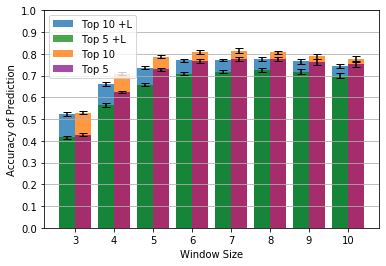

In [75]:
fig, ax = plt.subplots()
ax.bar(Results_lemmatize.index.values, Results_lemmatize['Predicted_top10_mean'].values, yerr=Results_lemmatize['Predicted_top10_std'].values, width=-0.4, align='edge', alpha=0.8, ecolor='black', capsize=4,  label='Top 10 +L')
ax.bar(Results_lemmatize.index.values, Results_lemmatize['Predicted_top5_mean'].values, yerr=Results_lemmatize['Predicted_top5_std'].values, color='green', width=-0.4, align='edge', alpha=0.7, ecolor='black', capsize=4, label='Top 5 +L')
ax.bar(Results_Nolemmatize.index.values, Results_Nolemmatize['Predicted_top10_mean'].values, yerr=Results_Nolemmatize['Predicted_top10_std'].values, width=0.4, align='edge', alpha=0.8, ecolor='black', capsize=4,  label='Top 10')
ax.bar(Results_Nolemmatize.index.values, Results_Nolemmatize['Predicted_top5_mean'].values, yerr=Results_Nolemmatize['Predicted_top5_std'].values, color='purple', width=0.4, align='edge', alpha=0.7, ecolor='black', capsize=4, label='Top 5')
ax.set_ylabel('Accuracy of Prediction')
ax.set_xlabel('Window Size')
ax.set_xticks(Results_lemmatize.index.values)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.yaxis.grid(True)
ax.legend()
plt.savefig(category+'-bars.pdf', dpi=500, bbox_inches='tight')

### Taking a look at the predicted probabilities of the best setup:

In [252]:
lemmatize = False
window = 7

# Building the corpus
corpus = Corpus(meta = 'Corpus BBC '+category+' News, only verbs as target, no stopwords.')
import_bbc_folder(category,corpus , lemmatize = lemmatize)

# Building the dataset
sentences , verbs = Build_Dataset([category], corpus, window, one_hot=True , lemmatize=lemmatize)

# Getting the train_valid_test data:
x_train, x_test, y_train, y_test = train_test_split(sentences, verbs, test_size=0.1, random_state=123)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=123)

# Building the model
vocab_size = len(corpus.get_vocabs_to_learn())
verbs_size = len(corpus.get_verbs_to_learn())
hidden_dim = 500

model = CBOW(vocab_size, hidden_dim, verbs_size)
model.cuda()

# Training the model
lr=0.001
batch_size = 512
n_epochs = 20
file_name = 'CBOW_BBC'+category+'_window='+str(window)+'_forevaluation.pt'

train_losses, valid_losses = Train_model(model, lr, batch_size, n_epochs, file_name, x_train, y_train, x_valid, y_valid)

# Loading the best model parameters
model.load_state_dict(torch.load(file_name))

Epoch: 1 	Training Loss: 6.347361 	Validation Loss: 5.038537
Validation loss decreased (inf --> 5.03854).  Saving model ...
Epoch: 2 	Training Loss: 5.516086 	Validation Loss: 4.754287
Validation loss decreased (5.03854 --> 4.75429).  Saving model ...
Epoch: 3 	Training Loss: 4.984180 	Validation Loss: 4.377631
Validation loss decreased (4.75429 --> 4.37763).  Saving model ...
Epoch: 4 	Training Loss: 4.282314 	Validation Loss: 3.930652
Validation loss decreased (4.37763 --> 3.93065).  Saving model ...
Epoch: 5 	Training Loss: 3.482899 	Validation Loss: 3.489529
Validation loss decreased (3.93065 --> 3.48953).  Saving model ...
Epoch: 6 	Training Loss: 2.720307 	Validation Loss: 3.110157
Validation loss decreased (3.48953 --> 3.11016).  Saving model ...
Epoch: 7 	Training Loss: 2.089990 	Validation Loss: 2.811416
Validation loss decreased (3.11016 --> 2.81142).  Saving model ...
Epoch: 8 	Training Loss: 1.607737 	Validation Loss: 2.588077
Validation loss decreased (2.81142 --> 2.58808)

<All keys matched successfully>

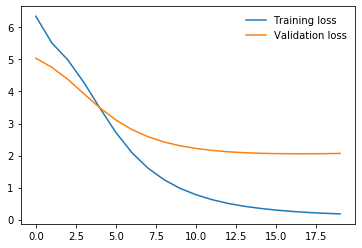

In [253]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(valid_losses, label = 'Validation loss')
plt.legend(frameon=False)

Looking into a sample of predictions:

In [254]:
getbatch = iter(get_batch(x_test, y_test , 16))
sentences, verbs = next(getbatch)

In [255]:
model.eval()
output = model(sentences.cuda().float())
ps = torch.exp(output)
top_p, top_class = ps.topk(10, dim=1)

In [256]:
for clas, t in zip(top_class, verbs):
    print(corpus.get_verb_from_index(t.item()) , ': ')
    print('\t' ,  end='' )
    for val in clas:
        print(corpus.get_verb_from_index(val.item()), end='\t' )
    print()

band
	band	album	beat	sees	moved	said	came	hit	back	charts	
starring
	starring	hit	gone	straight	direct	finding	recording	co-wrote	said	shown	
dance
	dance	acknowledged	going	stars	album	released	played	taking	picked	work	
slipped
	slipped	fell	taking	chart	finished	entered	went	take	took	nominated	
chart
	chart	best	top	band	host	track	return	involved	fell	developing	
plays
	said	plays	stars	think	expected	show	live	nominated	want	following	
coming
	said	top	band	back	take	perform	turned	live	brought	appear	
filled
	show	hosting	aged	filled	best	lead	host	got	died	drama	
home
	attend	earn	falls	receive	home	according	face	greeted	using	fetch	
went
	went	lead	hope	drama	becomes	beating	best	include	taking	playing	
receive
	receive	singer	feature	created	recorded	top	album	leading	used	perform	
topped
	topped	top	opening	topping	record	chart	seek	biopic	meet	described	
thanked
	taking	thank	best	legend	estimated	took	attended	holds	told	expected	
best
	recognise	best	showed	used	playing

In [91]:
i = 1
sent = np.where(np.array(sentences[i]) != 0)[0]
corpus.get_vocab_from_index(sent.tolist())

['julia', 'sequel', 'george', 'clooney', 'brad', 'pitt']

In [92]:
probs = top_p[i].tolist()
vrbs = corpus.get_verb_from_index(top_class[i].tolist())

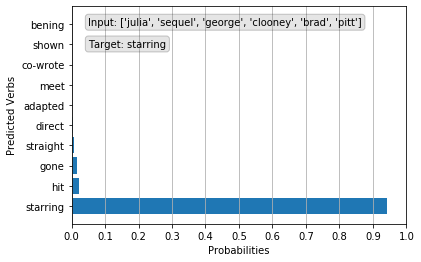

In [94]:
fig, ax = plt.subplots()
props = dict(boxstyle='round', facecolor='grey', alpha=0.2)
ax.text(0.05, 0.95, 'Input: '+str(corpus.get_vocab_from_index(sent.tolist())), transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
ax.text(0.05, 0.85, 'Target: '+corpus.get_verb_from_index(verbs[i].item()), transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
ax.barh(vrbs, probs, align='center')
plt.xlabel('Probabilities')
plt.ylabel('Predicted Verbs')
ax.set_xticks(np.arange(0,1.1,0.1))
ax.xaxis.grid(True)
plt.savefig(category+'-probs.pdf', dpi=500, bbox_inches='tight')
plt.show()

### 3- Obtaining prediction results when learning the verbs in politics articles:

In [77]:
category = 'politics'

In [78]:
# Preparing the results dataframes:
windows = list(range(3,11))
columns = ['Predicted_top5_mean', 'Predicted_top5_std', 'Predicted_top10_mean', 'Predicted_top10_std']
Results_Nolemmatize = pd.DataFrame(index=index, columns=columns)
Results_lemmatize = pd.DataFrame(index=index, columns=columns)

# Getting some results:
for lemmatize in [False , True]:
    
    # Building the corpus
    corpus = Corpus(meta = 'Corpus BBC '+category+' News, only verbs as target, no stopwords.')
    import_bbc_folder(category,corpus , lemmatize = lemmatize)
    
    for window in windows:
                
        # Building the dataset:
        sentences , verbs = Build_Dataset([category], corpus, window, one_hot=True , lemmatize=lemmatize)
        
        print('\n Starting:...-> Lemmatize =',lemmatize,', window =', window , '\n')
        
        lr=0.001
        batch_size = 512
        n_epochs = 20
        file_name = 'CBOW_BBC_'+category+'_lemmatize='+str(lemmatize)+'_window='+str(window)+'_crossval.pt'
        random_state = 123
        K = 10
        
        # Cross validating the model:
        training_losses, validation_losses, predicted_intop5, predicted_intop10 = K_fold_Cross_validate(K , sentences , verbs,
                                                                                                corpus, lr,batch_size ,n_epochs,
                                                                                                file_name, random_state)
        
        # Getting the prediction measures mean and standard deviation:
        predicted_intop5_mean , predicted_intop5_std  = np.mean(predicted_intop5) , np.std(predicted_intop5)
        predicted_intop10_mean , predicted_intop10_std  = np.mean(predicted_intop10) , np.std(predicted_intop10)
        
        # Adding the measures to the corresponding dataframe:
        if lemmatize:
            Results_lemmatize.loc[window , 'Predicted_top5_mean'] = predicted_intop5_mean
            Results_lemmatize.loc[window , 'Predicted_top5_std'] = predicted_intop5_std
            Results_lemmatize.loc[window , 'Predicted_top10_mean'] = predicted_intop10_mean
            Results_lemmatize.loc[window , 'Predicted_top10_std'] = predicted_intop10_std
        else:
            Results_Nolemmatize.loc[window , 'Predicted_top5_mean'] = predicted_intop5_mean
            Results_Nolemmatize.loc[window , 'Predicted_top5_std'] = predicted_intop5_std
            Results_Nolemmatize.loc[window , 'Predicted_top10_mean'] = predicted_intop10_mean
            Results_Nolemmatize.loc[window , 'Predicted_top10_std'] = predicted_intop10_std
        


 Starting:...-> Lemmatize = False , window = 3 

Epoch: 1 	Training Loss: 6.602493 	Validation Loss: 5.757103
Validation loss decreased (inf --> 5.75710).  Saving model ...
Epoch: 2 	Training Loss: 6.079985 	Validation Loss: 5.635481
Validation loss decreased (5.75710 --> 5.63548).  Saving model ...
Epoch: 3 	Training Loss: 5.837566 	Validation Loss: 5.477341
Validation loss decreased (5.63548 --> 5.47734).  Saving model ...
Epoch: 4 	Training Loss: 5.493571 	Validation Loss: 5.282194
Validation loss decreased (5.47734 --> 5.28219).  Saving model ...
Epoch: 5 	Training Loss: 5.053437 	Validation Loss: 5.071109
Validation loss decreased (5.28219 --> 5.07111).  Saving model ...
Epoch: 6 	Training Loss: 4.559289 	Validation Loss: 4.874638
Validation loss decreased (5.07111 --> 4.87464).  Saving model ...
Epoch: 7 	Training Loss: 4.062730 	Validation Loss: 4.710167
Validation loss decreased (4.87464 --> 4.71017).  Saving model ...
Epoch: 8 	Training Loss: 3.601697 	Validation Loss: 4.5867

Epoch: 20 	Training Loss: 1.601768 	Validation Loss: 4.623549
Epoch: 1 	Training Loss: 6.594622 	Validation Loss: 5.781842
Validation loss decreased (inf --> 5.78184).  Saving model ...
Epoch: 2 	Training Loss: 6.078552 	Validation Loss: 5.658045
Validation loss decreased (5.78184 --> 5.65804).  Saving model ...
Epoch: 3 	Training Loss: 5.838424 	Validation Loss: 5.493433
Validation loss decreased (5.65804 --> 5.49343).  Saving model ...
Epoch: 4 	Training Loss: 5.497876 	Validation Loss: 5.288123
Validation loss decreased (5.49343 --> 5.28812).  Saving model ...
Epoch: 5 	Training Loss: 5.061492 	Validation Loss: 5.070256
Validation loss decreased (5.28812 --> 5.07026).  Saving model ...
Epoch: 6 	Training Loss: 4.570103 	Validation Loss: 4.865751
Validation loss decreased (5.07026 --> 4.86575).  Saving model ...
Epoch: 7 	Training Loss: 4.072402 	Validation Loss: 4.696083
Validation loss decreased (4.86575 --> 4.69608).  Saving model ...
Epoch: 8 	Training Loss: 3.609546 	Validation 

Epoch: 18 	Training Loss: 1.699314 	Validation Loss: 4.509748
Epoch: 19 	Training Loss: 1.641925 	Validation Loss: 4.546141
Epoch: 20 	Training Loss: 1.595885 	Validation Loss: 4.581863
Epoch: 1 	Training Loss: 6.596967 	Validation Loss: 5.784535
Validation loss decreased (inf --> 5.78454).  Saving model ...
Epoch: 2 	Training Loss: 6.068922 	Validation Loss: 5.657826
Validation loss decreased (5.78454 --> 5.65783).  Saving model ...
Epoch: 3 	Training Loss: 5.827859 	Validation Loss: 5.485883
Validation loss decreased (5.65783 --> 5.48588).  Saving model ...
Epoch: 4 	Training Loss: 5.484680 	Validation Loss: 5.281949
Validation loss decreased (5.48588 --> 5.28195).  Saving model ...
Epoch: 5 	Training Loss: 5.047763 	Validation Loss: 5.067071
Validation loss decreased (5.28195 --> 5.06707).  Saving model ...
Epoch: 6 	Training Loss: 4.557560 	Validation Loss: 4.869753
Validation loss decreased (5.06707 --> 4.86975).  Saving model ...
Epoch: 7 	Training Loss: 4.062779 	Validation Loss

Epoch: 14 	Training Loss: 1.211197 	Validation Loss: 3.674615
Validation loss decreased (3.68472 --> 3.67462).  Saving model ...
Epoch: 15 	Training Loss: 1.114574 	Validation Loss: 3.675869
Epoch: 16 	Training Loss: 1.037335 	Validation Loss: 3.687251
Epoch: 17 	Training Loss: 0.971699 	Validation Loss: 3.703788
Epoch: 18 	Training Loss: 0.921084 	Validation Loss: 3.726976
Epoch: 19 	Training Loss: 0.876551 	Validation Loss: 3.752549
Epoch: 20 	Training Loss: 0.836548 	Validation Loss: 3.783338
Epoch: 1 	Training Loss: 6.576858 	Validation Loss: 6.193385
Validation loss decreased (inf --> 6.19338).  Saving model ...
Epoch: 2 	Training Loss: 5.992757 	Validation Loss: 5.958534
Validation loss decreased (6.19338 --> 5.95853).  Saving model ...
Epoch: 3 	Training Loss: 5.588002 	Validation Loss: 5.635980
Validation loss decreased (5.95853 --> 5.63598).  Saving model ...
Epoch: 4 	Training Loss: 5.015380 	Validation Loss: 5.249780
Validation loss decreased (5.63598 --> 5.24978).  Saving m

Epoch: 10 	Training Loss: 1.875973 	Validation Loss: 3.848878
Validation loss decreased (3.94493 --> 3.84888).  Saving model ...
Epoch: 11 	Training Loss: 1.642854 	Validation Loss: 3.782452
Validation loss decreased (3.84888 --> 3.78245).  Saving model ...
Epoch: 12 	Training Loss: 1.463762 	Validation Loss: 3.738858
Validation loss decreased (3.78245 --> 3.73886).  Saving model ...
Epoch: 13 	Training Loss: 1.320473 	Validation Loss: 3.716489
Validation loss decreased (3.73886 --> 3.71649).  Saving model ...
Epoch: 14 	Training Loss: 1.205529 	Validation Loss: 3.710430
Validation loss decreased (3.71649 --> 3.71043).  Saving model ...
Epoch: 15 	Training Loss: 1.114039 	Validation Loss: 3.713247
Epoch: 16 	Training Loss: 1.037506 	Validation Loss: 3.729185
Epoch: 17 	Training Loss: 0.971067 	Validation Loss: 3.747082
Epoch: 18 	Training Loss: 0.915217 	Validation Loss: 3.772375
Epoch: 19 	Training Loss: 0.870841 	Validation Loss: 3.803377
Epoch: 20 	Training Loss: 0.831505 	Validatio

Epoch: 7 	Training Loss: 3.056157 	Validation Loss: 4.317452
Validation loss decreased (4.57611 --> 4.31745).  Saving model ...
Epoch: 8 	Training Loss: 2.564634 	Validation Loss: 4.124655
Validation loss decreased (4.31745 --> 4.12465).  Saving model ...
Epoch: 9 	Training Loss: 2.173107 	Validation Loss: 3.987649
Validation loss decreased (4.12465 --> 3.98765).  Saving model ...
Epoch: 10 	Training Loss: 1.877831 	Validation Loss: 3.892618
Validation loss decreased (3.98765 --> 3.89262).  Saving model ...
Epoch: 11 	Training Loss: 1.647703 	Validation Loss: 3.829364
Validation loss decreased (3.89262 --> 3.82936).  Saving model ...
Epoch: 12 	Training Loss: 1.467404 	Validation Loss: 3.789169
Validation loss decreased (3.82936 --> 3.78917).  Saving model ...
Epoch: 13 	Training Loss: 1.326441 	Validation Loss: 3.769052
Validation loss decreased (3.78917 --> 3.76905).  Saving model ...
Epoch: 14 	Training Loss: 1.208436 	Validation Loss: 3.761675
Validation loss decreased (3.76905 -->

Epoch: 2 	Training Loss: 5.851379 	Validation Loss: 5.436335
Validation loss decreased (5.71749 --> 5.43633).  Saving model ...
Epoch: 3 	Training Loss: 5.317012 	Validation Loss: 5.039811
Validation loss decreased (5.43633 --> 5.03981).  Saving model ...
Epoch: 4 	Training Loss: 4.580626 	Validation Loss: 4.596670
Validation loss decreased (5.03981 --> 4.59667).  Saving model ...
Epoch: 5 	Training Loss: 3.781910 	Validation Loss: 4.184943
Validation loss decreased (4.59667 --> 4.18494).  Saving model ...
Epoch: 6 	Training Loss: 3.044090 	Validation Loss: 3.845764
Validation loss decreased (4.18494 --> 3.84576).  Saving model ...
Epoch: 7 	Training Loss: 2.435180 	Validation Loss: 3.588098
Validation loss decreased (3.84576 --> 3.58810).  Saving model ...
Epoch: 8 	Training Loss: 1.974136 	Validation Loss: 3.401104
Validation loss decreased (3.58810 --> 3.40110).  Saving model ...
Epoch: 9 	Training Loss: 1.630126 	Validation Loss: 3.264364
Validation loss decreased (3.40110 --> 3.26

Epoch: 14 	Training Loss: 0.792911 	Validation Loss: 2.929513
Validation loss decreased (2.94793 --> 2.92951).  Saving model ...
Epoch: 15 	Training Loss: 0.712665 	Validation Loss: 2.926174
Validation loss decreased (2.92951 --> 2.92617).  Saving model ...
Epoch: 16 	Training Loss: 0.649385 	Validation Loss: 2.930305
Epoch: 17 	Training Loss: 0.595443 	Validation Loss: 2.938882
Epoch: 18 	Training Loss: 0.550406 	Validation Loss: 2.954663
Epoch: 19 	Training Loss: 0.516114 	Validation Loss: 2.974927
Epoch: 20 	Training Loss: 0.483367 	Validation Loss: 2.999932
Epoch: 1 	Training Loss: 6.515128 	Validation Loss: 5.740471
Validation loss decreased (inf --> 5.74047).  Saving model ...
Epoch: 2 	Training Loss: 5.855952 	Validation Loss: 5.451816
Validation loss decreased (5.74047 --> 5.45182).  Saving model ...
Epoch: 3 	Training Loss: 5.325132 	Validation Loss: 5.035399
Validation loss decreased (5.45182 --> 5.03540).  Saving model ...
Epoch: 4 	Training Loss: 4.595398 	Validation Loss: 

Epoch: 9 	Training Loss: 1.370592 	Validation Loss: 2.853373
Validation loss decreased (2.98903 --> 2.85337).  Saving model ...
Epoch: 10 	Training Loss: 1.119505 	Validation Loss: 2.758869
Validation loss decreased (2.85337 --> 2.75887).  Saving model ...
Epoch: 11 	Training Loss: 0.931083 	Validation Loss: 2.694423
Validation loss decreased (2.75887 --> 2.69442).  Saving model ...
Epoch: 12 	Training Loss: 0.784744 	Validation Loss: 2.652266
Validation loss decreased (2.69442 --> 2.65227).  Saving model ...
Epoch: 13 	Training Loss: 0.667612 	Validation Loss: 2.629756
Validation loss decreased (2.65227 --> 2.62976).  Saving model ...
Epoch: 14 	Training Loss: 0.580692 	Validation Loss: 2.617136
Validation loss decreased (2.62976 --> 2.61714).  Saving model ...
Epoch: 15 	Training Loss: 0.509031 	Validation Loss: 2.615521
Validation loss decreased (2.61714 --> 2.61552).  Saving model ...
Epoch: 16 	Training Loss: 0.455527 	Validation Loss: 2.621366
Epoch: 17 	Training Loss: 0.411023 	

Epoch: 4 	Training Loss: 4.372788 	Validation Loss: 4.259867
Validation loss decreased (4.74992 --> 4.25987).  Saving model ...
Epoch: 5 	Training Loss: 3.515148 	Validation Loss: 3.825434
Validation loss decreased (4.25987 --> 3.82543).  Saving model ...
Epoch: 6 	Training Loss: 2.751199 	Validation Loss: 3.480658
Validation loss decreased (3.82543 --> 3.48066).  Saving model ...
Epoch: 7 	Training Loss: 2.144962 	Validation Loss: 3.223362
Validation loss decreased (3.48066 --> 3.22336).  Saving model ...
Epoch: 8 	Training Loss: 1.695264 	Validation Loss: 3.041387
Validation loss decreased (3.22336 --> 3.04139).  Saving model ...
Epoch: 9 	Training Loss: 1.366876 	Validation Loss: 2.908786
Validation loss decreased (3.04139 --> 2.90879).  Saving model ...
Epoch: 10 	Training Loss: 1.119688 	Validation Loss: 2.812321
Validation loss decreased (2.90879 --> 2.81232).  Saving model ...
Epoch: 11 	Training Loss: 0.927076 	Validation Loss: 2.746386
Validation loss decreased (2.81232 --> 2.

Epoch: 17 	Training Loss: 0.412835 	Validation Loss: 2.629611
Epoch: 18 	Training Loss: 0.375248 	Validation Loss: 2.643390
Epoch: 19 	Training Loss: 0.343529 	Validation Loss: 2.663854
Epoch: 20 	Training Loss: 0.319095 	Validation Loss: 2.682808
Epoch: 1 	Training Loss: 6.506066 	Validation Loss: 5.475199
Validation loss decreased (inf --> 5.47520).  Saving model ...
Epoch: 2 	Training Loss: 5.804558 	Validation Loss: 5.161728
Validation loss decreased (5.47520 --> 5.16173).  Saving model ...
Epoch: 3 	Training Loss: 5.198942 	Validation Loss: 4.725622
Validation loss decreased (5.16173 --> 4.72562).  Saving model ...
Epoch: 4 	Training Loss: 4.382887 	Validation Loss: 4.245787
Validation loss decreased (4.72562 --> 4.24579).  Saving model ...
Epoch: 5 	Training Loss: 3.527272 	Validation Loss: 3.820430
Validation loss decreased (4.24579 --> 3.82043).  Saving model ...
Epoch: 6 	Training Loss: 2.770095 	Validation Loss: 3.475663
Validation loss decreased (3.82043 --> 3.47566).  Savin

Epoch: 11 	Training Loss: 0.811586 	Validation Loss: 2.561643
Validation loss decreased (2.62760 --> 2.56164).  Saving model ...
Epoch: 12 	Training Loss: 0.667382 	Validation Loss: 2.513071
Validation loss decreased (2.56164 --> 2.51307).  Saving model ...
Epoch: 13 	Training Loss: 0.555653 	Validation Loss: 2.482648
Validation loss decreased (2.51307 --> 2.48265).  Saving model ...
Epoch: 14 	Training Loss: 0.468450 	Validation Loss: 2.470631
Validation loss decreased (2.48265 --> 2.47063).  Saving model ...
Epoch: 15 	Training Loss: 0.399949 	Validation Loss: 2.467933
Validation loss decreased (2.47063 --> 2.46793).  Saving model ...
Epoch: 16 	Training Loss: 0.351209 	Validation Loss: 2.470615
Epoch: 17 	Training Loss: 0.308476 	Validation Loss: 2.481799
Epoch: 18 	Training Loss: 0.274823 	Validation Loss: 2.494687
Epoch: 19 	Training Loss: 0.248562 	Validation Loss: 2.508074
Epoch: 20 	Training Loss: 0.227499 	Validation Loss: 2.523810
Epoch: 1 	Training Loss: 6.508945 	Validation

Epoch: 6 	Training Loss: 2.631936 	Validation Loss: 3.357261
Validation loss decreased (3.72042 --> 3.35726).  Saving model ...
Epoch: 7 	Training Loss: 2.027875 	Validation Loss: 3.089812
Validation loss decreased (3.35726 --> 3.08981).  Saving model ...
Epoch: 8 	Training Loss: 1.581246 	Validation Loss: 2.897419
Validation loss decreased (3.08981 --> 2.89742).  Saving model ...
Epoch: 9 	Training Loss: 1.250503 	Validation Loss: 2.758370
Validation loss decreased (2.89742 --> 2.75837).  Saving model ...
Epoch: 10 	Training Loss: 1.003826 	Validation Loss: 2.657016
Validation loss decreased (2.75837 --> 2.65702).  Saving model ...
Epoch: 11 	Training Loss: 0.816738 	Validation Loss: 2.586763
Validation loss decreased (2.65702 --> 2.58676).  Saving model ...
Epoch: 12 	Training Loss: 0.672192 	Validation Loss: 2.541777
Validation loss decreased (2.58676 --> 2.54178).  Saving model ...
Epoch: 13 	Training Loss: 0.558163 	Validation Loss: 2.515272
Validation loss decreased (2.54178 --> 

Epoch: 20 	Training Loss: 0.226722 	Validation Loss: 2.471178
Epoch: 1 	Training Loss: 6.511484 	Validation Loss: 5.425161
Validation loss decreased (inf --> 5.42516).  Saving model ...
Epoch: 2 	Training Loss: 5.773912 	Validation Loss: 5.097219
Validation loss decreased (5.42516 --> 5.09722).  Saving model ...
Epoch: 3 	Training Loss: 5.142662 	Validation Loss: 4.631896
Validation loss decreased (5.09722 --> 4.63190).  Saving model ...
Epoch: 4 	Training Loss: 4.300038 	Validation Loss: 4.124652
Validation loss decreased (4.63190 --> 4.12465).  Saving model ...
Epoch: 5 	Training Loss: 3.413617 	Validation Loss: 3.669662
Validation loss decreased (4.12465 --> 3.66966).  Saving model ...
Epoch: 6 	Training Loss: 2.634243 	Validation Loss: 3.307758
Validation loss decreased (3.66966 --> 3.30776).  Saving model ...
Epoch: 7 	Training Loss: 2.030540 	Validation Loss: 3.038573
Validation loss decreased (3.30776 --> 3.03857).  Saving model ...
Epoch: 8 	Training Loss: 1.584622 	Validation 

Epoch: 12 	Training Loss: 0.631955 	Validation Loss: 2.496216
Validation loss decreased (2.54014 --> 2.49622).  Saving model ...
Epoch: 13 	Training Loss: 0.514932 	Validation Loss: 2.467693
Validation loss decreased (2.49622 --> 2.46769).  Saving model ...
Epoch: 14 	Training Loss: 0.427954 	Validation Loss: 2.453537
Validation loss decreased (2.46769 --> 2.45354).  Saving model ...
Epoch: 15 	Training Loss: 0.359690 	Validation Loss: 2.452955
Validation loss decreased (2.45354 --> 2.45295).  Saving model ...
Epoch: 16 	Training Loss: 0.309330 	Validation Loss: 2.455353
Epoch: 17 	Training Loss: 0.266157 	Validation Loss: 2.462115
Epoch: 18 	Training Loss: 0.237241 	Validation Loss: 2.474634
Epoch: 19 	Training Loss: 0.210581 	Validation Loss: 2.488472
Epoch: 20 	Training Loss: 0.192263 	Validation Loss: 2.502761
Epoch: 1 	Training Loss: 6.605650 	Validation Loss: 5.448924
Validation loss decreased (inf --> 5.44892).  Saving model ...
Epoch: 2 	Training Loss: 5.820345 	Validation Loss

Epoch: 7 	Training Loss: 2.049189 	Validation Loss: 3.091932
Validation loss decreased (3.35575 --> 3.09193).  Saving model ...
Epoch: 8 	Training Loss: 1.588336 	Validation Loss: 2.901727
Validation loss decreased (3.09193 --> 2.90173).  Saving model ...
Epoch: 9 	Training Loss: 1.242647 	Validation Loss: 2.764516
Validation loss decreased (2.90173 --> 2.76452).  Saving model ...
Epoch: 10 	Training Loss: 0.985222 	Validation Loss: 2.662628
Validation loss decreased (2.76452 --> 2.66263).  Saving model ...
Epoch: 11 	Training Loss: 0.788049 	Validation Loss: 2.587396
Validation loss decreased (2.66263 --> 2.58740).  Saving model ...
Epoch: 12 	Training Loss: 0.628752 	Validation Loss: 2.538939
Validation loss decreased (2.58740 --> 2.53894).  Saving model ...
Epoch: 13 	Training Loss: 0.511725 	Validation Loss: 2.508072
Validation loss decreased (2.53894 --> 2.50807).  Saving model ...
Epoch: 14 	Training Loss: 0.429189 	Validation Loss: 2.491338
Validation loss decreased (2.50807 -->

Epoch: 20 	Training Loss: 0.183977 	Validation Loss: 2.530327

 Starting:...-> Lemmatize = False , window = 9 

Epoch: 1 	Training Loss: 6.592699 	Validation Loss: 5.347042
Validation loss decreased (inf --> 5.34704).  Saving model ...
Epoch: 2 	Training Loss: 5.785119 	Validation Loss: 5.047534
Validation loss decreased (5.34704 --> 5.04753).  Saving model ...
Epoch: 3 	Training Loss: 5.190874 	Validation Loss: 4.629550
Validation loss decreased (5.04753 --> 4.62955).  Saving model ...
Epoch: 4 	Training Loss: 4.389088 	Validation Loss: 4.156015
Validation loss decreased (4.62955 --> 4.15602).  Saving model ...
Epoch: 5 	Training Loss: 3.516571 	Validation Loss: 3.727236
Validation loss decreased (4.15602 --> 3.72724).  Saving model ...
Epoch: 6 	Training Loss: 2.731479 	Validation Loss: 3.386299
Validation loss decreased (3.72724 --> 3.38630).  Saving model ...
Epoch: 7 	Training Loss: 2.111972 	Validation Loss: 3.129750
Validation loss decreased (3.38630 --> 3.12975).  Saving model 

Epoch: 11 	Training Loss: 0.790301 	Validation Loss: 2.572068
Validation loss decreased (2.65589 --> 2.57207).  Saving model ...
Epoch: 12 	Training Loss: 0.628733 	Validation Loss: 2.516129
Validation loss decreased (2.57207 --> 2.51613).  Saving model ...
Epoch: 13 	Training Loss: 0.501491 	Validation Loss: 2.477472
Validation loss decreased (2.51613 --> 2.47747).  Saving model ...
Epoch: 14 	Training Loss: 0.409513 	Validation Loss: 2.454414
Validation loss decreased (2.47747 --> 2.45441).  Saving model ...
Epoch: 15 	Training Loss: 0.336489 	Validation Loss: 2.442046
Validation loss decreased (2.45441 --> 2.44205).  Saving model ...
Epoch: 16 	Training Loss: 0.282012 	Validation Loss: 2.437975
Validation loss decreased (2.44205 --> 2.43798).  Saving model ...
Epoch: 17 	Training Loss: 0.243159 	Validation Loss: 2.440857
Epoch: 18 	Training Loss: 0.210985 	Validation Loss: 2.449254
Epoch: 19 	Training Loss: 0.185622 	Validation Loss: 2.456766
Epoch: 20 	Training Loss: 0.165467 	Vali

Epoch: 3 	Training Loss: 5.188859 	Validation Loss: 4.690429
Validation loss decreased (5.10099 --> 4.69043).  Saving model ...
Epoch: 4 	Training Loss: 4.388584 	Validation Loss: 4.215418
Validation loss decreased (4.69043 --> 4.21542).  Saving model ...
Epoch: 5 	Training Loss: 3.515196 	Validation Loss: 3.778765
Validation loss decreased (4.21542 --> 3.77877).  Saving model ...
Epoch: 6 	Training Loss: 2.728667 	Validation Loss: 3.427723
Validation loss decreased (3.77877 --> 3.42772).  Saving model ...
Epoch: 7 	Training Loss: 2.106199 	Validation Loss: 3.166251
Validation loss decreased (3.42772 --> 3.16625).  Saving model ...
Epoch: 8 	Training Loss: 1.631887 	Validation Loss: 2.979021
Validation loss decreased (3.16625 --> 2.97902).  Saving model ...
Epoch: 9 	Training Loss: 1.275022 	Validation Loss: 2.840807
Validation loss decreased (2.97902 --> 2.84081).  Saving model ...
Epoch: 10 	Training Loss: 1.003335 	Validation Loss: 2.740727
Validation loss decreased (2.84081 --> 2.7

Epoch: 14 	Training Loss: 0.439943 	Validation Loss: 2.657706
Validation loss decreased (2.67754 --> 2.65771).  Saving model ...
Epoch: 15 	Training Loss: 0.359033 	Validation Loss: 2.649060
Validation loss decreased (2.65771 --> 2.64906).  Saving model ...
Epoch: 16 	Training Loss: 0.298126 	Validation Loss: 2.646435
Validation loss decreased (2.64906 --> 2.64644).  Saving model ...
Epoch: 17 	Training Loss: 0.250080 	Validation Loss: 2.653567
Epoch: 18 	Training Loss: 0.215407 	Validation Loss: 2.662542
Epoch: 19 	Training Loss: 0.189605 	Validation Loss: 2.669652
Epoch: 20 	Training Loss: 0.166304 	Validation Loss: 2.684119
Epoch: 1 	Training Loss: 6.643596 	Validation Loss: 5.251075
Validation loss decreased (inf --> 5.25108).  Saving model ...
Epoch: 2 	Training Loss: 5.806112 	Validation Loss: 4.986092
Validation loss decreased (5.25108 --> 4.98609).  Saving model ...
Epoch: 3 	Training Loss: 5.262002 	Validation Loss: 4.619447
Validation loss decreased (4.98609 --> 4.61945).  Sa

Epoch: 6 	Training Loss: 2.923057 	Validation Loss: 3.486053
Validation loss decreased (3.80952 --> 3.48605).  Saving model ...
Epoch: 7 	Training Loss: 2.274847 	Validation Loss: 3.237571
Validation loss decreased (3.48605 --> 3.23757).  Saving model ...
Epoch: 8 	Training Loss: 1.774833 	Validation Loss: 3.054244
Validation loss decreased (3.23757 --> 3.05424).  Saving model ...
Epoch: 9 	Training Loss: 1.390527 	Validation Loss: 2.918096
Validation loss decreased (3.05424 --> 2.91810).  Saving model ...
Epoch: 10 	Training Loss: 1.094655 	Validation Loss: 2.817432
Validation loss decreased (2.91810 --> 2.81743).  Saving model ...
Epoch: 11 	Training Loss: 0.863609 	Validation Loss: 2.744345
Validation loss decreased (2.81743 --> 2.74434).  Saving model ...
Epoch: 12 	Training Loss: 0.681347 	Validation Loss: 2.689226
Validation loss decreased (2.74434 --> 2.68923).  Saving model ...
Epoch: 13 	Training Loss: 0.540774 	Validation Loss: 2.656557
Validation loss decreased (2.68923 --> 

Epoch: 16 	Training Loss: 0.295347 	Validation Loss: 2.617561
Validation loss decreased (2.62110 --> 2.61756).  Saving model ...
Epoch: 17 	Training Loss: 0.248324 	Validation Loss: 2.617240
Validation loss decreased (2.61756 --> 2.61724).  Saving model ...
Epoch: 18 	Training Loss: 0.213651 	Validation Loss: 2.624421
Epoch: 19 	Training Loss: 0.185710 	Validation Loss: 2.630336
Epoch: 20 	Training Loss: 0.166214 	Validation Loss: 2.641747
Epoch: 1 	Training Loss: 6.652801 	Validation Loss: 5.183889
Validation loss decreased (inf --> 5.18389).  Saving model ...
Epoch: 2 	Training Loss: 5.821271 	Validation Loss: 4.933357
Validation loss decreased (5.18389 --> 4.93336).  Saving model ...
Epoch: 3 	Training Loss: 5.275359 	Validation Loss: 4.592891
Validation loss decreased (4.93336 --> 4.59289).  Saving model ...
Epoch: 4 	Training Loss: 4.542557 	Validation Loss: 4.184697
Validation loss decreased (4.59289 --> 4.18470).  Saving model ...
Epoch: 5 	Training Loss: 3.714281 	Validation Lo

Epoch: 11 	Training Loss: 2.788909 	Validation Loss: 4.309131
Validation loss decreased (4.31475 --> 4.30913).  Saving model ...
Epoch: 12 	Training Loss: 2.632560 	Validation Loss: 4.313741
Epoch: 13 	Training Loss: 2.504729 	Validation Loss: 4.327376
Epoch: 14 	Training Loss: 2.399368 	Validation Loss: 4.346951
Epoch: 15 	Training Loss: 2.314586 	Validation Loss: 4.369634
Epoch: 16 	Training Loss: 2.241797 	Validation Loss: 4.395668
Epoch: 17 	Training Loss: 2.181868 	Validation Loss: 4.424498
Epoch: 18 	Training Loss: 2.130760 	Validation Loss: 4.453602
Epoch: 19 	Training Loss: 2.086983 	Validation Loss: 4.485979
Epoch: 20 	Training Loss: 2.048886 	Validation Loss: 4.518352
Epoch: 1 	Training Loss: 6.060440 	Validation Loss: 5.398031
Validation loss decreased (inf --> 5.39803).  Saving model ...
Epoch: 2 	Training Loss: 5.554639 	Validation Loss: 5.261236
Validation loss decreased (5.39803 --> 5.26124).  Saving model ...
Epoch: 3 	Training Loss: 5.310211 	Validation Loss: 5.088587


Epoch: 16 	Training Loss: 2.252162 	Validation Loss: 4.274091
Epoch: 17 	Training Loss: 2.190393 	Validation Loss: 4.299767
Epoch: 18 	Training Loss: 2.139206 	Validation Loss: 4.327450
Epoch: 19 	Training Loss: 2.095249 	Validation Loss: 4.356952
Epoch: 20 	Training Loss: 2.056545 	Validation Loss: 4.388593
Epoch: 1 	Training Loss: 6.057470 	Validation Loss: 5.409010
Validation loss decreased (inf --> 5.40901).  Saving model ...
Epoch: 2 	Training Loss: 5.555004 	Validation Loss: 5.269162
Validation loss decreased (5.40901 --> 5.26916).  Saving model ...
Epoch: 3 	Training Loss: 5.305924 	Validation Loss: 5.094741
Validation loss decreased (5.26916 --> 5.09474).  Saving model ...
Epoch: 4 	Training Loss: 4.981891 	Validation Loss: 4.908140
Validation loss decreased (5.09474 --> 4.90814).  Saving model ...
Epoch: 5 	Training Loss: 4.600681 	Validation Loss: 4.724093
Validation loss decreased (4.90814 --> 4.72409).  Saving model ...
Epoch: 6 	Training Loss: 4.200200 	Validation Loss: 4.

Epoch: 1 	Training Loss: 6.001582 	Validation Loss: 5.227203
Validation loss decreased (inf --> 5.22720).  Saving model ...
Epoch: 2 	Training Loss: 5.442060 	Validation Loss: 5.011028
Validation loss decreased (5.22720 --> 5.01103).  Saving model ...
Epoch: 3 	Training Loss: 5.051725 	Validation Loss: 4.741380
Validation loss decreased (5.01103 --> 4.74138).  Saving model ...
Epoch: 4 	Training Loss: 4.550277 	Validation Loss: 4.460421
Validation loss decreased (4.74138 --> 4.46042).  Saving model ...
Epoch: 5 	Training Loss: 4.007420 	Validation Loss: 4.211595
Validation loss decreased (4.46042 --> 4.21159).  Saving model ...
Epoch: 6 	Training Loss: 3.493914 	Validation Loss: 4.015605
Validation loss decreased (4.21159 --> 4.01561).  Saving model ...
Epoch: 7 	Training Loss: 3.055130 	Validation Loss: 3.870418
Validation loss decreased (4.01561 --> 3.87042).  Saving model ...
Epoch: 8 	Training Loss: 2.699114 	Validation Loss: 3.766541
Validation loss decreased (3.87042 --> 3.76654)

Epoch: 18 	Training Loss: 1.385524 	Validation Loss: 3.622333
Epoch: 19 	Training Loss: 1.339248 	Validation Loss: 3.644580
Epoch: 20 	Training Loss: 1.298734 	Validation Loss: 3.672305
Epoch: 1 	Training Loss: 5.984845 	Validation Loss: 5.252504
Validation loss decreased (inf --> 5.25250).  Saving model ...
Epoch: 2 	Training Loss: 5.434978 	Validation Loss: 5.039206
Validation loss decreased (5.25250 --> 5.03921).  Saving model ...
Epoch: 3 	Training Loss: 5.052935 	Validation Loss: 4.763868
Validation loss decreased (5.03921 --> 4.76387).  Saving model ...
Epoch: 4 	Training Loss: 4.555809 	Validation Loss: 4.468674
Validation loss decreased (4.76387 --> 4.46867).  Saving model ...
Epoch: 5 	Training Loss: 4.011554 	Validation Loss: 4.210672
Validation loss decreased (4.46867 --> 4.21067).  Saving model ...
Epoch: 6 	Training Loss: 3.500109 	Validation Loss: 4.008005
Validation loss decreased (4.21067 --> 4.00801).  Saving model ...
Epoch: 7 	Training Loss: 3.061686 	Validation Loss

Epoch: 15 	Training Loss: 1.562105 	Validation Loss: 3.578940
Epoch: 16 	Training Loss: 1.492785 	Validation Loss: 3.592496
Epoch: 17 	Training Loss: 1.429093 	Validation Loss: 3.610846
Epoch: 18 	Training Loss: 1.380280 	Validation Loss: 3.629347
Epoch: 19 	Training Loss: 1.334066 	Validation Loss: 3.654851
Epoch: 20 	Training Loss: 1.295432 	Validation Loss: 3.684747
Epoch: 1 	Training Loss: 6.002129 	Validation Loss: 5.247319
Validation loss decreased (inf --> 5.24732).  Saving model ...
Epoch: 2 	Training Loss: 5.441111 	Validation Loss: 5.033817
Validation loss decreased (5.24732 --> 5.03382).  Saving model ...
Epoch: 3 	Training Loss: 5.056089 	Validation Loss: 4.760374
Validation loss decreased (5.03382 --> 4.76037).  Saving model ...
Epoch: 4 	Training Loss: 4.555835 	Validation Loss: 4.468806
Validation loss decreased (4.76037 --> 4.46881).  Saving model ...
Epoch: 5 	Training Loss: 4.012451 	Validation Loss: 4.213418
Validation loss decreased (4.46881 --> 4.21342).  Saving mo

Epoch: 13 	Training Loss: 1.296424 	Validation Loss: 3.370471
Validation loss decreased (3.37949 --> 3.37047).  Saving model ...
Epoch: 14 	Training Loss: 1.199493 	Validation Loss: 3.369902
Validation loss decreased (3.37047 --> 3.36990).  Saving model ...
Epoch: 15 	Training Loss: 1.118067 	Validation Loss: 3.379089
Epoch: 16 	Training Loss: 1.051006 	Validation Loss: 3.393110
Epoch: 17 	Training Loss: 0.992352 	Validation Loss: 3.412065
Epoch: 18 	Training Loss: 0.938962 	Validation Loss: 3.439238
Epoch: 19 	Training Loss: 0.898762 	Validation Loss: 3.464174
Epoch: 20 	Training Loss: 0.860432 	Validation Loss: 3.495196
Epoch: 1 	Training Loss: 5.956664 	Validation Loss: 5.495702
Validation loss decreased (inf --> 5.49570).  Saving model ...
Epoch: 2 	Training Loss: 5.342237 	Validation Loss: 5.198994
Validation loss decreased (5.49570 --> 5.19899).  Saving model ...
Epoch: 3 	Training Loss: 4.862377 	Validation Loss: 4.831705
Validation loss decreased (5.19899 --> 4.83171).  Saving 

Epoch: 10 	Training Loss: 1.741540 	Validation Loss: 3.398999
Validation loss decreased (3.46667 --> 3.39900).  Saving model ...
Epoch: 11 	Training Loss: 1.561724 	Validation Loss: 3.353251
Validation loss decreased (3.39900 --> 3.35325).  Saving model ...
Epoch: 12 	Training Loss: 1.419703 	Validation Loss: 3.324570
Validation loss decreased (3.35325 --> 3.32457).  Saving model ...
Epoch: 13 	Training Loss: 1.304996 	Validation Loss: 3.305555
Validation loss decreased (3.32457 --> 3.30555).  Saving model ...
Epoch: 14 	Training Loss: 1.203239 	Validation Loss: 3.300274
Validation loss decreased (3.30555 --> 3.30027).  Saving model ...
Epoch: 15 	Training Loss: 1.119525 	Validation Loss: 3.302441
Epoch: 16 	Training Loss: 1.053198 	Validation Loss: 3.309125
Epoch: 17 	Training Loss: 0.997165 	Validation Loss: 3.324840
Epoch: 18 	Training Loss: 0.944747 	Validation Loss: 3.341864
Epoch: 19 	Training Loss: 0.898986 	Validation Loss: 3.367007
Epoch: 20 	Training Loss: 0.860351 	Validatio

Epoch: 7 	Training Loss: 2.619075 	Validation Loss: 3.705757
Validation loss decreased (3.88564 --> 3.70576).  Saving model ...
Epoch: 8 	Training Loss: 2.255587 	Validation Loss: 3.577999
Validation loss decreased (3.70576 --> 3.57800).  Saving model ...
Epoch: 9 	Training Loss: 1.969028 	Validation Loss: 3.488615
Validation loss decreased (3.57800 --> 3.48862).  Saving model ...
Epoch: 10 	Training Loss: 1.745755 	Validation Loss: 3.424893
Validation loss decreased (3.48862 --> 3.42489).  Saving model ...
Epoch: 11 	Training Loss: 1.567220 	Validation Loss: 3.385337
Validation loss decreased (3.42489 --> 3.38534).  Saving model ...
Epoch: 12 	Training Loss: 1.422168 	Validation Loss: 3.360527
Validation loss decreased (3.38534 --> 3.36053).  Saving model ...
Epoch: 13 	Training Loss: 1.300819 	Validation Loss: 3.347697
Validation loss decreased (3.36053 --> 3.34770).  Saving model ...
Epoch: 14 	Training Loss: 1.207302 	Validation Loss: 3.345400
Validation loss decreased (3.34770 -->

Epoch: 3 	Training Loss: 4.783537 	Validation Loss: 4.672633
Validation loss decreased (5.07952 --> 4.67263).  Saving model ...
Epoch: 4 	Training Loss: 4.123041 	Validation Loss: 4.255236
Validation loss decreased (4.67263 --> 4.25524).  Saving model ...
Epoch: 5 	Training Loss: 3.447359 	Validation Loss: 3.901744
Validation loss decreased (4.25524 --> 3.90174).  Saving model ...
Epoch: 6 	Training Loss: 2.854540 	Validation Loss: 3.631396
Validation loss decreased (3.90174 --> 3.63140).  Saving model ...
Epoch: 7 	Training Loss: 2.373911 	Validation Loss: 3.434142
Validation loss decreased (3.63140 --> 3.43414).  Saving model ...
Epoch: 8 	Training Loss: 2.002276 	Validation Loss: 3.292103
Validation loss decreased (3.43414 --> 3.29210).  Saving model ...
Epoch: 9 	Training Loss: 1.714206 	Validation Loss: 3.189462
Validation loss decreased (3.29210 --> 3.18946).  Saving model ...
Epoch: 10 	Training Loss: 1.490599 	Validation Loss: 3.118197
Validation loss decreased (3.18946 --> 3.1

Epoch: 17 	Training Loss: 0.736171 	Validation Loss: 3.035098
Epoch: 18 	Training Loss: 0.689044 	Validation Loss: 3.056703
Epoch: 19 	Training Loss: 0.645951 	Validation Loss: 3.080313
Epoch: 20 	Training Loss: 0.609109 	Validation Loss: 3.111246
Epoch: 1 	Training Loss: 5.958264 	Validation Loss: 5.404293
Validation loss decreased (inf --> 5.40429).  Saving model ...
Epoch: 2 	Training Loss: 5.305842 	Validation Loss: 5.094259
Validation loss decreased (5.40429 --> 5.09426).  Saving model ...
Epoch: 3 	Training Loss: 4.776269 	Validation Loss: 4.689417
Validation loss decreased (5.09426 --> 4.68942).  Saving model ...
Epoch: 4 	Training Loss: 4.109057 	Validation Loss: 4.285061
Validation loss decreased (4.68942 --> 4.28506).  Saving model ...
Epoch: 5 	Training Loss: 3.434166 	Validation Loss: 3.942246
Validation loss decreased (4.28506 --> 3.94225).  Saving model ...
Epoch: 6 	Training Loss: 2.838163 	Validation Loss: 3.676313
Validation loss decreased (3.94225 --> 3.67631).  Savin

Epoch: 12 	Training Loss: 1.000173 	Validation Loss: 2.984873
Validation loss decreased (3.02106 --> 2.98487).  Saving model ...
Epoch: 13 	Training Loss: 0.872946 	Validation Loss: 2.963420
Validation loss decreased (2.98487 --> 2.96342).  Saving model ...
Epoch: 14 	Training Loss: 0.774619 	Validation Loss: 2.953843
Validation loss decreased (2.96342 --> 2.95384).  Saving model ...
Epoch: 15 	Training Loss: 0.689987 	Validation Loss: 2.952202
Validation loss decreased (2.95384 --> 2.95220).  Saving model ...
Epoch: 16 	Training Loss: 0.622757 	Validation Loss: 2.960538
Epoch: 17 	Training Loss: 0.565177 	Validation Loss: 2.973235
Epoch: 18 	Training Loss: 0.517507 	Validation Loss: 2.994395
Epoch: 19 	Training Loss: 0.475495 	Validation Loss: 3.015255
Epoch: 20 	Training Loss: 0.442620 	Validation Loss: 3.045866
Epoch: 1 	Training Loss: 5.957906 	Validation Loss: 5.457618
Validation loss decreased (inf --> 5.45762).  Saving model ...
Epoch: 2 	Training Loss: 5.279089 	Validation Loss

Epoch: 7 	Training Loss: 2.259185 	Validation Loss: 3.431954
Validation loss decreased (3.65234 --> 3.43195).  Saving model ...
Epoch: 8 	Training Loss: 1.872179 	Validation Loss: 3.268465
Validation loss decreased (3.43195 --> 3.26847).  Saving model ...
Epoch: 9 	Training Loss: 1.569875 	Validation Loss: 3.146210
Validation loss decreased (3.26847 --> 3.14621).  Saving model ...
Epoch: 10 	Training Loss: 1.334745 	Validation Loss: 3.056931
Validation loss decreased (3.14621 --> 3.05693).  Saving model ...
Epoch: 11 	Training Loss: 1.147039 	Validation Loss: 2.993505
Validation loss decreased (3.05693 --> 2.99350).  Saving model ...
Epoch: 12 	Training Loss: 0.993906 	Validation Loss: 2.952839
Validation loss decreased (2.99350 --> 2.95284).  Saving model ...
Epoch: 13 	Training Loss: 0.868503 	Validation Loss: 2.928936
Validation loss decreased (2.95284 --> 2.92894).  Saving model ...
Epoch: 14 	Training Loss: 0.771170 	Validation Loss: 2.919372
Validation loss decreased (2.92894 -->

Epoch: 2 	Training Loss: 5.284727 	Validation Loss: 5.118187
Validation loss decreased (5.43894 --> 5.11819).  Saving model ...
Epoch: 3 	Training Loss: 4.744340 	Validation Loss: 4.705053
Validation loss decreased (5.11819 --> 4.70505).  Saving model ...
Epoch: 4 	Training Loss: 4.061608 	Validation Loss: 4.280979
Validation loss decreased (4.70505 --> 4.28098).  Saving model ...
Epoch: 5 	Training Loss: 3.363444 	Validation Loss: 3.918647
Validation loss decreased (4.28098 --> 3.91865).  Saving model ...
Epoch: 6 	Training Loss: 2.749114 	Validation Loss: 3.637559
Validation loss decreased (3.91865 --> 3.63756).  Saving model ...
Epoch: 7 	Training Loss: 2.253420 	Validation Loss: 3.424952
Validation loss decreased (3.63756 --> 3.42495).  Saving model ...
Epoch: 8 	Training Loss: 1.864447 	Validation Loss: 3.267062
Validation loss decreased (3.42495 --> 3.26706).  Saving model ...
Epoch: 9 	Training Loss: 1.561452 	Validation Loss: 3.151037
Validation loss decreased (3.26706 --> 3.15

Epoch: 15 	Training Loss: 0.596226 	Validation Loss: 2.932477
Validation loss decreased (2.93751 --> 2.93248).  Saving model ...
Epoch: 16 	Training Loss: 0.522939 	Validation Loss: 2.939974
Epoch: 17 	Training Loss: 0.468391 	Validation Loss: 2.954835
Epoch: 18 	Training Loss: 0.419582 	Validation Loss: 2.968322
Epoch: 19 	Training Loss: 0.375117 	Validation Loss: 2.990252
Epoch: 20 	Training Loss: 0.344017 	Validation Loss: 3.014962
Epoch: 1 	Training Loss: 6.012833 	Validation Loss: 5.517867
Validation loss decreased (inf --> 5.51787).  Saving model ...
Epoch: 2 	Training Loss: 5.313182 	Validation Loss: 5.207750
Validation loss decreased (5.51787 --> 5.20775).  Saving model ...
Epoch: 3 	Training Loss: 4.779736 	Validation Loss: 4.800119
Validation loss decreased (5.20775 --> 4.80012).  Saving model ...
Epoch: 4 	Training Loss: 4.092192 	Validation Loss: 4.382438
Validation loss decreased (4.80012 --> 4.38244).  Saving model ...
Epoch: 5 	Training Loss: 3.383703 	Validation Loss: 4

Epoch: 10 	Training Loss: 1.275101 	Validation Loss: 3.020180
Validation loss decreased (3.11444 --> 3.02018).  Saving model ...
Epoch: 11 	Training Loss: 1.076066 	Validation Loss: 2.953948
Validation loss decreased (3.02018 --> 2.95395).  Saving model ...
Epoch: 12 	Training Loss: 0.915118 	Validation Loss: 2.908149
Validation loss decreased (2.95395 --> 2.90815).  Saving model ...
Epoch: 13 	Training Loss: 0.784986 	Validation Loss: 2.880772
Validation loss decreased (2.90815 --> 2.88077).  Saving model ...
Epoch: 14 	Training Loss: 0.677319 	Validation Loss: 2.864777
Validation loss decreased (2.88077 --> 2.86478).  Saving model ...
Epoch: 15 	Training Loss: 0.591314 	Validation Loss: 2.860641
Validation loss decreased (2.86478 --> 2.86064).  Saving model ...
Epoch: 16 	Training Loss: 0.520362 	Validation Loss: 2.863217
Epoch: 17 	Training Loss: 0.463143 	Validation Loss: 2.870560
Epoch: 18 	Training Loss: 0.414199 	Validation Loss: 2.886152
Epoch: 19 	Training Loss: 0.374747 	Vali

Epoch: 5 	Training Loss: 3.378842 	Validation Loss: 4.023484
Validation loss decreased (4.39223 --> 4.02348).  Saving model ...
Epoch: 6 	Training Loss: 2.754110 	Validation Loss: 3.728717
Validation loss decreased (4.02348 --> 3.72872).  Saving model ...
Epoch: 7 	Training Loss: 2.244128 	Validation Loss: 3.502862
Validation loss decreased (3.72872 --> 3.50286).  Saving model ...
Epoch: 8 	Training Loss: 1.845877 	Validation Loss: 3.329763
Validation loss decreased (3.50286 --> 3.32976).  Saving model ...
Epoch: 9 	Training Loss: 1.527116 	Validation Loss: 3.199086
Validation loss decreased (3.32976 --> 3.19909).  Saving model ...
Epoch: 10 	Training Loss: 1.278811 	Validation Loss: 3.102655
Validation loss decreased (3.19909 --> 3.10266).  Saving model ...
Epoch: 11 	Training Loss: 1.078702 	Validation Loss: 3.033012
Validation loss decreased (3.10266 --> 3.03301).  Saving model ...
Epoch: 12 	Training Loss: 0.917544 	Validation Loss: 2.984371
Validation loss decreased (3.03301 --> 2

Epoch: 16 	Training Loss: 0.466096 	Validation Loss: 2.529364
Epoch: 17 	Training Loss: 0.402582 	Validation Loss: 2.541089
Epoch: 18 	Training Loss: 0.357539 	Validation Loss: 2.556116
Epoch: 19 	Training Loss: 0.317711 	Validation Loss: 2.572178
Epoch: 20 	Training Loss: 0.287492 	Validation Loss: 2.592109
Epoch: 1 	Training Loss: 6.037843 	Validation Loss: 4.752257
Validation loss decreased (inf --> 4.75226).  Saving model ...
Epoch: 2 	Training Loss: 5.314086 	Validation Loss: 4.504449
Validation loss decreased (4.75226 --> 4.50445).  Saving model ...
Epoch: 3 	Training Loss: 4.813431 	Validation Loss: 4.179581
Validation loss decreased (4.50445 --> 4.17958).  Saving model ...
Epoch: 4 	Training Loss: 4.162142 	Validation Loss: 3.842660
Validation loss decreased (4.17958 --> 3.84266).  Saving model ...
Epoch: 5 	Training Loss: 3.475229 	Validation Loss: 3.543992
Validation loss decreased (3.84266 --> 3.54399).  Saving model ...
Epoch: 6 	Training Loss: 2.841486 	Validation Loss: 3.

Epoch: 11 	Training Loss: 1.062336 	Validation Loss: 2.665742
Validation loss decreased (2.72650 --> 2.66574).  Saving model ...
Epoch: 12 	Training Loss: 0.888182 	Validation Loss: 2.623089
Validation loss decreased (2.66574 --> 2.62309).  Saving model ...
Epoch: 13 	Training Loss: 0.746287 	Validation Loss: 2.595758
Validation loss decreased (2.62309 --> 2.59576).  Saving model ...
Epoch: 14 	Training Loss: 0.634879 	Validation Loss: 2.580642
Validation loss decreased (2.59576 --> 2.58064).  Saving model ...
Epoch: 15 	Training Loss: 0.538824 	Validation Loss: 2.577574
Validation loss decreased (2.58064 --> 2.57757).  Saving model ...
Epoch: 16 	Training Loss: 0.468762 	Validation Loss: 2.579954
Epoch: 17 	Training Loss: 0.407964 	Validation Loss: 2.587907
Epoch: 18 	Training Loss: 0.359864 	Validation Loss: 2.602940
Epoch: 19 	Training Loss: 0.316564 	Validation Loss: 2.619446
Epoch: 20 	Training Loss: 0.288263 	Validation Loss: 2.638075
Epoch: 1 	Training Loss: 6.039215 	Validation

Epoch: 5 	Training Loss: 3.619637 	Validation Loss: 3.511621
Validation loss decreased (3.81393 --> 3.51162).  Saving model ...
Epoch: 6 	Training Loss: 2.982598 	Validation Loss: 3.260003
Validation loss decreased (3.51162 --> 3.26000).  Saving model ...
Epoch: 7 	Training Loss: 2.435794 	Validation Loss: 3.058995
Validation loss decreased (3.26000 --> 3.05900).  Saving model ...
Epoch: 8 	Training Loss: 1.992717 	Validation Loss: 2.900537
Validation loss decreased (3.05900 --> 2.90054).  Saving model ...
Epoch: 9 	Training Loss: 1.631530 	Validation Loss: 2.777397
Validation loss decreased (2.90054 --> 2.77740).  Saving model ...
Epoch: 10 	Training Loss: 1.341316 	Validation Loss: 2.679424
Validation loss decreased (2.77740 --> 2.67942).  Saving model ...
Epoch: 11 	Training Loss: 1.103808 	Validation Loss: 2.605532
Validation loss decreased (2.67942 --> 2.60553).  Saving model ...
Epoch: 12 	Training Loss: 0.913239 	Validation Loss: 2.551673
Validation loss decreased (2.60553 --> 2

Epoch: 16 	Training Loss: 0.454700 	Validation Loss: 2.525743
Validation loss decreased (2.52726 --> 2.52574).  Saving model ...
Epoch: 17 	Training Loss: 0.391542 	Validation Loss: 2.533397
Epoch: 18 	Training Loss: 0.340013 	Validation Loss: 2.541823
Epoch: 19 	Training Loss: 0.297038 	Validation Loss: 2.554331
Epoch: 20 	Training Loss: 0.262306 	Validation Loss: 2.570964
Epoch: 1 	Training Loss: 6.139158 	Validation Loss: 4.625447
Validation loss decreased (inf --> 4.62545).  Saving model ...
Epoch: 2 	Training Loss: 5.392133 	Validation Loss: 4.406219
Validation loss decreased (4.62545 --> 4.40622).  Saving model ...
Epoch: 3 	Training Loss: 4.931888 	Validation Loss: 4.126392
Validation loss decreased (4.40622 --> 4.12639).  Saving model ...
Epoch: 4 	Training Loss: 4.319281 	Validation Loss: 3.807262
Validation loss decreased (4.12639 --> 3.80726).  Saving model ...
Epoch: 5 	Training Loss: 3.639569 	Validation Loss: 3.510553
Validation loss decreased (3.80726 --> 3.51055).  Savi

Epoch: 9 	Training Loss: 1.632121 	Validation Loss: 2.692589
Validation loss decreased (2.80450 --> 2.69259).  Saving model ...
Epoch: 10 	Training Loss: 1.341983 	Validation Loss: 2.609262
Validation loss decreased (2.69259 --> 2.60926).  Saving model ...
Epoch: 11 	Training Loss: 1.104759 	Validation Loss: 2.549848
Validation loss decreased (2.60926 --> 2.54985).  Saving model ...
Epoch: 12 	Training Loss: 0.914904 	Validation Loss: 2.506688
Validation loss decreased (2.54985 --> 2.50669).  Saving model ...
Epoch: 13 	Training Loss: 0.759535 	Validation Loss: 2.477704
Validation loss decreased (2.50669 --> 2.47770).  Saving model ...
Epoch: 14 	Training Loss: 0.634938 	Validation Loss: 2.461852
Validation loss decreased (2.47770 --> 2.46185).  Saving model ...
Epoch: 15 	Training Loss: 0.535738 	Validation Loss: 2.456907
Validation loss decreased (2.46185 --> 2.45691).  Saving model ...
Epoch: 16 	Training Loss: 0.452970 	Validation Loss: 2.458153
Epoch: 17 	Training Loss: 0.390974 	

In [79]:
with open(category+'results.pkl', 'wb') as f:
    pickle.dump((Results_lemmatize , Results_Nolemmatize),f)

In [80]:
with open(category+'results.pkl', 'rb') as f:
    Results_lemmatize , Results_Nolemmatize = pickle.load(f)

In [81]:
Results_lemmatize

,Predicted_top5_mean,Predicted_top5_std,Predicted_top10_mean,Predicted_top10_std
3,0.384446,0.00584364,0.480114,0.00479666
4,0.526349,0.00833504,0.619283,0.00644842
5,0.612305,0.00618104,0.694123,0.00515958
6,0.665215,0.00482422,0.732852,0.00221281
7,0.691819,0.00416808,0.752322,0.00425375
8,0.70505,0.00585067,0.753655,0.00549524
9,0.695736,0.00673922,0.740625,0.00687581
10,0.691719,0.00726563,0.733789,0.0061348


In [82]:
Results_Nolemmatize

,Predicted_top5_mean,Predicted_top5_std,Predicted_top10_mean,Predicted_top10_std
3,0.390059,0.00502864,0.478359,0.00396614
4,0.563406,0.00721434,0.648544,0.00670225
5,0.674492,0.00643536,0.741895,0.00528446
6,0.724132,0.00773605,0.774132,0.00570693
7,0.744727,0.00786284,0.784888,0.00619218
8,0.743136,0.00742229,0.777679,0.00757656
9,0.73444,0.00973498,0.766146,0.00950521
10,0.715078,0.0105457,0.744531,0.00825874


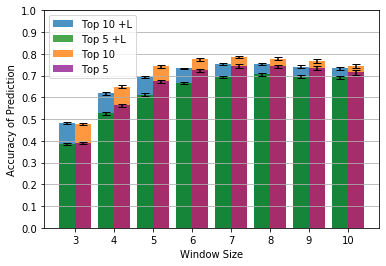

In [83]:
fig, ax = plt.subplots()
ax.bar(Results_lemmatize.index.values, Results_lemmatize['Predicted_top10_mean'].values, yerr=Results_lemmatize['Predicted_top10_std'].values, width=-0.4, align='edge', alpha=0.8, ecolor='black', capsize=4,  label='Top 10 +L')
ax.bar(Results_lemmatize.index.values, Results_lemmatize['Predicted_top5_mean'].values, yerr=Results_lemmatize['Predicted_top5_std'].values, color='green', width=-0.4, align='edge', alpha=0.7, ecolor='black', capsize=4, label='Top 5 +L')
ax.bar(Results_Nolemmatize.index.values, Results_Nolemmatize['Predicted_top10_mean'].values, yerr=Results_Nolemmatize['Predicted_top10_std'].values, width=0.4, align='edge', alpha=0.8, ecolor='black', capsize=4,  label='Top 10')
ax.bar(Results_Nolemmatize.index.values, Results_Nolemmatize['Predicted_top5_mean'].values, yerr=Results_Nolemmatize['Predicted_top5_std'].values, color='purple', width=0.4, align='edge', alpha=0.7, ecolor='black', capsize=4, label='Top 5')
ax.set_ylabel('Accuracy of Prediction')
ax.set_xlabel('Window Size')
ax.set_xticks(Results_lemmatize.index.values)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.yaxis.grid(True)
ax.legend()
plt.savefig(category+'-bars.pdf', dpi=500, bbox_inches='tight')

### Taking a look at the predicted probabilities of the best setup:

In [264]:
lemmatize = False
window = 7

# Building the corpus
corpus = Corpus(meta = 'Corpus BBC '+category+' News, only verbs as target, no stopwords.')
import_bbc_folder(category,corpus , lemmatize = lemmatize)

# Building the dataset
sentences , verbs = Build_Dataset([category], corpus, window, one_hot=True , lemmatize=lemmatize)

# Getting the train_valid_test data:
x_train, x_test, y_train, y_test = train_test_split(sentences, verbs, test_size=0.1, random_state=123)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=123)

# Building the model
vocab_size = len(corpus.get_vocabs_to_learn())
verbs_size = len(corpus.get_verbs_to_learn())
hidden_dim = 500

model = CBOW(vocab_size, hidden_dim, verbs_size)
model.cuda()

# Training the model
lr=0.001
batch_size = 512
n_epochs = 20
file_name = 'CBOW_BBC'+category+'_window='+str(window)+'_forevaluation.pt'

train_losses, valid_losses = Train_model(model, lr, batch_size, n_epochs, file_name, x_train, y_train, x_valid, y_valid)

# Loading the best model parameters
model.load_state_dict(torch.load(file_name))

Epoch: 1 	Training Loss: 6.507046 	Validation Loss: 5.458319
Validation loss decreased (inf --> 5.45832).  Saving model ...
Epoch: 2 	Training Loss: 5.774628 	Validation Loss: 5.137485
Validation loss decreased (5.45832 --> 5.13748).  Saving model ...
Epoch: 3 	Training Loss: 5.141758 	Validation Loss: 4.665634
Validation loss decreased (5.13748 --> 4.66563).  Saving model ...
Epoch: 4 	Training Loss: 4.280815 	Validation Loss: 4.150757
Validation loss decreased (4.66563 --> 4.15076).  Saving model ...
Epoch: 5 	Training Loss: 3.384668 	Validation Loss: 3.705372
Validation loss decreased (4.15076 --> 3.70537).  Saving model ...
Epoch: 6 	Training Loss: 2.612399 	Validation Loss: 3.358110
Validation loss decreased (3.70537 --> 3.35811).  Saving model ...
Epoch: 7 	Training Loss: 2.015650 	Validation Loss: 3.101007
Validation loss decreased (3.35811 --> 3.10101).  Saving model ...
Epoch: 8 	Training Loss: 1.575697 	Validation Loss: 2.915132
Validation loss decreased (3.10101 --> 2.91513)

<All keys matched successfully>

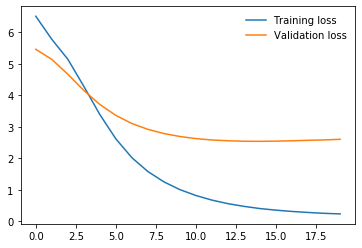

In [265]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(valid_losses, label = 'Validation loss')
plt.legend(frameon=False)

Looking into a sample of predictions:

In [266]:
getbatch = iter(get_batch(x_test, y_test , 16))
sentences, verbs = next(getbatch)

In [267]:
model.eval()
output = model(sentences.cuda().float())
ps = torch.exp(output)
top_p, top_class = ps.topk(10, dim=1)

In [268]:
for clas, t in zip(top_class, verbs):
    print(corpus.get_verb_from_index(t.item()) , ': ')
    print('\t' ,  end='' )
    for val in clas:
        print(corpus.get_verb_from_index(val.item()), end='\t' )
    print()

told
	said	told	done	debate	rest	defended	suggested	begin	comes	look	
asked
	say	says	get	spending	amounted	comment	sticking	planned	emerged	win	
downing
	downing	following	report	denied	criticised	warned	stressed	told	set	mean	
building
	undermine	find	make	get	start	found	abused	getting	set	stop	
broken
	broken	said	told	speaking	claims	meeting	making	rejected	refused	deal	
making
	telephoning	lists	labour	avoided	calling	making	signed	waiting	make	doubt	
close
	close	included	sign	represent	living	says	recommended	acknowledge	met	questioning	
rejected
	rejected	saw	right	reduced	saying	measures	published	introduce	amount	claims	
remain
	remain	offered	renewed	come	intervened	claims	predicted	stand	delivered	draw	
increase
	increase	labour	plan	needed	designed	expected	call	restore	backing	win	
said
	learned	making	made	make	said	insisted	get	expected	reached	stand	
labour
	labour	persuade	achieved	looming	think	fund	hopes	planning	go	appointed	
agree
	campaigning	become	sort	back	sa

In [104]:
i = 0
sent = np.where(np.array(sentences[i]) != 0)[0]
corpus.get_vocab_from_index(sent.tolist())

['commons', 'jack', 'straw', 'us', 'agreed', 'release']

In [106]:
probs = top_p[i].tolist()
vrbs = corpus.get_verb_from_index(top_class[i].tolist())

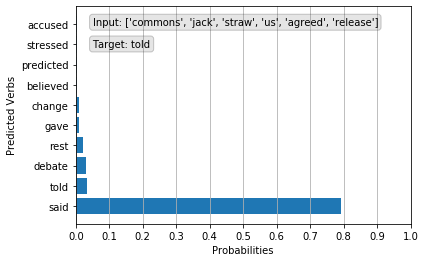

In [109]:
fig, ax = plt.subplots()
props = dict(boxstyle='round', facecolor='grey', alpha=0.2)
ax.text(0.05, 0.95, 'Input: '+str(corpus.get_vocab_from_index(sent.tolist())), transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
ax.text(0.05, 0.85, 'Target: '+corpus.get_verb_from_index(verbs[i].item()), transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
ax.barh(vrbs, probs, align='center')
plt.xlabel('Probabilities')
plt.ylabel('Predicted Verbs')
ax.set_xticks(np.arange(0,1.1,0.1))
ax.xaxis.grid(True)
plt.savefig(category+'-probs.pdf', dpi=500, bbox_inches='tight')
plt.show()

### 4- Obtaining prediction results when learning the verbs in sport articles:

In [84]:
category = 'sport'

In [85]:
# Preparing the results dataframes:
windows = list(range(3,11))
columns = ['Predicted_top5_mean', 'Predicted_top5_std', 'Predicted_top10_mean', 'Predicted_top10_std']
Results_Nolemmatize = pd.DataFrame(index=index, columns=columns)
Results_lemmatize = pd.DataFrame(index=index, columns=columns)

# Getting some results:
for lemmatize in [False , True]:
    
    # Building the corpus
    corpus = Corpus(meta = 'Corpus BBC '+category+' News, only verbs as target, no stopwords.')
    import_bbc_folder(category,corpus , lemmatize = lemmatize)
    
    for window in windows:
                
        # Building the dataset:
        sentences , verbs = Build_Dataset([category], corpus, window, one_hot=True , lemmatize=lemmatize)
        
        print('\n Starting:...-> Lemmatize =',lemmatize,', window =', window , '\n')
        
        lr=0.001
        batch_size = 512
        n_epochs = 20
        file_name = 'CBOW_BBC_'+category+'_lemmatize='+str(lemmatize)+'_window='+str(window)+'_crossval.pt'
        random_state = 123
        K = 10
        
        # Cross validating the model:
        training_losses, validation_losses, predicted_intop5, predicted_intop10 = K_fold_Cross_validate(K , sentences , verbs,
                                                                                                corpus, lr,batch_size ,n_epochs,
                                                                                                file_name, random_state)
        
        # Getting the prediction measures mean and standard deviation:
        predicted_intop5_mean , predicted_intop5_std  = np.mean(predicted_intop5) , np.std(predicted_intop5)
        predicted_intop10_mean , predicted_intop10_std  = np.mean(predicted_intop10) , np.std(predicted_intop10)
        
        # Adding the measures to the corresponding dataframe:
        if lemmatize:
            Results_lemmatize.loc[window , 'Predicted_top5_mean'] = predicted_intop5_mean
            Results_lemmatize.loc[window , 'Predicted_top5_std'] = predicted_intop5_std
            Results_lemmatize.loc[window , 'Predicted_top10_mean'] = predicted_intop10_mean
            Results_lemmatize.loc[window , 'Predicted_top10_std'] = predicted_intop10_std
        else:
            Results_Nolemmatize.loc[window , 'Predicted_top5_mean'] = predicted_intop5_mean
            Results_Nolemmatize.loc[window , 'Predicted_top5_std'] = predicted_intop5_std
            Results_Nolemmatize.loc[window , 'Predicted_top10_mean'] = predicted_intop10_mean
            Results_Nolemmatize.loc[window , 'Predicted_top10_std'] = predicted_intop10_std
        

bbc/sport\199.txt  had a problem
bbc/sport\199.txt  had a problem

 Starting:...-> Lemmatize = False , window = 3 

Epoch: 1 	Training Loss: 6.503159 	Validation Loss: 5.516802
Validation loss decreased (inf --> 5.51680).  Saving model ...
Epoch: 2 	Training Loss: 6.002865 	Validation Loss: 5.408037
Validation loss decreased (5.51680 --> 5.40804).  Saving model ...
Epoch: 3 	Training Loss: 5.788478 	Validation Loss: 5.253484
Validation loss decreased (5.40804 --> 5.25348).  Saving model ...
Epoch: 4 	Training Loss: 5.469777 	Validation Loss: 5.054372
Validation loss decreased (5.25348 --> 5.05437).  Saving model ...
Epoch: 5 	Training Loss: 5.060573 	Validation Loss: 4.848137
Validation loss decreased (5.05437 --> 4.84814).  Saving model ...
Epoch: 6 	Training Loss: 4.599783 	Validation Loss: 4.663158
Validation loss decreased (4.84814 --> 4.66316).  Saving model ...
Epoch: 7 	Training Loss: 4.130731 	Validation Loss: 4.511779
Validation loss decreased (4.66316 --> 4.51178).  Saving mo

Epoch: 19 	Training Loss: 1.630790 	Validation Loss: 4.389479
Epoch: 20 	Training Loss: 1.575731 	Validation Loss: 4.423532
Epoch: 1 	Training Loss: 6.511426 	Validation Loss: 5.536744
Validation loss decreased (inf --> 5.53674).  Saving model ...
Epoch: 2 	Training Loss: 5.999760 	Validation Loss: 5.438513
Validation loss decreased (5.53674 --> 5.43851).  Saving model ...
Epoch: 3 	Training Loss: 5.785919 	Validation Loss: 5.292811
Validation loss decreased (5.43851 --> 5.29281).  Saving model ...
Epoch: 4 	Training Loss: 5.472261 	Validation Loss: 5.101660
Validation loss decreased (5.29281 --> 5.10166).  Saving model ...
Epoch: 5 	Training Loss: 5.066582 	Validation Loss: 4.905209
Validation loss decreased (5.10166 --> 4.90521).  Saving model ...
Epoch: 6 	Training Loss: 4.607760 	Validation Loss: 4.729720
Validation loss decreased (4.90521 --> 4.72972).  Saving model ...
Epoch: 7 	Training Loss: 4.143534 	Validation Loss: 4.585755
Validation loss decreased (4.72972 --> 4.58576).  S

Epoch: 18 	Training Loss: 1.689148 	Validation Loss: 4.297832
Epoch: 19 	Training Loss: 1.628873 	Validation Loss: 4.329140
Epoch: 20 	Training Loss: 1.572278 	Validation Loss: 4.362075
Epoch: 1 	Training Loss: 6.506100 	Validation Loss: 5.522712
Validation loss decreased (inf --> 5.52271).  Saving model ...
Epoch: 2 	Training Loss: 6.004022 	Validation Loss: 5.419883
Validation loss decreased (5.52271 --> 5.41988).  Saving model ...
Epoch: 3 	Training Loss: 5.787334 	Validation Loss: 5.278086
Validation loss decreased (5.41988 --> 5.27809).  Saving model ...
Epoch: 4 	Training Loss: 5.468678 	Validation Loss: 5.090201
Validation loss decreased (5.27809 --> 5.09020).  Saving model ...
Epoch: 5 	Training Loss: 5.060212 	Validation Loss: 4.893157
Validation loss decreased (5.09020 --> 4.89316).  Saving model ...
Epoch: 6 	Training Loss: 4.602539 	Validation Loss: 4.711950
Validation loss decreased (4.89316 --> 4.71195).  Saving model ...
Epoch: 7 	Training Loss: 4.137863 	Validation Loss

Epoch: 14 	Training Loss: 1.256829 	Validation Loss: 3.501190
Validation loss decreased (3.50889 --> 3.50119).  Saving model ...
Epoch: 15 	Training Loss: 1.151502 	Validation Loss: 3.503302
Epoch: 16 	Training Loss: 1.056873 	Validation Loss: 3.514009
Epoch: 17 	Training Loss: 0.991092 	Validation Loss: 3.528372
Epoch: 18 	Training Loss: 0.927563 	Validation Loss: 3.549983
Epoch: 19 	Training Loss: 0.876268 	Validation Loss: 3.573579
Epoch: 20 	Training Loss: 0.829411 	Validation Loss: 3.602604
Epoch: 1 	Training Loss: 6.482304 	Validation Loss: 5.472974
Validation loss decreased (inf --> 5.47297).  Saving model ...
Epoch: 2 	Training Loss: 5.933061 	Validation Loss: 5.297021
Validation loss decreased (5.47297 --> 5.29702).  Saving model ...
Epoch: 3 	Training Loss: 5.570046 	Validation Loss: 5.034884
Validation loss decreased (5.29702 --> 5.03488).  Saving model ...
Epoch: 4 	Training Loss: 5.050521 	Validation Loss: 4.719244
Validation loss decreased (5.03488 --> 4.71924).  Saving m

Epoch: 11 	Training Loss: 1.755789 	Validation Loss: 3.503640
Validation loss decreased (3.56454 --> 3.50364).  Saving model ...
Epoch: 12 	Training Loss: 1.551622 	Validation Loss: 3.463841
Validation loss decreased (3.50364 --> 3.46384).  Saving model ...
Epoch: 13 	Training Loss: 1.387731 	Validation Loss: 3.440670
Validation loss decreased (3.46384 --> 3.44067).  Saving model ...
Epoch: 14 	Training Loss: 1.258354 	Validation Loss: 3.430684
Validation loss decreased (3.44067 --> 3.43068).  Saving model ...
Epoch: 15 	Training Loss: 1.151673 	Validation Loss: 3.430716
Epoch: 16 	Training Loss: 1.061907 	Validation Loss: 3.439545
Epoch: 17 	Training Loss: 0.990203 	Validation Loss: 3.454464
Epoch: 18 	Training Loss: 0.926698 	Validation Loss: 3.474563
Epoch: 19 	Training Loss: 0.874620 	Validation Loss: 3.496038
Epoch: 20 	Training Loss: 0.832099 	Validation Loss: 3.523427
Epoch: 1 	Training Loss: 6.488021 	Validation Loss: 5.463436
Validation loss decreased (inf --> 5.46344).  Savin

Epoch: 7 	Training Loss: 3.235051 	Validation Loss: 4.024913
Validation loss decreased (4.22717 --> 4.02491).  Saving model ...
Epoch: 8 	Training Loss: 2.738231 	Validation Loss: 3.871699
Validation loss decreased (4.02491 --> 3.87170).  Saving model ...
Epoch: 9 	Training Loss: 2.334575 	Validation Loss: 3.756489
Validation loss decreased (3.87170 --> 3.75649).  Saving model ...
Epoch: 10 	Training Loss: 2.009195 	Validation Loss: 3.672379
Validation loss decreased (3.75649 --> 3.67238).  Saving model ...
Epoch: 11 	Training Loss: 1.752782 	Validation Loss: 3.614456
Validation loss decreased (3.67238 --> 3.61446).  Saving model ...
Epoch: 12 	Training Loss: 1.549910 	Validation Loss: 3.577448
Validation loss decreased (3.61446 --> 3.57745).  Saving model ...
Epoch: 13 	Training Loss: 1.387404 	Validation Loss: 3.556853
Validation loss decreased (3.57745 --> 3.55685).  Saving model ...
Epoch: 14 	Training Loss: 1.253991 	Validation Loss: 3.549471
Validation loss decreased (3.55685 -->

Epoch: 2 	Training Loss: 5.847627 	Validation Loss: 5.603664
Validation loss decreased (5.84434 --> 5.60366).  Saving model ...
Epoch: 3 	Training Loss: 5.388114 	Validation Loss: 5.229800
Validation loss decreased (5.60366 --> 5.22980).  Saving model ...
Epoch: 4 	Training Loss: 4.734548 	Validation Loss: 4.797598
Validation loss decreased (5.22980 --> 4.79760).  Saving model ...
Epoch: 5 	Training Loss: 4.001418 	Validation Loss: 4.396634
Validation loss decreased (4.79760 --> 4.39663).  Saving model ...
Epoch: 6 	Training Loss: 3.293406 	Validation Loss: 4.056138
Validation loss decreased (4.39663 --> 4.05614).  Saving model ...
Epoch: 7 	Training Loss: 2.681263 	Validation Loss: 3.782597
Validation loss decreased (4.05614 --> 3.78260).  Saving model ...
Epoch: 8 	Training Loss: 2.181682 	Validation Loss: 3.572829
Validation loss decreased (3.78260 --> 3.57283).  Saving model ...
Epoch: 9 	Training Loss: 1.796790 	Validation Loss: 3.417458
Validation loss decreased (3.57283 --> 3.41

Epoch: 14 	Training Loss: 0.827412 	Validation Loss: 3.091155
Validation loss decreased (3.10982 --> 3.09116).  Saving model ...
Epoch: 15 	Training Loss: 0.731793 	Validation Loss: 3.083426
Validation loss decreased (3.09116 --> 3.08343).  Saving model ...
Epoch: 16 	Training Loss: 0.658577 	Validation Loss: 3.083965
Epoch: 17 	Training Loss: 0.595615 	Validation Loss: 3.093773
Epoch: 18 	Training Loss: 0.544878 	Validation Loss: 3.106896
Epoch: 19 	Training Loss: 0.505275 	Validation Loss: 3.127357
Epoch: 20 	Training Loss: 0.465872 	Validation Loss: 3.148586
Epoch: 1 	Training Loss: 6.454552 	Validation Loss: 5.865429
Validation loss decreased (inf --> 5.86543).  Saving model ...
Epoch: 2 	Training Loss: 5.847193 	Validation Loss: 5.608631
Validation loss decreased (5.86543 --> 5.60863).  Saving model ...
Epoch: 3 	Training Loss: 5.383445 	Validation Loss: 5.237844
Validation loss decreased (5.60863 --> 5.23784).  Saving model ...
Epoch: 4 	Training Loss: 4.729511 	Validation Loss: 

Epoch: 8 	Training Loss: 1.910061 	Validation Loss: 3.299191
Validation loss decreased (3.51272 --> 3.29919).  Saving model ...
Epoch: 9 	Training Loss: 1.531151 	Validation Loss: 3.137292
Validation loss decreased (3.29919 --> 3.13729).  Saving model ...
Epoch: 10 	Training Loss: 1.244560 	Validation Loss: 3.018254
Validation loss decreased (3.13729 --> 3.01825).  Saving model ...
Epoch: 11 	Training Loss: 1.024925 	Validation Loss: 2.930789
Validation loss decreased (3.01825 --> 2.93079).  Saving model ...
Epoch: 12 	Training Loss: 0.853478 	Validation Loss: 2.869036
Validation loss decreased (2.93079 --> 2.86904).  Saving model ...
Epoch: 13 	Training Loss: 0.719869 	Validation Loss: 2.827203
Validation loss decreased (2.86904 --> 2.82720).  Saving model ...
Epoch: 14 	Training Loss: 0.613416 	Validation Loss: 2.801508
Validation loss decreased (2.82720 --> 2.80151).  Saving model ...
Epoch: 15 	Training Loss: 0.530304 	Validation Loss: 2.790246
Validation loss decreased (2.80151 --

Epoch: 1 	Training Loss: 6.460915 	Validation Loss: 5.639141
Validation loss decreased (inf --> 5.63914).  Saving model ...
Epoch: 2 	Training Loss: 5.790794 	Validation Loss: 5.355423
Validation loss decreased (5.63914 --> 5.35542).  Saving model ...
Epoch: 3 	Training Loss: 5.267561 	Validation Loss: 4.952989
Validation loss decreased (5.35542 --> 4.95299).  Saving model ...
Epoch: 4 	Training Loss: 4.546189 	Validation Loss: 4.500021
Validation loss decreased (4.95299 --> 4.50002).  Saving model ...
Epoch: 5 	Training Loss: 3.757408 	Validation Loss: 4.081047
Validation loss decreased (4.50002 --> 4.08105).  Saving model ...
Epoch: 6 	Training Loss: 3.015941 	Validation Loss: 3.725468
Validation loss decreased (4.08105 --> 3.72547).  Saving model ...
Epoch: 7 	Training Loss: 2.393564 	Validation Loss: 3.445489
Validation loss decreased (3.72547 --> 3.44549).  Saving model ...
Epoch: 8 	Training Loss: 1.904563 	Validation Loss: 3.232523
Validation loss decreased (3.44549 --> 3.23252)

Epoch: 12 	Training Loss: 0.858617 	Validation Loss: 2.871954
Validation loss decreased (2.92524 --> 2.87195).  Saving model ...
Epoch: 13 	Training Loss: 0.727980 	Validation Loss: 2.835788
Validation loss decreased (2.87195 --> 2.83579).  Saving model ...
Epoch: 14 	Training Loss: 0.618722 	Validation Loss: 2.814146
Validation loss decreased (2.83579 --> 2.81415).  Saving model ...
Epoch: 15 	Training Loss: 0.534813 	Validation Loss: 2.805604
Validation loss decreased (2.81415 --> 2.80560).  Saving model ...
Epoch: 16 	Training Loss: 0.467554 	Validation Loss: 2.808500
Epoch: 17 	Training Loss: 0.414040 	Validation Loss: 2.816114
Epoch: 18 	Training Loss: 0.370183 	Validation Loss: 2.825634
Epoch: 19 	Training Loss: 0.335474 	Validation Loss: 2.839133
Epoch: 20 	Training Loss: 0.305969 	Validation Loss: 2.858071
Epoch: 1 	Training Loss: 6.455269 	Validation Loss: 5.658926
Validation loss decreased (inf --> 5.65893).  Saving model ...
Epoch: 2 	Training Loss: 5.792471 	Validation Loss

Epoch: 5 	Training Loss: 3.657350 	Validation Loss: 3.914835
Validation loss decreased (4.32691 --> 3.91484).  Saving model ...
Epoch: 6 	Training Loss: 2.913390 	Validation Loss: 3.571374
Validation loss decreased (3.91484 --> 3.57137).  Saving model ...
Epoch: 7 	Training Loss: 2.296404 	Validation Loss: 3.299683
Validation loss decreased (3.57137 --> 3.29968).  Saving model ...
Epoch: 8 	Training Loss: 1.807706 	Validation Loss: 3.091966
Validation loss decreased (3.29968 --> 3.09197).  Saving model ...
Epoch: 9 	Training Loss: 1.440210 	Validation Loss: 2.934983
Validation loss decreased (3.09197 --> 2.93498).  Saving model ...
Epoch: 10 	Training Loss: 1.155153 	Validation Loss: 2.818309
Validation loss decreased (2.93498 --> 2.81831).  Saving model ...
Epoch: 11 	Training Loss: 0.934397 	Validation Loss: 2.732123
Validation loss decreased (2.81831 --> 2.73212).  Saving model ...
Epoch: 12 	Training Loss: 0.763136 	Validation Loss: 2.668009
Validation loss decreased (2.73212 --> 2

Epoch: 16 	Training Loss: 0.374900 	Validation Loss: 2.493122
Validation loss decreased (2.50037 --> 2.49312).  Saving model ...
Epoch: 17 	Training Loss: 0.323954 	Validation Loss: 2.496399
Epoch: 18 	Training Loss: 0.284510 	Validation Loss: 2.503604
Epoch: 19 	Training Loss: 0.252737 	Validation Loss: 2.510576
Epoch: 20 	Training Loss: 0.224946 	Validation Loss: 2.524743
Epoch: 1 	Training Loss: 6.462119 	Validation Loss: 5.431684
Validation loss decreased (inf --> 5.43168).  Saving model ...
Epoch: 2 	Training Loss: 5.747196 	Validation Loss: 5.139624
Validation loss decreased (5.43168 --> 5.13962).  Saving model ...
Epoch: 3 	Training Loss: 5.218508 	Validation Loss: 4.743335
Validation loss decreased (5.13962 --> 4.74333).  Saving model ...
Epoch: 4 	Training Loss: 4.486617 	Validation Loss: 4.290581
Validation loss decreased (4.74333 --> 4.29058).  Saving model ...
Epoch: 5 	Training Loss: 3.684397 	Validation Loss: 3.872865
Validation loss decreased (4.29058 --> 3.87286).  Savi

Epoch: 9 	Training Loss: 1.433815 	Validation Loss: 2.841066
Validation loss decreased (2.99361 --> 2.84107).  Saving model ...
Epoch: 10 	Training Loss: 1.148861 	Validation Loss: 2.730547
Validation loss decreased (2.84107 --> 2.73055).  Saving model ...
Epoch: 11 	Training Loss: 0.927159 	Validation Loss: 2.651030
Validation loss decreased (2.73055 --> 2.65103).  Saving model ...
Epoch: 12 	Training Loss: 0.755043 	Validation Loss: 2.594709
Validation loss decreased (2.65103 --> 2.59471).  Saving model ...
Epoch: 13 	Training Loss: 0.624355 	Validation Loss: 2.557165
Validation loss decreased (2.59471 --> 2.55716).  Saving model ...
Epoch: 14 	Training Loss: 0.517846 	Validation Loss: 2.531275
Validation loss decreased (2.55716 --> 2.53128).  Saving model ...
Epoch: 15 	Training Loss: 0.436537 	Validation Loss: 2.517516
Validation loss decreased (2.53128 --> 2.51752).  Saving model ...
Epoch: 16 	Training Loss: 0.373775 	Validation Loss: 2.514071
Validation loss decreased (2.51752 -

Epoch: 19 	Training Loss: 0.208400 	Validation Loss: 2.467890
Epoch: 20 	Training Loss: 0.184935 	Validation Loss: 2.477647
Epoch: 1 	Training Loss: 6.519658 	Validation Loss: 5.139216
Validation loss decreased (inf --> 5.13922).  Saving model ...
Epoch: 2 	Training Loss: 5.741544 	Validation Loss: 4.919875
Validation loss decreased (5.13922 --> 4.91987).  Saving model ...
Epoch: 3 	Training Loss: 5.229636 	Validation Loss: 4.569670
Validation loss decreased (4.91987 --> 4.56967).  Saving model ...
Epoch: 4 	Training Loss: 4.531727 	Validation Loss: 4.155285
Validation loss decreased (4.56967 --> 4.15528).  Saving model ...
Epoch: 5 	Training Loss: 3.743031 	Validation Loss: 3.765284
Validation loss decreased (4.15528 --> 3.76528).  Saving model ...
Epoch: 6 	Training Loss: 2.993300 	Validation Loss: 3.433711
Validation loss decreased (3.76528 --> 3.43371).  Saving model ...
Epoch: 7 	Training Loss: 2.354661 	Validation Loss: 3.166128
Validation loss decreased (3.43371 --> 3.16613).  S

Epoch: 11 	Training Loss: 0.916469 	Validation Loss: 2.618477
Validation loss decreased (2.70478 --> 2.61848).  Saving model ...
Epoch: 12 	Training Loss: 0.736865 	Validation Loss: 2.554312
Validation loss decreased (2.61848 --> 2.55431).  Saving model ...
Epoch: 13 	Training Loss: 0.592115 	Validation Loss: 2.512040
Validation loss decreased (2.55431 --> 2.51204).  Saving model ...
Epoch: 14 	Training Loss: 0.485384 	Validation Loss: 2.483289
Validation loss decreased (2.51204 --> 2.48329).  Saving model ...
Epoch: 15 	Training Loss: 0.398221 	Validation Loss: 2.467697
Validation loss decreased (2.48329 --> 2.46770).  Saving model ...
Epoch: 16 	Training Loss: 0.332900 	Validation Loss: 2.461909
Validation loss decreased (2.46770 --> 2.46191).  Saving model ...
Epoch: 17 	Training Loss: 0.282058 	Validation Loss: 2.462740
Epoch: 18 	Training Loss: 0.243984 	Validation Loss: 2.465099
Epoch: 19 	Training Loss: 0.211629 	Validation Loss: 2.474130
Epoch: 20 	Training Loss: 0.185571 	Vali

Epoch: 2 	Training Loss: 5.741150 	Validation Loss: 4.860895
Validation loss decreased (5.10710 --> 4.86089).  Saving model ...
Epoch: 3 	Training Loss: 5.223167 	Validation Loss: 4.511276
Validation loss decreased (4.86089 --> 4.51128).  Saving model ...
Epoch: 4 	Training Loss: 4.516828 	Validation Loss: 4.113803
Validation loss decreased (4.51128 --> 4.11380).  Saving model ...
Epoch: 5 	Training Loss: 3.729296 	Validation Loss: 3.740189
Validation loss decreased (4.11380 --> 3.74019).  Saving model ...
Epoch: 6 	Training Loss: 2.982326 	Validation Loss: 3.426904
Validation loss decreased (3.74019 --> 3.42690).  Saving model ...
Epoch: 7 	Training Loss: 2.343187 	Validation Loss: 3.177796
Validation loss decreased (3.42690 --> 3.17780).  Saving model ...
Epoch: 8 	Training Loss: 1.838731 	Validation Loss: 2.986793
Validation loss decreased (3.17780 --> 2.98679).  Saving model ...
Epoch: 9 	Training Loss: 1.448903 	Validation Loss: 2.843496
Validation loss decreased (2.98679 --> 2.84

Epoch: 11 	Training Loss: 0.979020 	Validation Loss: 2.451844
Validation loss decreased (2.53724 --> 2.45184).  Saving model ...
Epoch: 12 	Training Loss: 0.783044 	Validation Loss: 2.389499
Validation loss decreased (2.45184 --> 2.38950).  Saving model ...
Epoch: 13 	Training Loss: 0.622622 	Validation Loss: 2.346522
Validation loss decreased (2.38950 --> 2.34652).  Saving model ...
Epoch: 14 	Training Loss: 0.503355 	Validation Loss: 2.318092
Validation loss decreased (2.34652 --> 2.31809).  Saving model ...
Epoch: 15 	Training Loss: 0.409588 	Validation Loss: 2.301095
Validation loss decreased (2.31809 --> 2.30110).  Saving model ...
Epoch: 16 	Training Loss: 0.334232 	Validation Loss: 2.292099
Validation loss decreased (2.30110 --> 2.29210).  Saving model ...
Epoch: 17 	Training Loss: 0.278688 	Validation Loss: 2.290279
Validation loss decreased (2.29210 --> 2.29028).  Saving model ...
Epoch: 18 	Training Loss: 0.233566 	Validation Loss: 2.293099
Epoch: 19 	Training Loss: 0.201155 

Epoch: 2 	Training Loss: 5.693372 	Validation Loss: 4.523219
Validation loss decreased (4.75682 --> 4.52322).  Saving model ...
Epoch: 3 	Training Loss: 5.227467 	Validation Loss: 4.241883
Validation loss decreased (4.52322 --> 4.24188).  Saving model ...
Epoch: 4 	Training Loss: 4.603871 	Validation Loss: 3.891556
Validation loss decreased (4.24188 --> 3.89156).  Saving model ...
Epoch: 5 	Training Loss: 3.864427 	Validation Loss: 3.542470
Validation loss decreased (3.89156 --> 3.54247).  Saving model ...
Epoch: 6 	Training Loss: 3.132224 	Validation Loss: 3.235028
Validation loss decreased (3.54247 --> 3.23503).  Saving model ...
Epoch: 7 	Training Loss: 2.489215 	Validation Loss: 2.988498
Validation loss decreased (3.23503 --> 2.98850).  Saving model ...
Epoch: 8 	Training Loss: 1.969902 	Validation Loss: 2.798986
Validation loss decreased (2.98850 --> 2.79899).  Saving model ...
Epoch: 9 	Training Loss: 1.559226 	Validation Loss: 2.658202
Validation loss decreased (2.79899 --> 2.65

Epoch: 13 	Training Loss: 0.622569 	Validation Loss: 2.341192
Validation loss decreased (2.38589 --> 2.34119).  Saving model ...
Epoch: 14 	Training Loss: 0.498858 	Validation Loss: 2.312750
Validation loss decreased (2.34119 --> 2.31275).  Saving model ...
Epoch: 15 	Training Loss: 0.407004 	Validation Loss: 2.296348
Validation loss decreased (2.31275 --> 2.29635).  Saving model ...
Epoch: 16 	Training Loss: 0.334557 	Validation Loss: 2.287573
Validation loss decreased (2.29635 --> 2.28757).  Saving model ...
Epoch: 17 	Training Loss: 0.279795 	Validation Loss: 2.286217
Validation loss decreased (2.28757 --> 2.28622).  Saving model ...
Epoch: 18 	Training Loss: 0.235640 	Validation Loss: 2.288130
Epoch: 19 	Training Loss: 0.202911 	Validation Loss: 2.295160
Epoch: 20 	Training Loss: 0.176715 	Validation Loss: 2.303378
bbc/sport\199.txt  had a problem

 Starting:...-> Lemmatize = False , window = 10 

Epoch: 1 	Training Loss: 6.604856 	Validation Loss: 6.113382
Validation loss decrease

Epoch: 3 	Training Loss: 5.244941 	Validation Loss: 5.316234
Validation loss decreased (5.62013 --> 5.31623).  Saving model ...
Epoch: 4 	Training Loss: 4.698579 	Validation Loss: 4.946980
Validation loss decreased (5.31623 --> 4.94698).  Saving model ...
Epoch: 5 	Training Loss: 4.020538 	Validation Loss: 4.562455
Validation loss decreased (4.94698 --> 4.56245).  Saving model ...
Epoch: 6 	Training Loss: 3.309772 	Validation Loss: 4.214953
Validation loss decreased (4.56245 --> 4.21495).  Saving model ...
Epoch: 7 	Training Loss: 2.661794 	Validation Loss: 3.923831
Validation loss decreased (4.21495 --> 3.92383).  Saving model ...
Epoch: 8 	Training Loss: 2.123695 	Validation Loss: 3.690761
Validation loss decreased (3.92383 --> 3.69076).  Saving model ...
Epoch: 9 	Training Loss: 1.694334 	Validation Loss: 3.510303
Validation loss decreased (3.69076 --> 3.51030).  Saving model ...
Epoch: 10 	Training Loss: 1.354221 	Validation Loss: 3.369512
Validation loss decreased (3.51030 --> 3.3

Epoch: 13 	Training Loss: 0.706092 	Validation Loss: 3.134873
Validation loss decreased (3.18600 --> 3.13487).  Saving model ...
Epoch: 14 	Training Loss: 0.567484 	Validation Loss: 3.101090
Validation loss decreased (3.13487 --> 3.10109).  Saving model ...
Epoch: 15 	Training Loss: 0.461015 	Validation Loss: 3.078410
Validation loss decreased (3.10109 --> 3.07841).  Saving model ...
Epoch: 16 	Training Loss: 0.375400 	Validation Loss: 3.066487
Validation loss decreased (3.07841 --> 3.06649).  Saving model ...
Epoch: 17 	Training Loss: 0.309393 	Validation Loss: 3.061759
Validation loss decreased (3.06649 --> 3.06176).  Saving model ...
Epoch: 18 	Training Loss: 0.261904 	Validation Loss: 3.061663
Validation loss decreased (3.06176 --> 3.06166).  Saving model ...
Epoch: 19 	Training Loss: 0.221627 	Validation Loss: 3.068084
Epoch: 20 	Training Loss: 0.191398 	Validation Loss: 3.077478
Epoch: 1 	Training Loss: 6.603248 	Validation Loss: 6.101928
Validation loss decreased (inf --> 6.1019

Epoch: 3 	Training Loss: 5.256970 	Validation Loss: 4.946089
Validation loss decreased (5.11729 --> 4.94609).  Saving model ...
Epoch: 4 	Training Loss: 4.944638 	Validation Loss: 4.765890
Validation loss decreased (4.94609 --> 4.76589).  Saving model ...
Epoch: 5 	Training Loss: 4.587656 	Validation Loss: 4.602444
Validation loss decreased (4.76589 --> 4.60244).  Saving model ...
Epoch: 6 	Training Loss: 4.217857 	Validation Loss: 4.467250
Validation loss decreased (4.60244 --> 4.46725).  Saving model ...
Epoch: 7 	Training Loss: 3.858443 	Validation Loss: 4.361822
Validation loss decreased (4.46725 --> 4.36182).  Saving model ...
Epoch: 8 	Training Loss: 3.531312 	Validation Loss: 4.286480
Validation loss decreased (4.36182 --> 4.28648).  Saving model ...
Epoch: 9 	Training Loss: 3.244499 	Validation Loss: 4.237528
Validation loss decreased (4.28648 --> 4.23753).  Saving model ...
Epoch: 10 	Training Loss: 2.998856 	Validation Loss: 4.208037
Validation loss decreased (4.23753 --> 4.2

Epoch: 6 	Training Loss: 4.202901 	Validation Loss: 4.534891
Validation loss decreased (4.66176 --> 4.53489).  Saving model ...
Epoch: 7 	Training Loss: 3.844943 	Validation Loss: 4.439104
Validation loss decreased (4.53489 --> 4.43910).  Saving model ...
Epoch: 8 	Training Loss: 3.519146 	Validation Loss: 4.372946
Validation loss decreased (4.43910 --> 4.37295).  Saving model ...
Epoch: 9 	Training Loss: 3.232898 	Validation Loss: 4.329975
Validation loss decreased (4.37295 --> 4.32997).  Saving model ...
Epoch: 10 	Training Loss: 2.988252 	Validation Loss: 4.305043
Validation loss decreased (4.32997 --> 4.30504).  Saving model ...
Epoch: 11 	Training Loss: 2.782247 	Validation Loss: 4.295214
Validation loss decreased (4.30504 --> 4.29521).  Saving model ...
Epoch: 12 	Training Loss: 2.609728 	Validation Loss: 4.297770
Epoch: 13 	Training Loss: 2.467988 	Validation Loss: 4.307483
Epoch: 14 	Training Loss: 2.346289 	Validation Loss: 4.326659
Epoch: 15 	Training Loss: 2.247563 	Validati

Epoch: 9 	Training Loss: 3.231143 	Validation Loss: 4.286022
Validation loss decreased (4.33315 --> 4.28602).  Saving model ...
Epoch: 10 	Training Loss: 2.988980 	Validation Loss: 4.259462
Validation loss decreased (4.28602 --> 4.25946).  Saving model ...
Epoch: 11 	Training Loss: 2.785321 	Validation Loss: 4.247502
Validation loss decreased (4.25946 --> 4.24750).  Saving model ...
Epoch: 12 	Training Loss: 2.612397 	Validation Loss: 4.247616
Epoch: 13 	Training Loss: 2.472537 	Validation Loss: 4.257021
Epoch: 14 	Training Loss: 2.350774 	Validation Loss: 4.272950
Epoch: 15 	Training Loss: 2.253447 	Validation Loss: 4.295088
Epoch: 16 	Training Loss: 2.166253 	Validation Loss: 4.321525
Epoch: 17 	Training Loss: 2.096023 	Validation Loss: 4.350220
Epoch: 18 	Training Loss: 2.037104 	Validation Loss: 4.380496
Epoch: 19 	Training Loss: 1.982454 	Validation Loss: 4.412919
Epoch: 20 	Training Loss: 1.939725 	Validation Loss: 4.445690
Epoch: 1 	Training Loss: 6.002889 	Validation Loss: 5.23

Epoch: 9 	Training Loss: 2.493616 	Validation Loss: 3.793958
Validation loss decreased (3.87456 --> 3.79396).  Saving model ...
Epoch: 10 	Training Loss: 2.240672 	Validation Loss: 3.738437
Validation loss decreased (3.79396 --> 3.73844).  Saving model ...
Epoch: 11 	Training Loss: 2.034881 	Validation Loss: 3.701205
Validation loss decreased (3.73844 --> 3.70121).  Saving model ...
Epoch: 12 	Training Loss: 1.868510 	Validation Loss: 3.679905
Validation loss decreased (3.70121 --> 3.67990).  Saving model ...
Epoch: 13 	Training Loss: 1.732878 	Validation Loss: 3.670077
Validation loss decreased (3.67990 --> 3.67008).  Saving model ...
Epoch: 14 	Training Loss: 1.619403 	Validation Loss: 3.671987
Epoch: 15 	Training Loss: 1.527015 	Validation Loss: 3.679527
Epoch: 16 	Training Loss: 1.449670 	Validation Loss: 3.694178
Epoch: 17 	Training Loss: 1.379515 	Validation Loss: 3.714801
Epoch: 18 	Training Loss: 1.318982 	Validation Loss: 3.738132
Epoch: 19 	Training Loss: 1.267050 	Validation

Epoch: 7 	Training Loss: 3.159916 	Validation Loss: 3.939985
Validation loss decreased (4.09127 --> 3.93999).  Saving model ...
Epoch: 8 	Training Loss: 2.793884 	Validation Loss: 3.829669
Validation loss decreased (3.93999 --> 3.82967).  Saving model ...
Epoch: 9 	Training Loss: 2.487112 	Validation Loss: 3.753668
Validation loss decreased (3.82967 --> 3.75367).  Saving model ...
Epoch: 10 	Training Loss: 2.235905 	Validation Loss: 3.703962
Validation loss decreased (3.75367 --> 3.70396).  Saving model ...
Epoch: 11 	Training Loss: 2.034694 	Validation Loss: 3.674612
Validation loss decreased (3.70396 --> 3.67461).  Saving model ...
Epoch: 12 	Training Loss: 1.868790 	Validation Loss: 3.659693
Validation loss decreased (3.67461 --> 3.65969).  Saving model ...
Epoch: 13 	Training Loss: 1.732502 	Validation Loss: 3.657755
Validation loss decreased (3.65969 --> 3.65775).  Saving model ...
Epoch: 14 	Training Loss: 1.621261 	Validation Loss: 3.663772
Epoch: 15 	Training Loss: 1.524275 	Va

Epoch: 5 	Training Loss: 3.758568 	Validation Loss: 3.888090
Validation loss decreased (4.16777 --> 3.88809).  Saving model ...
Epoch: 6 	Training Loss: 3.207488 	Validation Loss: 3.662826
Validation loss decreased (3.88809 --> 3.66283).  Saving model ...
Epoch: 7 	Training Loss: 2.735337 	Validation Loss: 3.489115
Validation loss decreased (3.66283 --> 3.48911).  Saving model ...
Epoch: 8 	Training Loss: 2.348824 	Validation Loss: 3.360408
Validation loss decreased (3.48911 --> 3.36041).  Saving model ...
Epoch: 9 	Training Loss: 2.037718 	Validation Loss: 3.267888
Validation loss decreased (3.36041 --> 3.26789).  Saving model ...
Epoch: 10 	Training Loss: 1.788056 	Validation Loss: 3.200892
Validation loss decreased (3.26789 --> 3.20089).  Saving model ...
Epoch: 11 	Training Loss: 1.590284 	Validation Loss: 3.157093
Validation loss decreased (3.20089 --> 3.15709).  Saving model ...
Epoch: 12 	Training Loss: 1.424706 	Validation Loss: 3.131962
Validation loss decreased (3.15709 --> 3

Epoch: 2 	Training Loss: 5.372407 	Validation Loss: 4.773937
Validation loss decreased (5.02664 --> 4.77394).  Saving model ...
Epoch: 3 	Training Loss: 4.917941 	Validation Loss: 4.447305
Validation loss decreased (4.77394 --> 4.44730).  Saving model ...
Epoch: 4 	Training Loss: 4.350327 	Validation Loss: 4.128978
Validation loss decreased (4.44730 --> 4.12898).  Saving model ...
Epoch: 5 	Training Loss: 3.755800 	Validation Loss: 3.856283
Validation loss decreased (4.12898 --> 3.85628).  Saving model ...
Epoch: 6 	Training Loss: 3.208712 	Validation Loss: 3.639169
Validation loss decreased (3.85628 --> 3.63917).  Saving model ...
Epoch: 7 	Training Loss: 2.733935 	Validation Loss: 3.471020
Validation loss decreased (3.63917 --> 3.47102).  Saving model ...
Epoch: 8 	Training Loss: 2.347266 	Validation Loss: 3.344056
Validation loss decreased (3.47102 --> 3.34406).  Saving model ...
Epoch: 9 	Training Loss: 2.036685 	Validation Loss: 3.249551
Validation loss decreased (3.34406 --> 3.24

Epoch: 16 	Training Loss: 1.013543 	Validation Loss: 3.097513
Epoch: 17 	Training Loss: 0.949574 	Validation Loss: 3.112675
Epoch: 18 	Training Loss: 0.892250 	Validation Loss: 3.131166
Epoch: 19 	Training Loss: 0.845544 	Validation Loss: 3.153795
Epoch: 20 	Training Loss: 0.806041 	Validation Loss: 3.182770
Epoch: 1 	Training Loss: 5.986230 	Validation Loss: 5.023346
Validation loss decreased (inf --> 5.02335).  Saving model ...
Epoch: 2 	Training Loss: 5.374396 	Validation Loss: 4.770537
Validation loss decreased (5.02335 --> 4.77054).  Saving model ...
Epoch: 3 	Training Loss: 4.918686 	Validation Loss: 4.444520
Validation loss decreased (4.77054 --> 4.44452).  Saving model ...
Epoch: 4 	Training Loss: 4.350631 	Validation Loss: 4.124001
Validation loss decreased (4.44452 --> 4.12400).  Saving model ...
Epoch: 5 	Training Loss: 3.760990 	Validation Loss: 3.849081
Validation loss decreased (4.12400 --> 3.84908).  Saving model ...
Epoch: 6 	Training Loss: 3.212498 	Validation Loss: 3.

Epoch: 12 	Training Loss: 1.174067 	Validation Loss: 2.766791
Validation loss decreased (2.79816 --> 2.76679).  Saving model ...
Epoch: 13 	Training Loss: 1.036085 	Validation Loss: 2.749151
Validation loss decreased (2.76679 --> 2.74915).  Saving model ...
Epoch: 14 	Training Loss: 0.924232 	Validation Loss: 2.742492
Validation loss decreased (2.74915 --> 2.74249).  Saving model ...
Epoch: 15 	Training Loss: 0.834928 	Validation Loss: 2.745995
Epoch: 16 	Training Loss: 0.754859 	Validation Loss: 2.755636
Epoch: 17 	Training Loss: 0.691530 	Validation Loss: 2.769942
Epoch: 18 	Training Loss: 0.636113 	Validation Loss: 2.791759
Epoch: 19 	Training Loss: 0.593195 	Validation Loss: 2.816701
Epoch: 20 	Training Loss: 0.551885 	Validation Loss: 2.844930
Epoch: 1 	Training Loss: 6.021990 	Validation Loss: 4.833145
Validation loss decreased (inf --> 4.83314).  Saving model ...
Epoch: 2 	Training Loss: 5.369523 	Validation Loss: 4.587304
Validation loss decreased (4.83314 --> 4.58730).  Saving

Epoch: 8 	Training Loss: 2.111317 	Validation Loss: 3.129518
Validation loss decreased (3.27033 --> 3.12952).  Saving model ...
Epoch: 9 	Training Loss: 1.791412 	Validation Loss: 3.021992
Validation loss decreased (3.12952 --> 3.02199).  Saving model ...
Epoch: 10 	Training Loss: 1.535560 	Validation Loss: 2.943100
Validation loss decreased (3.02199 --> 2.94310).  Saving model ...
Epoch: 11 	Training Loss: 1.335253 	Validation Loss: 2.887101
Validation loss decreased (2.94310 --> 2.88710).  Saving model ...
Epoch: 12 	Training Loss: 1.166826 	Validation Loss: 2.848291
Validation loss decreased (2.88710 --> 2.84829).  Saving model ...
Epoch: 13 	Training Loss: 1.036566 	Validation Loss: 2.827548
Validation loss decreased (2.84829 --> 2.82755).  Saving model ...
Epoch: 14 	Training Loss: 0.924785 	Validation Loss: 2.817529
Validation loss decreased (2.82755 --> 2.81753).  Saving model ...
Epoch: 15 	Training Loss: 0.834484 	Validation Loss: 2.816028
Validation loss decreased (2.81753 --

Epoch: 3 	Training Loss: 4.870169 	Validation Loss: 4.278560
Validation loss decreased (4.61424 --> 4.27856).  Saving model ...
Epoch: 4 	Training Loss: 4.246864 	Validation Loss: 3.944060
Validation loss decreased (4.27856 --> 3.94406).  Saving model ...
Epoch: 5 	Training Loss: 3.599515 	Validation Loss: 3.654764
Validation loss decreased (3.94406 --> 3.65476).  Saving model ...
Epoch: 6 	Training Loss: 3.009467 	Validation Loss: 3.423724
Validation loss decreased (3.65476 --> 3.42372).  Saving model ...
Epoch: 7 	Training Loss: 2.511801 	Validation Loss: 3.248092
Validation loss decreased (3.42372 --> 3.24809).  Saving model ...
Epoch: 8 	Training Loss: 2.106558 	Validation Loss: 3.117896
Validation loss decreased (3.24809 --> 3.11790).  Saving model ...
Epoch: 9 	Training Loss: 1.790198 	Validation Loss: 3.023763
Validation loss decreased (3.11790 --> 3.02376).  Saving model ...
Epoch: 10 	Training Loss: 1.534398 	Validation Loss: 2.956215
Validation loss decreased (3.02376 --> 2.9

Epoch: 15 	Training Loss: 0.673508 	Validation Loss: 2.670257
Validation loss decreased (2.67207 --> 2.67026).  Saving model ...
Epoch: 16 	Training Loss: 0.597573 	Validation Loss: 2.674218
Epoch: 17 	Training Loss: 0.532916 	Validation Loss: 2.684753
Epoch: 18 	Training Loss: 0.479779 	Validation Loss: 2.701281
Epoch: 19 	Training Loss: 0.437141 	Validation Loss: 2.720815
Epoch: 20 	Training Loss: 0.400543 	Validation Loss: 2.747072
Epoch: 1 	Training Loss: 6.045451 	Validation Loss: 4.736615
Validation loss decreased (inf --> 4.73662).  Saving model ...
Epoch: 2 	Training Loss: 5.346203 	Validation Loss: 4.486630
Validation loss decreased (4.73662 --> 4.48663).  Saving model ...
Epoch: 3 	Training Loss: 4.863417 	Validation Loss: 4.152717
Validation loss decreased (4.48663 --> 4.15272).  Saving model ...
Epoch: 4 	Training Loss: 4.237607 	Validation Loss: 3.809256
Validation loss decreased (4.15272 --> 3.80926).  Saving model ...
Epoch: 5 	Training Loss: 3.574979 	Validation Loss: 3

Epoch: 9 	Training Loss: 1.679640 	Validation Loss: 2.744631
Validation loss decreased (2.85714 --> 2.74463).  Saving model ...
Epoch: 10 	Training Loss: 1.416429 	Validation Loss: 2.660397
Validation loss decreased (2.74463 --> 2.66040).  Saving model ...
Epoch: 11 	Training Loss: 1.202289 	Validation Loss: 2.600037
Validation loss decreased (2.66040 --> 2.60004).  Saving model ...
Epoch: 12 	Training Loss: 1.026403 	Validation Loss: 2.558103
Validation loss decreased (2.60004 --> 2.55810).  Saving model ...
Epoch: 13 	Training Loss: 0.888475 	Validation Loss: 2.528913
Validation loss decreased (2.55810 --> 2.52891).  Saving model ...
Epoch: 14 	Training Loss: 0.779192 	Validation Loss: 2.510447
Validation loss decreased (2.52891 --> 2.51045).  Saving model ...
Epoch: 15 	Training Loss: 0.683227 	Validation Loss: 2.502495
Validation loss decreased (2.51045 --> 2.50249).  Saving model ...
Epoch: 16 	Training Loss: 0.606907 	Validation Loss: 2.499334
Validation loss decreased (2.50249 -

Epoch: 3 	Training Loss: 4.874517 	Validation Loss: 4.010052
Validation loss decreased (4.31612 --> 4.01005).  Saving model ...
Epoch: 4 	Training Loss: 4.268906 	Validation Loss: 3.681772
Validation loss decreased (4.01005 --> 3.68177).  Saving model ...
Epoch: 5 	Training Loss: 3.611373 	Validation Loss: 3.392557
Validation loss decreased (3.68177 --> 3.39256).  Saving model ...
Epoch: 6 	Training Loss: 2.994625 	Validation Loss: 3.152022
Validation loss decreased (3.39256 --> 3.15202).  Saving model ...
Epoch: 7 	Training Loss: 2.463176 	Validation Loss: 2.961836
Validation loss decreased (3.15202 --> 2.96184).  Saving model ...
Epoch: 8 	Training Loss: 2.026650 	Validation Loss: 2.816846
Validation loss decreased (2.96184 --> 2.81685).  Saving model ...
Epoch: 9 	Training Loss: 1.673442 	Validation Loss: 2.705786
Validation loss decreased (2.81685 --> 2.70579).  Saving model ...
Epoch: 10 	Training Loss: 1.387917 	Validation Loss: 2.620613
Validation loss decreased (2.70579 --> 2.6

Epoch: 14 	Training Loss: 0.700899 	Validation Loss: 2.460691
Validation loss decreased (2.47861 --> 2.46069).  Saving model ...
Epoch: 15 	Training Loss: 0.600464 	Validation Loss: 2.451608
Validation loss decreased (2.46069 --> 2.45161).  Saving model ...
Epoch: 16 	Training Loss: 0.520428 	Validation Loss: 2.449141
Validation loss decreased (2.45161 --> 2.44914).  Saving model ...
Epoch: 17 	Training Loss: 0.449625 	Validation Loss: 2.455558
Epoch: 18 	Training Loss: 0.397344 	Validation Loss: 2.468873
Epoch: 19 	Training Loss: 0.350396 	Validation Loss: 2.482347
Epoch: 20 	Training Loss: 0.314092 	Validation Loss: 2.497388
Epoch: 1 	Training Loss: 6.070656 	Validation Loss: 4.555329
Validation loss decreased (inf --> 4.55533).  Saving model ...
Epoch: 2 	Training Loss: 5.320828 	Validation Loss: 4.327368
Validation loss decreased (4.55533 --> 4.32737).  Saving model ...
Epoch: 3 	Training Loss: 4.863227 	Validation Loss: 4.041484
Validation loss decreased (4.32737 --> 4.04148).  Sa

Epoch: 8 	Training Loss: 2.027750 	Validation Loss: 2.832918
Validation loss decreased (2.97756 --> 2.83292).  Saving model ...
Epoch: 9 	Training Loss: 1.674980 	Validation Loss: 2.721602
Validation loss decreased (2.83292 --> 2.72160).  Saving model ...
Epoch: 10 	Training Loss: 1.387511 	Validation Loss: 2.636933
Validation loss decreased (2.72160 --> 2.63693).  Saving model ...
Epoch: 11 	Training Loss: 1.159559 	Validation Loss: 2.572290
Validation loss decreased (2.63693 --> 2.57229).  Saving model ...
Epoch: 12 	Training Loss: 0.971375 	Validation Loss: 2.525837
Validation loss decreased (2.57229 --> 2.52584).  Saving model ...
Epoch: 13 	Training Loss: 0.821154 	Validation Loss: 2.492163
Validation loss decreased (2.52584 --> 2.49216).  Saving model ...
Epoch: 14 	Training Loss: 0.697556 	Validation Loss: 2.472903
Validation loss decreased (2.49216 --> 2.47290).  Saving model ...
Epoch: 15 	Training Loss: 0.597368 	Validation Loss: 2.464613
Validation loss decreased (2.47290 --

Epoch: 19 	Training Loss: 0.310541 	Validation Loss: 3.122805
Epoch: 20 	Training Loss: 0.275559 	Validation Loss: 3.139167
Epoch: 1 	Training Loss: 6.184161 	Validation Loss: 5.583597
Validation loss decreased (inf --> 5.58360).  Saving model ...
Epoch: 2 	Training Loss: 5.362643 	Validation Loss: 5.355526
Validation loss decreased (5.58360 --> 5.35553).  Saving model ...
Epoch: 3 	Training Loss: 4.933907 	Validation Loss: 5.038745
Validation loss decreased (5.35553 --> 5.03874).  Saving model ...
Epoch: 4 	Training Loss: 4.366661 	Validation Loss: 4.671698
Validation loss decreased (5.03874 --> 4.67170).  Saving model ...
Epoch: 5 	Training Loss: 3.727989 	Validation Loss: 4.330175
Validation loss decreased (4.67170 --> 4.33017).  Saving model ...
Epoch: 6 	Training Loss: 3.110896 	Validation Loss: 4.042498
Validation loss decreased (4.33017 --> 4.04250).  Saving model ...
Epoch: 7 	Training Loss: 2.568037 	Validation Loss: 3.809109
Validation loss decreased (4.04250 --> 3.80911).  S

Epoch: 11 	Training Loss: 1.202543 	Validation Loss: 3.231198
Validation loss decreased (3.31731 --> 3.23120).  Saving model ...
Epoch: 12 	Training Loss: 0.993534 	Validation Loss: 3.165440
Validation loss decreased (3.23120 --> 3.16544).  Saving model ...
Epoch: 13 	Training Loss: 0.829651 	Validation Loss: 3.118982
Validation loss decreased (3.16544 --> 3.11898).  Saving model ...
Epoch: 14 	Training Loss: 0.694945 	Validation Loss: 3.088699
Validation loss decreased (3.11898 --> 3.08870).  Saving model ...
Epoch: 15 	Training Loss: 0.583176 	Validation Loss: 3.071663
Validation loss decreased (3.08870 --> 3.07166).  Saving model ...
Epoch: 16 	Training Loss: 0.490450 	Validation Loss: 3.064512
Validation loss decreased (3.07166 --> 3.06451).  Saving model ...
Epoch: 17 	Training Loss: 0.422523 	Validation Loss: 3.067922
Epoch: 18 	Training Loss: 0.363046 	Validation Loss: 3.077213
Epoch: 19 	Training Loss: 0.318299 	Validation Loss: 3.089483
Epoch: 20 	Training Loss: 0.280101 	Vali

Epoch: 4 	Training Loss: 4.393508 	Validation Loss: 4.652626
Validation loss decreased (5.02655 --> 4.65263).  Saving model ...
Epoch: 5 	Training Loss: 3.760054 	Validation Loss: 4.300855
Validation loss decreased (4.65263 --> 4.30085).  Saving model ...
Epoch: 6 	Training Loss: 3.136308 	Validation Loss: 4.010343
Validation loss decreased (4.30085 --> 4.01034).  Saving model ...
Epoch: 7 	Training Loss: 2.589710 	Validation Loss: 3.786212
Validation loss decreased (4.01034 --> 3.78621).  Saving model ...
Epoch: 8 	Training Loss: 2.129689 	Validation Loss: 3.611602
Validation loss decreased (3.78621 --> 3.61160).  Saving model ...
Epoch: 9 	Training Loss: 1.753080 	Validation Loss: 3.477135
Validation loss decreased (3.61160 --> 3.47713).  Saving model ...
Epoch: 10 	Training Loss: 1.447175 	Validation Loss: 3.373353
Validation loss decreased (3.47713 --> 3.37335).  Saving model ...
Epoch: 11 	Training Loss: 1.198475 	Validation Loss: 3.294381
Validation loss decreased (3.37335 --> 3.

Epoch: 13 	Training Loss: 0.886998 	Validation Loss: 2.992669
Validation loss decreased (3.04587 --> 2.99267).  Saving model ...
Epoch: 14 	Training Loss: 0.735420 	Validation Loss: 2.953522
Validation loss decreased (2.99267 --> 2.95352).  Saving model ...
Epoch: 15 	Training Loss: 0.612392 	Validation Loss: 2.928502
Validation loss decreased (2.95352 --> 2.92850).  Saving model ...
Epoch: 16 	Training Loss: 0.510799 	Validation Loss: 2.915258
Validation loss decreased (2.92850 --> 2.91526).  Saving model ...
Epoch: 17 	Training Loss: 0.430296 	Validation Loss: 2.912248
Validation loss decreased (2.91526 --> 2.91225).  Saving model ...
Epoch: 18 	Training Loss: 0.365340 	Validation Loss: 2.914680
Epoch: 19 	Training Loss: 0.310662 	Validation Loss: 2.923606
Epoch: 20 	Training Loss: 0.272110 	Validation Loss: 2.934123
Epoch: 1 	Training Loss: 6.184147 	Validation Loss: 5.392899
Validation loss decreased (inf --> 5.39290).  Saving model ...
Epoch: 2 	Training Loss: 5.304416 	Validation

Epoch: 5 	Training Loss: 3.886342 	Validation Loss: 4.220918
Validation loss decreased (4.52531 --> 4.22092).  Saving model ...
Epoch: 6 	Training Loss: 3.310578 	Validation Loss: 3.950811
Validation loss decreased (4.22092 --> 3.95081).  Saving model ...
Epoch: 7 	Training Loss: 2.779906 	Validation Loss: 3.721363
Validation loss decreased (3.95081 --> 3.72136).  Saving model ...
Epoch: 8 	Training Loss: 2.312368 	Validation Loss: 3.531555
Validation loss decreased (3.72136 --> 3.53156).  Saving model ...
Epoch: 9 	Training Loss: 1.913924 	Validation Loss: 3.377899
Validation loss decreased (3.53156 --> 3.37790).  Saving model ...
Epoch: 10 	Training Loss: 1.586075 	Validation Loss: 3.255025
Validation loss decreased (3.37790 --> 3.25503).  Saving model ...
Epoch: 11 	Training Loss: 1.311039 	Validation Loss: 3.158044
Validation loss decreased (3.25503 --> 3.15804).  Saving model ...
Epoch: 12 	Training Loss: 1.086452 	Validation Loss: 3.079821
Validation loss decreased (3.15804 --> 3

Epoch: 13 	Training Loss: 0.886525 	Validation Loss: 2.920218
Validation loss decreased (2.97332 --> 2.92022).  Saving model ...
Epoch: 14 	Training Loss: 0.737882 	Validation Loss: 2.885025
Validation loss decreased (2.92022 --> 2.88502).  Saving model ...
Epoch: 15 	Training Loss: 0.611527 	Validation Loss: 2.863125
Validation loss decreased (2.88502 --> 2.86312).  Saving model ...
Epoch: 16 	Training Loss: 0.510969 	Validation Loss: 2.849190
Validation loss decreased (2.86312 --> 2.84919).  Saving model ...
Epoch: 17 	Training Loss: 0.430096 	Validation Loss: 2.848928
Validation loss decreased (2.84919 --> 2.84893).  Saving model ...
Epoch: 18 	Training Loss: 0.364303 	Validation Loss: 2.856066
Epoch: 19 	Training Loss: 0.309928 	Validation Loss: 2.864598
Epoch: 20 	Training Loss: 0.271679 	Validation Loss: 2.874780
Epoch: 1 	Training Loss: 6.179847 	Validation Loss: 5.423988
Validation loss decreased (inf --> 5.42399).  Saving model ...
Epoch: 2 	Training Loss: 5.306017 	Validation

In [86]:
with open(category+'results.pkl', 'wb') as f:
    pickle.dump((Results_lemmatize , Results_Nolemmatize),f)

In [87]:
with open(category+'results.pkl', 'rb') as f:
    Results_lemmatize , Results_Nolemmatize = pickle.load(f)

In [88]:
Results_lemmatize

,Predicted_top5_mean,Predicted_top5_std,Predicted_top10_mean,Predicted_top10_std
3,0.365799,0.00998085,0.470095,0.00858114
4,0.505035,0.00905122,0.609093,0.00805589
5,0.600122,0.00576343,0.6854,0.00680115
6,0.652902,0.0053423,0.724972,0.00417978
7,0.670573,0.00444428,0.731934,0.0071292
8,0.675117,0.0101308,0.729336,0.00864941
9,0.673291,0.00724386,0.721924,0.00773968
10,0.652669,0.0143266,0.697331,0.0145561


In [89]:
Results_Nolemmatize

,Predicted_top5_mean,Predicted_top5_std,Predicted_top10_mean,Predicted_top10_std
3,0.366016,0.00534194,0.46167,0.005423
4,0.533203,0.00536776,0.627441,0.00594521
5,0.647998,0.0094213,0.719604,0.00635258
6,0.704464,0.00715592,0.758482,0.00817118
7,0.720898,0.00879171,0.763249,0.0078383
8,0.715313,0.00482165,0.751914,0.00609287
9,0.706787,0.0118165,0.737891,0.0125191
10,0.683268,0.0137222,0.715495,0.0117476


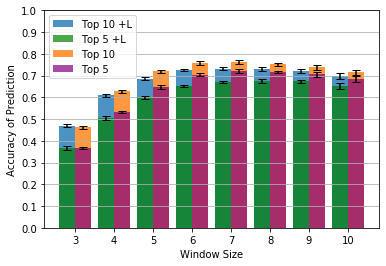

In [90]:
fig, ax = plt.subplots()
ax.bar(Results_lemmatize.index.values, Results_lemmatize['Predicted_top10_mean'].values, yerr=Results_lemmatize['Predicted_top10_std'].values, width=-0.4, align='edge', alpha=0.8, ecolor='black', capsize=4,  label='Top 10 +L')
ax.bar(Results_lemmatize.index.values, Results_lemmatize['Predicted_top5_mean'].values, yerr=Results_lemmatize['Predicted_top5_std'].values, color='green', width=-0.4, align='edge', alpha=0.7, ecolor='black', capsize=4, label='Top 5 +L')
ax.bar(Results_Nolemmatize.index.values, Results_Nolemmatize['Predicted_top10_mean'].values, yerr=Results_Nolemmatize['Predicted_top10_std'].values, width=0.4, align='edge', alpha=0.8, ecolor='black', capsize=4,  label='Top 10')
ax.bar(Results_Nolemmatize.index.values, Results_Nolemmatize['Predicted_top5_mean'].values, yerr=Results_Nolemmatize['Predicted_top5_std'].values, color='purple', width=0.4, align='edge', alpha=0.7, ecolor='black', capsize=4, label='Top 5')
ax.set_ylabel('Accuracy of Prediction')
ax.set_xlabel('Window Size')
ax.set_xticks(Results_lemmatize.index.values)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.yaxis.grid(True)
ax.legend()
plt.savefig(category+'-bars.pdf', dpi=500, bbox_inches='tight')

### Taking a look at the predicted probabilities of the best setup:

In [276]:
lemmatize = False
window = 7

# Building the corpus
corpus = Corpus(meta = 'Corpus BBC '+category+' News, only verbs as target, no stopwords.')
import_bbc_folder(category,corpus , lemmatize = lemmatize)

# Building the dataset
sentences , verbs = Build_Dataset([category], corpus, window, one_hot=True , lemmatize=lemmatize)

# Getting the train_valid_test data:
x_train, x_test, y_train, y_test = train_test_split(sentences, verbs, test_size=0.1, random_state=123)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=123)

# Building the model
vocab_size = len(corpus.get_vocabs_to_learn())
verbs_size = len(corpus.get_verbs_to_learn())
hidden_dim = 500

model = CBOW(vocab_size, hidden_dim, verbs_size)
model.cuda()

# Training the model
lr=0.001
batch_size = 512
n_epochs = 20
file_name = 'CBOW_BBC'+category+'_window='+str(window)+'_forevaluation.pt'

train_losses, valid_losses = Train_model(model, lr, batch_size, n_epochs, file_name, x_train, y_train, x_valid, y_valid)

# Loading the best model parameters
model.load_state_dict(torch.load(file_name))

bbc/sport\199.txt  had a problem
bbc/sport\199.txt  had a problem
Epoch: 1 	Training Loss: 6.459275 	Validation Loss: 5.405391
Validation loss decreased (inf --> 5.40539).  Saving model ...
Epoch: 2 	Training Loss: 5.749724 	Validation Loss: 5.136132
Validation loss decreased (5.40539 --> 5.13613).  Saving model ...
Epoch: 3 	Training Loss: 5.226538 	Validation Loss: 4.757624
Validation loss decreased (5.13613 --> 4.75762).  Saving model ...
Epoch: 4 	Training Loss: 4.502225 	Validation Loss: 4.316479
Validation loss decreased (4.75762 --> 4.31648).  Saving model ...
Epoch: 5 	Training Loss: 3.703577 	Validation Loss: 3.903156
Validation loss decreased (4.31648 --> 3.90316).  Saving model ...
Epoch: 6 	Training Loss: 2.950408 	Validation Loss: 3.550335
Validation loss decreased (3.90316 --> 3.55033).  Saving model ...
Epoch: 7 	Training Loss: 2.316395 	Validation Loss: 3.269647
Validation loss decreased (3.55033 --> 3.26965).  Saving model ...
Epoch: 8 	Training Loss: 1.820173 	Validat

<All keys matched successfully>

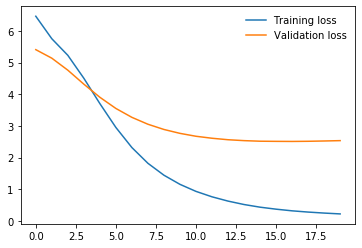

In [277]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(valid_losses, label = 'Validation loss')
plt.legend(frameon=False)

Looking into a sample of predictions:

In [278]:
getbatch = iter(get_batch(x_test, y_test , 16))
sentences, verbs = next(getbatch)

In [280]:
model.eval()
output = model(sentences.cuda().float())
ps = torch.exp(output)
top_p, top_class = ps.topk(10, dim=1)

In [281]:
for clas, t in zip(top_class, verbs):
    print(corpus.get_verb_from_index(t.item()) , ': ')
    print('\t' ,  end='' )
    for val in clas:
        print(corpus.get_verb_from_index(val.item()), end='\t' )
    print()

getting
	told	play	find	head	tour	work	move	break	expected	travelled	
got
	got	said	runs	right	top	pushing	named	gerrard	think	looked	
break
	talks	said	deal	rewarded	rejected	expires	start	tour	ongoing	signed	
club
	club	forced	make	worded	steven	gerrard	step	think	right	start	
feels
	feels	suspended	test	began	step	knew	withdrew	broke	hoping	made	
thumped
	return	thumped	back	referee	said	claiming	close	draw	scored	believes	
given
	given	captain	wins	ruled	named	put	return	ireland	likes	missed	
following
	end	following	coach	injured	skipper	moved	set	qualifying	boss	put	
took
	took	driven	declined	stood	try	hits	backs	helped	rumbled	back	
opening
	opening	heading	run	end	knew	qualifying	tries	close	fell	try	
keeper
	told	signed	boss	quit	agreed	warned	captain	keep	drawn	called	
squad
	returns	taking	rest	run	defend	set	back	win	start	leaving	
asked
	asked	wanted	straight	see	know	want	told	say	live	think	
avoid
	needing	second	needed	maintain	set	suffered	round	straight	clinch	sixth	

In [137]:
i = 8
sent = np.where(np.array(sentences[i]) != 0)[0]
corpus.get_vocab_from_index(sent.tolist())

['official', 'line', 'irish', 'ball', 'lewsey', 'josh']

In [138]:
probs = top_p[i].tolist()
vrbs = corpus.get_verb_from_index(top_class[i].tolist())

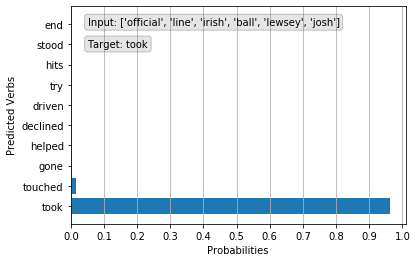

In [139]:
fig, ax = plt.subplots()
props = dict(boxstyle='round', facecolor='grey', alpha=0.2)
ax.text(0.05, 0.95, 'Input: '+str(corpus.get_vocab_from_index(sent.tolist())), transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
ax.text(0.05, 0.85, 'Target: '+corpus.get_verb_from_index(verbs[i].item()), transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
ax.barh(vrbs, probs, align='center')
plt.xlabel('Probabilities')
plt.ylabel('Predicted Verbs')
ax.set_xticks(np.arange(0,1.1,0.1))
ax.xaxis.grid(True)
plt.savefig(category+'-probs.pdf', dpi=500, bbox_inches='tight')
plt.show()

### 5- Obtaining prediction results when learning the verbs in technology articles:

In [91]:
category = 'tech'

In [92]:
# Preparing the results dataframes:
windows = list(range(3,11))
columns = ['Predicted_top5_mean', 'Predicted_top5_std', 'Predicted_top10_mean', 'Predicted_top10_std']
Results_Nolemmatize = pd.DataFrame(index=index, columns=columns)
Results_lemmatize = pd.DataFrame(index=index, columns=columns)

# Getting some results:
for lemmatize in [False , True]:
    
    # Building the corpus
    corpus = Corpus(meta = 'Corpus BBC '+category+' News, only verbs as target, no stopwords.')
    import_bbc_folder(category,corpus , lemmatize = lemmatize)
    
    for window in windows:
                
        # Building the dataset:
        sentences , verbs = Build_Dataset([category], corpus, window, one_hot=True , lemmatize=lemmatize)
        
        print('\n Starting:...-> Lemmatize =',lemmatize,', window =', window , '\n')
        
        lr=0.001
        batch_size = 512
        n_epochs = 20
        file_name = 'CBOW_BBC_'+category+'_lemmatize='+str(lemmatize)+'_window='+str(window)+'_crossval.pt'
        random_state = 123
        K = 10
        
        # Cross validating the model:
        training_losses, validation_losses, predicted_intop5, predicted_intop10 = K_fold_Cross_validate(K , sentences , verbs,
                                                                                                corpus, lr,batch_size ,n_epochs,
                                                                                                file_name, random_state)
        
        # Getting the prediction measures mean and standard deviation:
        predicted_intop5_mean , predicted_intop5_std  = np.mean(predicted_intop5) , np.std(predicted_intop5)
        predicted_intop10_mean , predicted_intop10_std  = np.mean(predicted_intop10) , np.std(predicted_intop10)
        
        # Adding the measures to the corresponding dataframe:
        if lemmatize:
            Results_lemmatize.loc[window , 'Predicted_top5_mean'] = predicted_intop5_mean
            Results_lemmatize.loc[window , 'Predicted_top5_std'] = predicted_intop5_std
            Results_lemmatize.loc[window , 'Predicted_top10_mean'] = predicted_intop10_mean
            Results_lemmatize.loc[window , 'Predicted_top10_std'] = predicted_intop10_std
        else:
            Results_Nolemmatize.loc[window , 'Predicted_top5_mean'] = predicted_intop5_mean
            Results_Nolemmatize.loc[window , 'Predicted_top5_std'] = predicted_intop5_std
            Results_Nolemmatize.loc[window , 'Predicted_top10_mean'] = predicted_intop10_mean
            Results_Nolemmatize.loc[window , 'Predicted_top10_std'] = predicted_intop10_std
        


 Starting:...-> Lemmatize = False , window = 3 

Epoch: 1 	Training Loss: 6.650592 	Validation Loss: 6.109626
Validation loss decreased (inf --> 6.10963).  Saving model ...
Epoch: 2 	Training Loss: 6.168304 	Validation Loss: 5.970748
Validation loss decreased (6.10963 --> 5.97075).  Saving model ...
Epoch: 3 	Training Loss: 5.886780 	Validation Loss: 5.748413
Validation loss decreased (5.97075 --> 5.74841).  Saving model ...
Epoch: 4 	Training Loss: 5.447449 	Validation Loss: 5.460475
Validation loss decreased (5.74841 --> 5.46047).  Saving model ...
Epoch: 5 	Training Loss: 4.879715 	Validation Loss: 5.157799
Validation loss decreased (5.46047 --> 5.15780).  Saving model ...
Epoch: 6 	Training Loss: 4.261708 	Validation Loss: 4.887161
Validation loss decreased (5.15780 --> 4.88716).  Saving model ...
Epoch: 7 	Training Loss: 3.680004 	Validation Loss: 4.675061
Validation loss decreased (4.88716 --> 4.67506).  Saving model ...
Epoch: 8 	Training Loss: 3.184083 	Validation Loss: 4.5196

Epoch: 14 	Training Loss: 1.759983 	Validation Loss: 4.231416
Epoch: 15 	Training Loss: 1.660636 	Validation Loss: 4.236756
Epoch: 16 	Training Loss: 1.574689 	Validation Loss: 4.252353
Epoch: 17 	Training Loss: 1.506427 	Validation Loss: 4.273470
Epoch: 18 	Training Loss: 1.450455 	Validation Loss: 4.297932
Epoch: 19 	Training Loss: 1.403677 	Validation Loss: 4.324033
Epoch: 20 	Training Loss: 1.355965 	Validation Loss: 4.354522
Epoch: 1 	Training Loss: 6.649862 	Validation Loss: 6.143558
Validation loss decreased (inf --> 6.14356).  Saving model ...
Epoch: 2 	Training Loss: 6.160882 	Validation Loss: 6.007074
Validation loss decreased (6.14356 --> 6.00707).  Saving model ...
Epoch: 3 	Training Loss: 5.876364 	Validation Loss: 5.785992
Validation loss decreased (6.00707 --> 5.78599).  Saving model ...
Epoch: 4 	Training Loss: 5.435913 	Validation Loss: 5.500904
Validation loss decreased (5.78599 --> 5.50090).  Saving model ...
Epoch: 5 	Training Loss: 4.873930 	Validation Loss: 5.2021

Epoch: 12 	Training Loss: 2.034692 	Validation Loss: 4.222850
Validation loss decreased (4.25432 --> 4.22285).  Saving model ...
Epoch: 13 	Training Loss: 1.881789 	Validation Loss: 4.208470
Validation loss decreased (4.22285 --> 4.20847).  Saving model ...
Epoch: 14 	Training Loss: 1.758124 	Validation Loss: 4.204765
Validation loss decreased (4.20847 --> 4.20477).  Saving model ...
Epoch: 15 	Training Loss: 1.655572 	Validation Loss: 4.211185
Epoch: 16 	Training Loss: 1.576117 	Validation Loss: 4.226928
Epoch: 17 	Training Loss: 1.506352 	Validation Loss: 4.245986
Epoch: 18 	Training Loss: 1.450718 	Validation Loss: 4.270054
Epoch: 19 	Training Loss: 1.402580 	Validation Loss: 4.298672
Epoch: 20 	Training Loss: 1.357513 	Validation Loss: 4.329343
Epoch: 1 	Training Loss: 6.651689 	Validation Loss: 6.112896
Validation loss decreased (inf --> 6.11290).  Saving model ...
Epoch: 2 	Training Loss: 6.169310 	Validation Loss: 5.975051
Validation loss decreased (6.11290 --> 5.97505).  Saving

Epoch: 8 	Training Loss: 2.122789 	Validation Loss: 3.516954
Validation loss decreased (3.70647 --> 3.51695).  Saving model ...
Epoch: 9 	Training Loss: 1.771719 	Validation Loss: 3.383704
Validation loss decreased (3.51695 --> 3.38370).  Saving model ...
Epoch: 10 	Training Loss: 1.510670 	Validation Loss: 3.290271
Validation loss decreased (3.38370 --> 3.29027).  Saving model ...
Epoch: 11 	Training Loss: 1.311734 	Validation Loss: 3.229172
Validation loss decreased (3.29027 --> 3.22917).  Saving model ...
Epoch: 12 	Training Loss: 1.154608 	Validation Loss: 3.188571
Validation loss decreased (3.22917 --> 3.18857).  Saving model ...
Epoch: 13 	Training Loss: 1.034346 	Validation Loss: 3.165745
Validation loss decreased (3.18857 --> 3.16574).  Saving model ...
Epoch: 14 	Training Loss: 0.935244 	Validation Loss: 3.154884
Validation loss decreased (3.16574 --> 3.15488).  Saving model ...
Epoch: 15 	Training Loss: 0.857274 	Validation Loss: 3.155184
Epoch: 16 	Training Loss: 0.792055 	V

Epoch: 4 	Training Loss: 4.855042 	Validation Loss: 4.813033
Validation loss decreased (5.30258 --> 4.81303).  Saving model ...
Epoch: 5 	Training Loss: 4.016308 	Validation Loss: 4.353063
Validation loss decreased (4.81303 --> 4.35306).  Saving model ...
Epoch: 6 	Training Loss: 3.240598 	Validation Loss: 3.984221
Validation loss decreased (4.35306 --> 3.98422).  Saving model ...
Epoch: 7 	Training Loss: 2.618298 	Validation Loss: 3.712157
Validation loss decreased (3.98422 --> 3.71216).  Saving model ...
Epoch: 8 	Training Loss: 2.145776 	Validation Loss: 3.514682
Validation loss decreased (3.71216 --> 3.51468).  Saving model ...
Epoch: 9 	Training Loss: 1.790879 	Validation Loss: 3.375241
Validation loss decreased (3.51468 --> 3.37524).  Saving model ...
Epoch: 10 	Training Loss: 1.525651 	Validation Loss: 3.273644
Validation loss decreased (3.37524 --> 3.27364).  Saving model ...
Epoch: 11 	Training Loss: 1.323864 	Validation Loss: 3.206152
Validation loss decreased (3.27364 --> 3.

Epoch: 19 	Training Loss: 0.659809 	Validation Loss: 3.213482
Epoch: 20 	Training Loss: 0.623521 	Validation Loss: 3.238484
Epoch: 1 	Training Loss: 6.666756 	Validation Loss: 5.991655
Validation loss decreased (inf --> 5.99166).  Saving model ...
Epoch: 2 	Training Loss: 6.096434 	Validation Loss: 5.734284
Validation loss decreased (5.99166 --> 5.73428).  Saving model ...
Epoch: 3 	Training Loss: 5.599718 	Validation Loss: 5.322657
Validation loss decreased (5.73428 --> 5.32266).  Saving model ...
Epoch: 4 	Training Loss: 4.857489 	Validation Loss: 4.832966
Validation loss decreased (5.32266 --> 4.83297).  Saving model ...
Epoch: 5 	Training Loss: 4.016659 	Validation Loss: 4.364322
Validation loss decreased (4.83297 --> 4.36432).  Saving model ...
Epoch: 6 	Training Loss: 3.239520 	Validation Loss: 3.985911
Validation loss decreased (4.36432 --> 3.98591).  Saving model ...
Epoch: 7 	Training Loss: 2.617718 	Validation Loss: 3.707361
Validation loss decreased (3.98591 --> 3.70736).  S

Epoch: 13 	Training Loss: 0.645938 	Validation Loss: 2.545925
Validation loss decreased (2.56777 --> 2.54592).  Saving model ...
Epoch: 14 	Training Loss: 0.563344 	Validation Loss: 2.535090
Validation loss decreased (2.54592 --> 2.53509).  Saving model ...
Epoch: 15 	Training Loss: 0.501096 	Validation Loss: 2.534384
Validation loss decreased (2.53509 --> 2.53438).  Saving model ...
Epoch: 16 	Training Loss: 0.449283 	Validation Loss: 2.539698
Epoch: 17 	Training Loss: 0.409962 	Validation Loss: 2.555196
Epoch: 18 	Training Loss: 0.377608 	Validation Loss: 2.568546
Epoch: 19 	Training Loss: 0.346685 	Validation Loss: 2.590887
Epoch: 20 	Training Loss: 0.324647 	Validation Loss: 2.609777
Epoch: 1 	Training Loss: 6.587440 	Validation Loss: 5.637474
Validation loss decreased (inf --> 5.63747).  Saving model ...
Epoch: 2 	Training Loss: 5.928996 	Validation Loss: 5.320217
Validation loss decreased (5.63747 --> 5.32022).  Saving model ...
Epoch: 3 	Training Loss: 5.276946 	Validation Loss:

Epoch: 8 	Training Loss: 1.612466 	Validation Loss: 2.921167
Validation loss decreased (3.10924 --> 2.92117).  Saving model ...
Epoch: 9 	Training Loss: 1.300877 	Validation Loss: 2.787409
Validation loss decreased (2.92117 --> 2.78741).  Saving model ...
Epoch: 10 	Training Loss: 1.072287 	Validation Loss: 2.692711
Validation loss decreased (2.78741 --> 2.69271).  Saving model ...
Epoch: 11 	Training Loss: 0.894845 	Validation Loss: 2.626476
Validation loss decreased (2.69271 --> 2.62648).  Saving model ...
Epoch: 12 	Training Loss: 0.759107 	Validation Loss: 2.583367
Validation loss decreased (2.62648 --> 2.58337).  Saving model ...
Epoch: 13 	Training Loss: 0.654278 	Validation Loss: 2.555224
Validation loss decreased (2.58337 --> 2.55522).  Saving model ...
Epoch: 14 	Training Loss: 0.573348 	Validation Loss: 2.541752
Validation loss decreased (2.55522 --> 2.54175).  Saving model ...
Epoch: 15 	Training Loss: 0.506837 	Validation Loss: 2.537986
Validation loss decreased (2.54175 --

Epoch: 3 	Training Loss: 5.122588 	Validation Loss: 5.126507
Validation loss decreased (5.76131 --> 5.12651).  Saving model ...
Epoch: 4 	Training Loss: 4.101972 	Validation Loss: 4.448330
Validation loss decreased (5.12651 --> 4.44833).  Saving model ...
Epoch: 5 	Training Loss: 3.116720 	Validation Loss: 3.902133
Validation loss decreased (4.44833 --> 3.90213).  Saving model ...
Epoch: 6 	Training Loss: 2.340816 	Validation Loss: 3.503604
Validation loss decreased (3.90213 --> 3.50360).  Saving model ...
Epoch: 7 	Training Loss: 1.774243 	Validation Loss: 3.220326
Validation loss decreased (3.50360 --> 3.22033).  Saving model ...
Epoch: 8 	Training Loss: 1.367007 	Validation Loss: 3.018740
Validation loss decreased (3.22033 --> 3.01874).  Saving model ...
Epoch: 9 	Training Loss: 1.074888 	Validation Loss: 2.878771
Validation loss decreased (3.01874 --> 2.87877).  Saving model ...
Epoch: 10 	Training Loss: 0.856726 	Validation Loss: 2.783999
Validation loss decreased (2.87877 --> 2.7

Epoch: 16 	Training Loss: 0.309117 	Validation Loss: 2.524781
Epoch: 17 	Training Loss: 0.277326 	Validation Loss: 2.531235
Epoch: 18 	Training Loss: 0.248919 	Validation Loss: 2.546562
Epoch: 19 	Training Loss: 0.227323 	Validation Loss: 2.563406
Epoch: 20 	Training Loss: 0.210614 	Validation Loss: 2.584310
Epoch: 1 	Training Loss: 6.601822 	Validation Loss: 6.187160
Validation loss decreased (inf --> 6.18716).  Saving model ...
Epoch: 2 	Training Loss: 5.873483 	Validation Loss: 5.771268
Validation loss decreased (6.18716 --> 5.77127).  Saving model ...
Epoch: 3 	Training Loss: 5.121449 	Validation Loss: 5.125341
Validation loss decreased (5.77127 --> 5.12534).  Saving model ...
Epoch: 4 	Training Loss: 4.099701 	Validation Loss: 4.439855
Validation loss decreased (5.12534 --> 4.43986).  Saving model ...
Epoch: 5 	Training Loss: 3.113975 	Validation Loss: 3.883419
Validation loss decreased (4.43986 --> 3.88342).  Saving model ...
Epoch: 6 	Training Loss: 2.340446 	Validation Loss: 3.

Epoch: 11 	Training Loss: 0.696046 	Validation Loss: 2.677145
Validation loss decreased (2.75338 --> 2.67715).  Saving model ...
Epoch: 12 	Training Loss: 0.574824 	Validation Loss: 2.624980
Validation loss decreased (2.67715 --> 2.62498).  Saving model ...
Epoch: 13 	Training Loss: 0.480952 	Validation Loss: 2.595897
Validation loss decreased (2.62498 --> 2.59590).  Saving model ...
Epoch: 14 	Training Loss: 0.408201 	Validation Loss: 2.578916
Validation loss decreased (2.59590 --> 2.57892).  Saving model ...
Epoch: 15 	Training Loss: 0.352724 	Validation Loss: 2.574633
Validation loss decreased (2.57892 --> 2.57463).  Saving model ...
Epoch: 16 	Training Loss: 0.309079 	Validation Loss: 2.573938
Validation loss decreased (2.57463 --> 2.57394).  Saving model ...
Epoch: 17 	Training Loss: 0.277084 	Validation Loss: 2.583637
Epoch: 18 	Training Loss: 0.250622 	Validation Loss: 2.595341
Epoch: 19 	Training Loss: 0.229864 	Validation Loss: 2.611190
Epoch: 20 	Training Loss: 0.210964 	Vali

Epoch: 5 	Training Loss: 3.051633 	Validation Loss: 3.342131
Validation loss decreased (3.84385 --> 3.34213).  Saving model ...
Epoch: 6 	Training Loss: 2.274282 	Validation Loss: 2.983879
Validation loss decreased (3.34213 --> 2.98388).  Saving model ...
Epoch: 7 	Training Loss: 1.707008 	Validation Loss: 2.728942
Validation loss decreased (2.98388 --> 2.72894).  Saving model ...
Epoch: 8 	Training Loss: 1.299284 	Validation Loss: 2.549285
Validation loss decreased (2.72894 --> 2.54928).  Saving model ...
Epoch: 9 	Training Loss: 1.004993 	Validation Loss: 2.423268
Validation loss decreased (2.54928 --> 2.42327).  Saving model ...
Epoch: 10 	Training Loss: 0.784967 	Validation Loss: 2.333860
Validation loss decreased (2.42327 --> 2.33386).  Saving model ...
Epoch: 11 	Training Loss: 0.620425 	Validation Loss: 2.270474
Validation loss decreased (2.33386 --> 2.27047).  Saving model ...
Epoch: 12 	Training Loss: 0.496018 	Validation Loss: 2.228927
Validation loss decreased (2.27047 --> 2

Epoch: 18 	Training Loss: 0.189576 	Validation Loss: 2.268558
Epoch: 19 	Training Loss: 0.171129 	Validation Loss: 2.278911
Epoch: 20 	Training Loss: 0.157716 	Validation Loss: 2.295835
Epoch: 1 	Training Loss: 6.617966 	Validation Loss: 5.489991
Validation loss decreased (inf --> 5.48999).  Saving model ...
Epoch: 2 	Training Loss: 5.854408 	Validation Loss: 5.117455
Validation loss decreased (5.48999 --> 5.11745).  Saving model ...
Epoch: 3 	Training Loss: 5.087895 	Validation Loss: 4.527190
Validation loss decreased (5.11745 --> 4.52719).  Saving model ...
Epoch: 4 	Training Loss: 4.042476 	Validation Loss: 3.896922
Validation loss decreased (4.52719 --> 3.89692).  Saving model ...
Epoch: 5 	Training Loss: 3.041935 	Validation Loss: 3.396866
Validation loss decreased (3.89692 --> 3.39687).  Saving model ...
Epoch: 6 	Training Loss: 2.266306 	Validation Loss: 3.037379
Validation loss decreased (3.39687 --> 3.03738).  Saving model ...
Epoch: 7 	Training Loss: 1.698540 	Validation Loss

Epoch: 11 	Training Loss: 0.619348 	Validation Loss: 2.311141
Validation loss decreased (2.38142 --> 2.31114).  Saving model ...
Epoch: 12 	Training Loss: 0.495998 	Validation Loss: 2.267128
Validation loss decreased (2.31114 --> 2.26713).  Saving model ...
Epoch: 13 	Training Loss: 0.404917 	Validation Loss: 2.238007
Validation loss decreased (2.26713 --> 2.23801).  Saving model ...
Epoch: 14 	Training Loss: 0.332735 	Validation Loss: 2.221219
Validation loss decreased (2.23801 --> 2.22122).  Saving model ...
Epoch: 15 	Training Loss: 0.284113 	Validation Loss: 2.217175
Validation loss decreased (2.22122 --> 2.21718).  Saving model ...
Epoch: 16 	Training Loss: 0.242453 	Validation Loss: 2.217540
Epoch: 17 	Training Loss: 0.213985 	Validation Loss: 2.225878
Epoch: 18 	Training Loss: 0.190939 	Validation Loss: 2.236328
Epoch: 19 	Training Loss: 0.169898 	Validation Loss: 2.247349
Epoch: 20 	Training Loss: 0.157612 	Validation Loss: 2.261814
Epoch: 1 	Training Loss: 6.619974 	Validation

Epoch: 4 	Training Loss: 4.085280 	Validation Loss: 4.005360
Validation loss decreased (4.59952 --> 4.00536).  Saving model ...
Epoch: 5 	Training Loss: 3.096539 	Validation Loss: 3.508975
Validation loss decreased (4.00536 --> 3.50897).  Saving model ...
Epoch: 6 	Training Loss: 2.308631 	Validation Loss: 3.142834
Validation loss decreased (3.50897 --> 3.14283).  Saving model ...
Epoch: 7 	Training Loss: 1.729192 	Validation Loss: 2.880149
Validation loss decreased (3.14283 --> 2.88015).  Saving model ...
Epoch: 8 	Training Loss: 1.307295 	Validation Loss: 2.686926
Validation loss decreased (2.88015 --> 2.68693).  Saving model ...
Epoch: 9 	Training Loss: 1.005484 	Validation Loss: 2.544150
Validation loss decreased (2.68693 --> 2.54415).  Saving model ...
Epoch: 10 	Training Loss: 0.775702 	Validation Loss: 2.441624
Validation loss decreased (2.54415 --> 2.44162).  Saving model ...
Epoch: 11 	Training Loss: 0.604020 	Validation Loss: 2.365143
Validation loss decreased (2.44162 --> 2.

Epoch: 15 	Training Loss: 0.252581 	Validation Loss: 2.235886
Validation loss decreased (2.24577 --> 2.23589).  Saving model ...
Epoch: 16 	Training Loss: 0.214660 	Validation Loss: 2.239225
Epoch: 17 	Training Loss: 0.185697 	Validation Loss: 2.247643
Epoch: 18 	Training Loss: 0.161730 	Validation Loss: 2.255435
Epoch: 19 	Training Loss: 0.145438 	Validation Loss: 2.265669
Epoch: 20 	Training Loss: 0.131602 	Validation Loss: 2.278070
Epoch: 1 	Training Loss: 6.695612 	Validation Loss: 5.499063
Validation loss decreased (inf --> 5.49906).  Saving model ...
Epoch: 2 	Training Loss: 5.863462 	Validation Loss: 5.127601
Validation loss decreased (5.49906 --> 5.12760).  Saving model ...
Epoch: 3 	Training Loss: 5.095619 	Validation Loss: 4.550717
Validation loss decreased (5.12760 --> 4.55072).  Saving model ...
Epoch: 4 	Training Loss: 4.062380 	Validation Loss: 3.928544
Validation loss decreased (4.55072 --> 3.92854).  Saving model ...
Epoch: 5 	Training Loss: 3.072954 	Validation Loss: 3

Epoch: 9 	Training Loss: 0.995868 	Validation Loss: 2.494853
Validation loss decreased (2.64096 --> 2.49485).  Saving model ...
Epoch: 10 	Training Loss: 0.774000 	Validation Loss: 2.389352
Validation loss decreased (2.49485 --> 2.38935).  Saving model ...
Epoch: 11 	Training Loss: 0.602363 	Validation Loss: 2.311620
Validation loss decreased (2.38935 --> 2.31162).  Saving model ...
Epoch: 12 	Training Loss: 0.476201 	Validation Loss: 2.257362
Validation loss decreased (2.31162 --> 2.25736).  Saving model ...
Epoch: 13 	Training Loss: 0.379316 	Validation Loss: 2.219143
Validation loss decreased (2.25736 --> 2.21914).  Saving model ...
Epoch: 14 	Training Loss: 0.307257 	Validation Loss: 2.196729
Validation loss decreased (2.21914 --> 2.19673).  Saving model ...
Epoch: 15 	Training Loss: 0.252297 	Validation Loss: 2.184963
Validation loss decreased (2.19673 --> 2.18496).  Saving model ...
Epoch: 16 	Training Loss: 0.215783 	Validation Loss: 2.183699
Validation loss decreased (2.18496 -

Epoch: 2 	Training Loss: 5.804730 	Validation Loss: 5.242312
Validation loss decreased (5.59549 --> 5.24231).  Saving model ...
Epoch: 3 	Training Loss: 5.125446 	Validation Loss: 4.733918
Validation loss decreased (5.24231 --> 4.73392).  Saving model ...
Epoch: 4 	Training Loss: 4.183348 	Validation Loss: 4.154149
Validation loss decreased (4.73392 --> 4.15415).  Saving model ...
Epoch: 5 	Training Loss: 3.228037 	Validation Loss: 3.663686
Validation loss decreased (4.15415 --> 3.66369).  Saving model ...
Epoch: 6 	Training Loss: 2.446318 	Validation Loss: 3.290574
Validation loss decreased (3.66369 --> 3.29057).  Saving model ...
Epoch: 7 	Training Loss: 1.853539 	Validation Loss: 3.018978
Validation loss decreased (3.29057 --> 3.01898).  Saving model ...
Epoch: 8 	Training Loss: 1.411144 	Validation Loss: 2.819537
Validation loss decreased (3.01898 --> 2.81954).  Saving model ...
Epoch: 9 	Training Loss: 1.082287 	Validation Loss: 2.671645
Validation loss decreased (2.81954 --> 2.67

Epoch: 12 	Training Loss: 0.499457 	Validation Loss: 2.340538
Validation loss decreased (2.39853 --> 2.34054).  Saving model ...
Epoch: 13 	Training Loss: 0.392665 	Validation Loss: 2.298996
Validation loss decreased (2.34054 --> 2.29900).  Saving model ...
Epoch: 14 	Training Loss: 0.312951 	Validation Loss: 2.271768
Validation loss decreased (2.29900 --> 2.27177).  Saving model ...
Epoch: 15 	Training Loss: 0.256344 	Validation Loss: 2.260839
Validation loss decreased (2.27177 --> 2.26084).  Saving model ...
Epoch: 16 	Training Loss: 0.214468 	Validation Loss: 2.256434
Validation loss decreased (2.26084 --> 2.25643).  Saving model ...
Epoch: 17 	Training Loss: 0.182154 	Validation Loss: 2.254976
Validation loss decreased (2.25643 --> 2.25498).  Saving model ...
Epoch: 18 	Training Loss: 0.161261 	Validation Loss: 2.259396
Epoch: 19 	Training Loss: 0.141947 	Validation Loss: 2.264878
Epoch: 20 	Training Loss: 0.126991 	Validation Loss: 2.271604
Epoch: 1 	Training Loss: 6.647299 	Valid

Epoch: 4 	Training Loss: 4.376948 	Validation Loss: 4.224119
Validation loss decreased (4.75412 --> 4.22412).  Saving model ...
Epoch: 5 	Training Loss: 3.461360 	Validation Loss: 3.757838
Validation loss decreased (4.22412 --> 3.75784).  Saving model ...
Epoch: 6 	Training Loss: 2.668831 	Validation Loss: 3.399447
Validation loss decreased (3.75784 --> 3.39945).  Saving model ...
Epoch: 7 	Training Loss: 2.046721 	Validation Loss: 3.134212
Validation loss decreased (3.39945 --> 3.13421).  Saving model ...
Epoch: 8 	Training Loss: 1.572416 	Validation Loss: 2.938843
Validation loss decreased (3.13421 --> 2.93884).  Saving model ...
Epoch: 9 	Training Loss: 1.212427 	Validation Loss: 2.788725
Validation loss decreased (2.93884 --> 2.78872).  Saving model ...
Epoch: 10 	Training Loss: 0.942335 	Validation Loss: 2.674773
Validation loss decreased (2.78872 --> 2.67477).  Saving model ...
Epoch: 11 	Training Loss: 0.729883 	Validation Loss: 2.589997
Validation loss decreased (2.67477 --> 2.

Epoch: 15 	Training Loss: 0.287700 	Validation Loss: 2.491606
Validation loss decreased (2.49562 --> 2.49161).  Saving model ...
Epoch: 16 	Training Loss: 0.237414 	Validation Loss: 2.493353
Epoch: 17 	Training Loss: 0.201699 	Validation Loss: 2.499692
Epoch: 18 	Training Loss: 0.172742 	Validation Loss: 2.506397
Epoch: 19 	Training Loss: 0.151315 	Validation Loss: 2.514734
Epoch: 20 	Training Loss: 0.132755 	Validation Loss: 2.524458
Epoch: 1 	Training Loss: 6.767661 	Validation Loss: 5.439148
Validation loss decreased (inf --> 5.43915).  Saving model ...
Epoch: 2 	Training Loss: 5.879286 	Validation Loss: 5.157274
Validation loss decreased (5.43915 --> 5.15727).  Saving model ...
Epoch: 3 	Training Loss: 5.254623 	Validation Loss: 4.719342
Validation loss decreased (5.15727 --> 4.71934).  Saving model ...
Epoch: 4 	Training Loss: 4.388449 	Validation Loss: 4.207467
Validation loss decreased (4.71934 --> 4.20747).  Saving model ...
Epoch: 5 	Training Loss: 3.464017 	Validation Loss: 3

Epoch: 9 	Training Loss: 1.211857 	Validation Loss: 2.785837
Validation loss decreased (2.91669 --> 2.78584).  Saving model ...
Epoch: 10 	Training Loss: 0.936536 	Validation Loss: 2.692147
Validation loss decreased (2.78584 --> 2.69215).  Saving model ...
Epoch: 11 	Training Loss: 0.726614 	Validation Loss: 2.629389
Validation loss decreased (2.69215 --> 2.62939).  Saving model ...
Epoch: 12 	Training Loss: 0.567634 	Validation Loss: 2.587831
Validation loss decreased (2.62939 --> 2.58783).  Saving model ...
Epoch: 13 	Training Loss: 0.445644 	Validation Loss: 2.563404
Validation loss decreased (2.58783 --> 2.56340).  Saving model ...
Epoch: 14 	Training Loss: 0.352800 	Validation Loss: 2.550368
Validation loss decreased (2.56340 --> 2.55037).  Saving model ...
Epoch: 15 	Training Loss: 0.286067 	Validation Loss: 2.548143
Validation loss decreased (2.55037 --> 2.54814).  Saving model ...
Epoch: 16 	Training Loss: 0.238166 	Validation Loss: 2.553784
Epoch: 17 	Training Loss: 0.200003 	

Epoch: 4 	Training Loss: 4.915306 	Validation Loss: 4.768245
Validation loss decreased (5.00692 --> 4.76825).  Saving model ...
Epoch: 5 	Training Loss: 4.438693 	Validation Loss: 4.563133
Validation loss decreased (4.76825 --> 4.56313).  Saving model ...
Epoch: 6 	Training Loss: 3.976362 	Validation Loss: 4.404309
Validation loss decreased (4.56313 --> 4.40431).  Saving model ...
Epoch: 7 	Training Loss: 3.576288 	Validation Loss: 4.293754
Validation loss decreased (4.40431 --> 4.29375).  Saving model ...
Epoch: 8 	Training Loss: 3.245232 	Validation Loss: 4.219080
Validation loss decreased (4.29375 --> 4.21908).  Saving model ...
Epoch: 9 	Training Loss: 2.977880 	Validation Loss: 4.171435
Validation loss decreased (4.21908 --> 4.17143).  Saving model ...
Epoch: 10 	Training Loss: 2.764001 	Validation Loss: 4.143919
Validation loss decreased (4.17143 --> 4.14392).  Saving model ...
Epoch: 11 	Training Loss: 2.589774 	Validation Loss: 4.130147
Validation loss decreased (4.14392 --> 4.

Epoch: 5 	Training Loss: 4.437042 	Validation Loss: 4.515269
Validation loss decreased (4.73493 --> 4.51527).  Saving model ...
Epoch: 6 	Training Loss: 3.980464 	Validation Loss: 4.343904
Validation loss decreased (4.51527 --> 4.34390).  Saving model ...
Epoch: 7 	Training Loss: 3.577472 	Validation Loss: 4.220691
Validation loss decreased (4.34390 --> 4.22069).  Saving model ...
Epoch: 8 	Training Loss: 3.246315 	Validation Loss: 4.136630
Validation loss decreased (4.22069 --> 4.13663).  Saving model ...
Epoch: 9 	Training Loss: 2.975556 	Validation Loss: 4.081750
Validation loss decreased (4.13663 --> 4.08175).  Saving model ...
Epoch: 10 	Training Loss: 2.760822 	Validation Loss: 4.047606
Validation loss decreased (4.08175 --> 4.04761).  Saving model ...
Epoch: 11 	Training Loss: 2.585883 	Validation Loss: 4.029284
Validation loss decreased (4.04761 --> 4.02928).  Saving model ...
Epoch: 12 	Training Loss: 2.445880 	Validation Loss: 4.022780
Validation loss decreased (4.02928 --> 4

Epoch: 6 	Training Loss: 3.973743 	Validation Loss: 4.338619
Validation loss decreased (4.51343 --> 4.33862).  Saving model ...
Epoch: 7 	Training Loss: 3.575668 	Validation Loss: 4.212477
Validation loss decreased (4.33862 --> 4.21248).  Saving model ...
Epoch: 8 	Training Loss: 3.246293 	Validation Loss: 4.126610
Validation loss decreased (4.21248 --> 4.12661).  Saving model ...
Epoch: 9 	Training Loss: 2.979400 	Validation Loss: 4.068464
Validation loss decreased (4.12661 --> 4.06846).  Saving model ...
Epoch: 10 	Training Loss: 2.766093 	Validation Loss: 4.033260
Validation loss decreased (4.06846 --> 4.03326).  Saving model ...
Epoch: 11 	Training Loss: 2.591388 	Validation Loss: 4.014582
Validation loss decreased (4.03326 --> 4.01458).  Saving model ...
Epoch: 12 	Training Loss: 2.456013 	Validation Loss: 4.007421
Validation loss decreased (4.01458 --> 4.00742).  Saving model ...
Epoch: 13 	Training Loss: 2.342871 	Validation Loss: 4.007847
Epoch: 14 	Training Loss: 2.250771 	Val

Epoch: 5 	Training Loss: 3.830176 	Validation Loss: 4.185246
Validation loss decreased (4.48550 --> 4.18525).  Saving model ...
Epoch: 6 	Training Loss: 3.275108 	Validation Loss: 3.961149
Validation loss decreased (4.18525 --> 3.96115).  Saving model ...
Epoch: 7 	Training Loss: 2.828593 	Validation Loss: 3.802622
Validation loss decreased (3.96115 --> 3.80262).  Saving model ...
Epoch: 8 	Training Loss: 2.479699 	Validation Loss: 3.694582
Validation loss decreased (3.80262 --> 3.69458).  Saving model ...
Epoch: 9 	Training Loss: 2.208445 	Validation Loss: 3.621373
Validation loss decreased (3.69458 --> 3.62137).  Saving model ...
Epoch: 10 	Training Loss: 1.995710 	Validation Loss: 3.574459
Validation loss decreased (3.62137 --> 3.57446).  Saving model ...
Epoch: 11 	Training Loss: 1.828115 	Validation Loss: 3.547040
Validation loss decreased (3.57446 --> 3.54704).  Saving model ...
Epoch: 12 	Training Loss: 1.692861 	Validation Loss: 3.534223
Validation loss decreased (3.54704 --> 3

Epoch: 4 	Training Loss: 4.455679 	Validation Loss: 4.468719
Validation loss decreased (4.82567 --> 4.46872).  Saving model ...
Epoch: 5 	Training Loss: 3.822033 	Validation Loss: 4.174935
Validation loss decreased (4.46872 --> 4.17494).  Saving model ...
Epoch: 6 	Training Loss: 3.271397 	Validation Loss: 3.955651
Validation loss decreased (4.17494 --> 3.95565).  Saving model ...
Epoch: 7 	Training Loss: 2.826912 	Validation Loss: 3.797953
Validation loss decreased (3.95565 --> 3.79795).  Saving model ...
Epoch: 8 	Training Loss: 2.483580 	Validation Loss: 3.687829
Validation loss decreased (3.79795 --> 3.68783).  Saving model ...
Epoch: 9 	Training Loss: 2.212226 	Validation Loss: 3.613775
Validation loss decreased (3.68783 --> 3.61377).  Saving model ...
Epoch: 10 	Training Loss: 2.003828 	Validation Loss: 3.565247
Validation loss decreased (3.61377 --> 3.56525).  Saving model ...
Epoch: 11 	Training Loss: 1.833641 	Validation Loss: 3.538652
Validation loss decreased (3.56525 --> 3.

Epoch: 2 	Training Loss: 5.473608 	Validation Loss: 4.976508
Validation loss decreased (5.29309 --> 4.97651).  Saving model ...
Epoch: 3 	Training Loss: 4.885373 	Validation Loss: 4.541086
Validation loss decreased (4.97651 --> 4.54109).  Saving model ...
Epoch: 4 	Training Loss: 4.155236 	Validation Loss: 4.124689
Validation loss decreased (4.54109 --> 4.12469).  Saving model ...
Epoch: 5 	Training Loss: 3.449460 	Validation Loss: 3.792118
Validation loss decreased (4.12469 --> 3.79212).  Saving model ...
Epoch: 6 	Training Loss: 2.856285 	Validation Loss: 3.550853
Validation loss decreased (3.79212 --> 3.55085).  Saving model ...
Epoch: 7 	Training Loss: 2.395721 	Validation Loss: 3.380743
Validation loss decreased (3.55085 --> 3.38074).  Saving model ...
Epoch: 8 	Training Loss: 2.043315 	Validation Loss: 3.260266
Validation loss decreased (3.38074 --> 3.26027).  Saving model ...
Epoch: 9 	Training Loss: 1.769118 	Validation Loss: 3.175397
Validation loss decreased (3.26027 --> 3.17

Epoch: 19 	Training Loss: 0.780822 	Validation Loss: 3.103247
Epoch: 20 	Training Loss: 0.745088 	Validation Loss: 3.136560
Epoch: 1 	Training Loss: 6.078558 	Validation Loss: 5.278142
Validation loss decreased (inf --> 5.27814).  Saving model ...
Epoch: 2 	Training Loss: 5.477468 	Validation Loss: 4.943972
Validation loss decreased (5.27814 --> 4.94397).  Saving model ...
Epoch: 3 	Training Loss: 4.892602 	Validation Loss: 4.490378
Validation loss decreased (4.94397 --> 4.49038).  Saving model ...
Epoch: 4 	Training Loss: 4.163362 	Validation Loss: 4.056625
Validation loss decreased (4.49038 --> 4.05662).  Saving model ...
Epoch: 5 	Training Loss: 3.456280 	Validation Loss: 3.711398
Validation loss decreased (4.05662 --> 3.71140).  Saving model ...
Epoch: 6 	Training Loss: 2.865219 	Validation Loss: 3.458257
Validation loss decreased (3.71140 --> 3.45826).  Saving model ...
Epoch: 7 	Training Loss: 2.407415 	Validation Loss: 3.278410
Validation loss decreased (3.45826 --> 3.27841).  S

Epoch: 14 	Training Loss: 1.063939 	Validation Loss: 2.978935
Validation loss decreased (2.98052 --> 2.97894).  Saving model ...
Epoch: 15 	Training Loss: 0.988674 	Validation Loss: 2.984171
Epoch: 16 	Training Loss: 0.924863 	Validation Loss: 2.998721
Epoch: 17 	Training Loss: 0.868227 	Validation Loss: 3.014544
Epoch: 18 	Training Loss: 0.823903 	Validation Loss: 3.038343
Epoch: 19 	Training Loss: 0.783391 	Validation Loss: 3.065697
Epoch: 20 	Training Loss: 0.747327 	Validation Loss: 3.094491
Epoch: 1 	Training Loss: 6.085732 	Validation Loss: 5.274264
Validation loss decreased (inf --> 5.27426).  Saving model ...
Epoch: 2 	Training Loss: 5.481349 	Validation Loss: 4.959347
Validation loss decreased (5.27426 --> 4.95935).  Saving model ...
Epoch: 3 	Training Loss: 4.888386 	Validation Loss: 4.525432
Validation loss decreased (4.95935 --> 4.52543).  Saving model ...
Epoch: 4 	Training Loss: 4.149274 	Validation Loss: 4.107349
Validation loss decreased (4.52543 --> 4.10735).  Saving m

Epoch: 11 	Training Loss: 1.132465 	Validation Loss: 2.913723
Validation loss decreased (2.95851 --> 2.91372).  Saving model ...
Epoch: 12 	Training Loss: 0.996795 	Validation Loss: 2.890083
Validation loss decreased (2.91372 --> 2.89008).  Saving model ...
Epoch: 13 	Training Loss: 0.884546 	Validation Loss: 2.876096
Validation loss decreased (2.89008 --> 2.87610).  Saving model ...
Epoch: 14 	Training Loss: 0.795994 	Validation Loss: 2.872752
Validation loss decreased (2.87610 --> 2.87275).  Saving model ...
Epoch: 15 	Training Loss: 0.719848 	Validation Loss: 2.878337
Epoch: 16 	Training Loss: 0.656924 	Validation Loss: 2.889537
Epoch: 17 	Training Loss: 0.606469 	Validation Loss: 2.909116
Epoch: 18 	Training Loss: 0.560162 	Validation Loss: 2.932506
Epoch: 19 	Training Loss: 0.522956 	Validation Loss: 2.960767
Epoch: 20 	Training Loss: 0.490971 	Validation Loss: 2.987415
Epoch: 1 	Training Loss: 6.038873 	Validation Loss: 5.310181
Validation loss decreased (inf --> 5.31018).  Savin

Epoch: 8 	Training Loss: 1.805851 	Validation Loss: 3.113463
Validation loss decreased (3.25850 --> 3.11346).  Saving model ...
Epoch: 9 	Training Loss: 1.529272 	Validation Loss: 3.010772
Validation loss decreased (3.11346 --> 3.01077).  Saving model ...
Epoch: 10 	Training Loss: 1.312847 	Validation Loss: 2.937075
Validation loss decreased (3.01077 --> 2.93707).  Saving model ...
Epoch: 11 	Training Loss: 1.141751 	Validation Loss: 2.886394
Validation loss decreased (2.93707 --> 2.88639).  Saving model ...
Epoch: 12 	Training Loss: 1.000637 	Validation Loss: 2.854292
Validation loss decreased (2.88639 --> 2.85429).  Saving model ...
Epoch: 13 	Training Loss: 0.888110 	Validation Loss: 2.835615
Validation loss decreased (2.85429 --> 2.83562).  Saving model ...
Epoch: 14 	Training Loss: 0.797706 	Validation Loss: 2.829571
Validation loss decreased (2.83562 --> 2.82957).  Saving model ...
Epoch: 15 	Training Loss: 0.723227 	Validation Loss: 2.830422
Epoch: 16 	Training Loss: 0.660455 	V

Epoch: 5 	Training Loss: 3.223424 	Validation Loss: 3.762166
Validation loss decreased (4.15197 --> 3.76217).  Saving model ...
Epoch: 6 	Training Loss: 2.591541 	Validation Loss: 3.475298
Validation loss decreased (3.76217 --> 3.47530).  Saving model ...
Epoch: 7 	Training Loss: 2.099724 	Validation Loss: 3.268312
Validation loss decreased (3.47530 --> 3.26831).  Saving model ...
Epoch: 8 	Training Loss: 1.720283 	Validation Loss: 3.118758
Validation loss decreased (3.26831 --> 3.11876).  Saving model ...
Epoch: 9 	Training Loss: 1.424711 	Validation Loss: 3.009080
Validation loss decreased (3.11876 --> 3.00908).  Saving model ...
Epoch: 10 	Training Loss: 1.199043 	Validation Loss: 2.931366
Validation loss decreased (3.00908 --> 2.93137).  Saving model ...
Epoch: 11 	Training Loss: 1.016503 	Validation Loss: 2.878859
Validation loss decreased (2.93137 --> 2.87886).  Saving model ...
Epoch: 12 	Training Loss: 0.870706 	Validation Loss: 2.847326
Validation loss decreased (2.87886 --> 2

Epoch: 2 	Training Loss: 5.409030 	Validation Loss: 5.112223
Validation loss decreased (5.47176 --> 5.11222).  Saving model ...
Epoch: 3 	Training Loss: 4.771005 	Validation Loss: 4.616274
Validation loss decreased (5.11222 --> 4.61627).  Saving model ...
Epoch: 4 	Training Loss: 3.974454 	Validation Loss: 4.144420
Validation loss decreased (4.61627 --> 4.14442).  Saving model ...
Epoch: 5 	Training Loss: 3.217199 	Validation Loss: 3.765914
Validation loss decreased (4.14442 --> 3.76591).  Saving model ...
Epoch: 6 	Training Loss: 2.586126 	Validation Loss: 3.479827
Validation loss decreased (3.76591 --> 3.47983).  Saving model ...
Epoch: 7 	Training Loss: 2.095010 	Validation Loss: 3.268978
Validation loss decreased (3.47983 --> 3.26898).  Saving model ...
Epoch: 8 	Training Loss: 1.715069 	Validation Loss: 3.117777
Validation loss decreased (3.26898 --> 3.11778).  Saving model ...
Epoch: 9 	Training Loss: 1.424483 	Validation Loss: 3.005333
Validation loss decreased (3.11778 --> 3.00

Epoch: 16 	Training Loss: 0.517348 	Validation Loss: 2.706759
Epoch: 17 	Training Loss: 0.464553 	Validation Loss: 2.724977
Epoch: 18 	Training Loss: 0.421467 	Validation Loss: 2.743612
Epoch: 19 	Training Loss: 0.387375 	Validation Loss: 2.767950
Epoch: 20 	Training Loss: 0.355634 	Validation Loss: 2.792517
Epoch: 1 	Training Loss: 6.088496 	Validation Loss: 5.495578
Validation loss decreased (inf --> 5.49558).  Saving model ...
Epoch: 2 	Training Loss: 5.410101 	Validation Loss: 5.151329
Validation loss decreased (5.49558 --> 5.15133).  Saving model ...
Epoch: 3 	Training Loss: 4.773098 	Validation Loss: 4.667566
Validation loss decreased (5.15133 --> 4.66757).  Saving model ...
Epoch: 4 	Training Loss: 3.976572 	Validation Loss: 4.197017
Validation loss decreased (4.66757 --> 4.19702).  Saving model ...
Epoch: 5 	Training Loss: 3.215361 	Validation Loss: 3.816070
Validation loss decreased (4.19702 --> 3.81607).  Saving model ...
Epoch: 6 	Training Loss: 2.583489 	Validation Loss: 3.

Epoch: 11 	Training Loss: 0.964050 	Validation Loss: 2.944994
Validation loss decreased (3.01244 --> 2.94499).  Saving model ...
Epoch: 12 	Training Loss: 0.805431 	Validation Loss: 2.903977
Validation loss decreased (2.94499 --> 2.90398).  Saving model ...
Epoch: 13 	Training Loss: 0.683547 	Validation Loss: 2.880422
Validation loss decreased (2.90398 --> 2.88042).  Saving model ...
Epoch: 14 	Training Loss: 0.580965 	Validation Loss: 2.869082
Validation loss decreased (2.88042 --> 2.86908).  Saving model ...
Epoch: 15 	Training Loss: 0.500596 	Validation Loss: 2.872062
Epoch: 16 	Training Loss: 0.437711 	Validation Loss: 2.879496
Epoch: 17 	Training Loss: 0.384323 	Validation Loss: 2.895248
Epoch: 18 	Training Loss: 0.343938 	Validation Loss: 2.911325
Epoch: 19 	Training Loss: 0.305821 	Validation Loss: 2.932995
Epoch: 20 	Training Loss: 0.280222 	Validation Loss: 2.960161
Epoch: 1 	Training Loss: 6.152416 	Validation Loss: 5.610272
Validation loss decreased (inf --> 5.61027).  Savin

Epoch: 6 	Training Loss: 2.622125 	Validation Loss: 3.546317
Validation loss decreased (3.85153 --> 3.54632).  Saving model ...
Epoch: 7 	Training Loss: 2.114988 	Validation Loss: 3.316537
Validation loss decreased (3.54632 --> 3.31654).  Saving model ...
Epoch: 8 	Training Loss: 1.718878 	Validation Loss: 3.145214
Validation loss decreased (3.31654 --> 3.14521).  Saving model ...
Epoch: 9 	Training Loss: 1.407779 	Validation Loss: 3.017771
Validation loss decreased (3.14521 --> 3.01777).  Saving model ...
Epoch: 10 	Training Loss: 1.161170 	Validation Loss: 2.924291
Validation loss decreased (3.01777 --> 2.92429).  Saving model ...
Epoch: 11 	Training Loss: 0.965531 	Validation Loss: 2.858367
Validation loss decreased (2.92429 --> 2.85837).  Saving model ...
Epoch: 12 	Training Loss: 0.811813 	Validation Loss: 2.812559
Validation loss decreased (2.85837 --> 2.81256).  Saving model ...
Epoch: 13 	Training Loss: 0.685920 	Validation Loss: 2.783931
Validation loss decreased (2.81256 --> 

Epoch: 2 	Training Loss: 5.430235 	Validation Loss: 5.276207
Validation loss decreased (5.62637 --> 5.27621).  Saving model ...
Epoch: 3 	Training Loss: 4.813387 	Validation Loss: 4.779381
Validation loss decreased (5.27621 --> 4.77938).  Saving model ...
Epoch: 4 	Training Loss: 4.022464 	Validation Loss: 4.278881
Validation loss decreased (4.77938 --> 4.27888).  Saving model ...
Epoch: 5 	Training Loss: 3.258858 	Validation Loss: 3.871483
Validation loss decreased (4.27888 --> 3.87148).  Saving model ...
Epoch: 6 	Training Loss: 2.623918 	Validation Loss: 3.561490
Validation loss decreased (3.87148 --> 3.56149).  Saving model ...
Epoch: 7 	Training Loss: 2.118702 	Validation Loss: 3.330317
Validation loss decreased (3.56149 --> 3.33032).  Saving model ...
Epoch: 8 	Training Loss: 1.719970 	Validation Loss: 3.159552
Validation loss decreased (3.33032 --> 3.15955).  Saving model ...
Epoch: 9 	Training Loss: 1.410415 	Validation Loss: 3.036031
Validation loss decreased (3.15955 --> 3.03

Epoch: 14 	Training Loss: 0.561496 	Validation Loss: 2.482715
Validation loss decreased (2.49799 --> 2.48271).  Saving model ...
Epoch: 15 	Training Loss: 0.469067 	Validation Loss: 2.482698
Validation loss decreased (2.48271 --> 2.48270).  Saving model ...
Epoch: 16 	Training Loss: 0.401183 	Validation Loss: 2.489437
Epoch: 17 	Training Loss: 0.347957 	Validation Loss: 2.502076
Epoch: 18 	Training Loss: 0.300487 	Validation Loss: 2.519200
Epoch: 19 	Training Loss: 0.267036 	Validation Loss: 2.536456
Epoch: 20 	Training Loss: 0.236250 	Validation Loss: 2.553132
Epoch: 1 	Training Loss: 6.187463 	Validation Loss: 4.829463
Validation loss decreased (inf --> 4.82946).  Saving model ...
Epoch: 2 	Training Loss: 5.447277 	Validation Loss: 4.565678
Validation loss decreased (4.82946 --> 4.56568).  Saving model ...
Epoch: 3 	Training Loss: 4.882883 	Validation Loss: 4.183085
Validation loss decreased (4.56568 --> 4.18309).  Saving model ...
Epoch: 4 	Training Loss: 4.133004 	Validation Loss: 

Epoch: 9 	Training Loss: 1.446199 	Validation Loss: 2.725858
Validation loss decreased (2.84228 --> 2.72586).  Saving model ...
Epoch: 10 	Training Loss: 1.182351 	Validation Loss: 2.639364
Validation loss decreased (2.72586 --> 2.63936).  Saving model ...
Epoch: 11 	Training Loss: 0.970769 	Validation Loss: 2.575187
Validation loss decreased (2.63936 --> 2.57519).  Saving model ...
Epoch: 12 	Training Loss: 0.801657 	Validation Loss: 2.532359
Validation loss decreased (2.57519 --> 2.53236).  Saving model ...
Epoch: 13 	Training Loss: 0.662511 	Validation Loss: 2.503042
Validation loss decreased (2.53236 --> 2.50304).  Saving model ...
Epoch: 14 	Training Loss: 0.553125 	Validation Loss: 2.491697
Validation loss decreased (2.50304 --> 2.49170).  Saving model ...
Epoch: 15 	Training Loss: 0.466745 	Validation Loss: 2.491449
Validation loss decreased (2.49170 --> 2.49145).  Saving model ...
Epoch: 16 	Training Loss: 0.398446 	Validation Loss: 2.495556
Epoch: 17 	Training Loss: 0.342432 	

Epoch: 3 	Training Loss: 4.962950 	Validation Loss: 4.178586
Validation loss decreased (4.50214 --> 4.17859).  Saving model ...
Epoch: 4 	Training Loss: 4.281577 	Validation Loss: 3.815284
Validation loss decreased (4.17859 --> 3.81528).  Saving model ...
Epoch: 5 	Training Loss: 3.548902 	Validation Loss: 3.497262
Validation loss decreased (3.81528 --> 3.49726).  Saving model ...
Epoch: 6 	Training Loss: 2.897877 	Validation Loss: 3.246430
Validation loss decreased (3.49726 --> 3.24643).  Saving model ...
Epoch: 7 	Training Loss: 2.352849 	Validation Loss: 3.054950
Validation loss decreased (3.24643 --> 3.05495).  Saving model ...
Epoch: 8 	Training Loss: 1.914883 	Validation Loss: 2.911262
Validation loss decreased (3.05495 --> 2.91126).  Saving model ...
Epoch: 9 	Training Loss: 1.561622 	Validation Loss: 2.801664
Validation loss decreased (2.91126 --> 2.80166).  Saving model ...
Epoch: 10 	Training Loss: 1.272099 	Validation Loss: 2.718194
Validation loss decreased (2.80166 --> 2.7

Epoch: 15 	Training Loss: 0.472001 	Validation Loss: 2.528311
Validation loss decreased (2.53445 --> 2.52831).  Saving model ...
Epoch: 16 	Training Loss: 0.393432 	Validation Loss: 2.530267
Epoch: 17 	Training Loss: 0.336739 	Validation Loss: 2.535662
Epoch: 18 	Training Loss: 0.289403 	Validation Loss: 2.546236
Epoch: 19 	Training Loss: 0.249141 	Validation Loss: 2.562193
Epoch: 20 	Training Loss: 0.220288 	Validation Loss: 2.578575
Epoch: 1 	Training Loss: 6.235315 	Validation Loss: 4.774587
Validation loss decreased (inf --> 4.77459).  Saving model ...
Epoch: 2 	Training Loss: 5.465336 	Validation Loss: 4.543275
Validation loss decreased (4.77459 --> 4.54328).  Saving model ...
Epoch: 3 	Training Loss: 4.971808 	Validation Loss: 4.207039
Validation loss decreased (4.54328 --> 4.20704).  Saving model ...
Epoch: 4 	Training Loss: 4.286212 	Validation Loss: 3.835123
Validation loss decreased (4.20704 --> 3.83512).  Saving model ...
Epoch: 5 	Training Loss: 3.548774 	Validation Loss: 3

Epoch: 10 	Training Loss: 1.251527 	Validation Loss: 2.702392
Validation loss decreased (2.78587 --> 2.70239).  Saving model ...
Epoch: 11 	Training Loss: 1.018720 	Validation Loss: 2.639157
Validation loss decreased (2.70239 --> 2.63916).  Saving model ...
Epoch: 12 	Training Loss: 0.833237 	Validation Loss: 2.595704
Validation loss decreased (2.63916 --> 2.59570).  Saving model ...
Epoch: 13 	Training Loss: 0.681925 	Validation Loss: 2.566721
Validation loss decreased (2.59570 --> 2.56672).  Saving model ...
Epoch: 14 	Training Loss: 0.559491 	Validation Loss: 2.551192
Validation loss decreased (2.56672 --> 2.55119).  Saving model ...
Epoch: 15 	Training Loss: 0.465969 	Validation Loss: 2.542743
Validation loss decreased (2.55119 --> 2.54274).  Saving model ...
Epoch: 16 	Training Loss: 0.389907 	Validation Loss: 2.545693
Epoch: 17 	Training Loss: 0.329732 	Validation Loss: 2.550445
Epoch: 18 	Training Loss: 0.284350 	Validation Loss: 2.560881
Epoch: 19 	Training Loss: 0.247415 	Vali

In [93]:
with open(category+'results.pkl', 'wb') as f:
    pickle.dump((Results_lemmatize , Results_Nolemmatize),f)

In [94]:
with open(category+'results.pkl', 'rb') as f:
    Results_lemmatize , Results_Nolemmatize = pickle.load(f)

In [95]:
Results_lemmatize

,Predicted_top5_mean,Predicted_top5_std,Predicted_top10_mean,Predicted_top10_std
3,0.417984,0.00915615,0.516421,0.00881875
4,0.551839,0.00438321,0.641162,0.00580352
5,0.629769,0.00609909,0.707308,0.00734627
6,0.679629,0.0086755,0.742891,0.00782869
7,0.697439,0.00781298,0.753733,0.00677959
8,0.701172,0.00732814,0.748717,0.00737072
9,0.697298,0.0073274,0.740104,0.00648302
10,0.682539,0.0109571,0.72332,0.00936205


In [96]:
Results_Nolemmatize

,Predicted_top5_mean,Predicted_top5_std,Predicted_top10_mean,Predicted_top10_std
3,0.459162,0.00669556,0.54288,0.00791682
4,0.626687,0.00801537,0.701296,0.00619978
5,0.714684,0.00549707,0.770756,0.00541502
6,0.758848,0.00601109,0.80168,0.00500488
7,0.772412,0.00605626,0.806616,0.00602434
8,0.773465,0.00628435,0.80279,0.00630827
9,0.75472,0.00671749,0.78125,0.00601994
10,0.737227,0.00771828,0.762891,0.00744651


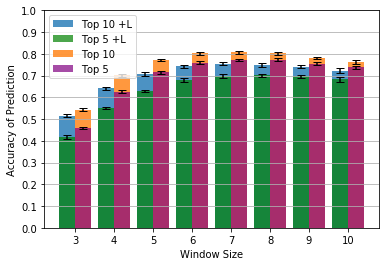

In [97]:
fig, ax = plt.subplots()
ax.bar(Results_lemmatize.index.values, Results_lemmatize['Predicted_top10_mean'].values, yerr=Results_lemmatize['Predicted_top10_std'].values, width=-0.4, align='edge', alpha=0.8, ecolor='black', capsize=4,  label='Top 10 +L')
ax.bar(Results_lemmatize.index.values, Results_lemmatize['Predicted_top5_mean'].values, yerr=Results_lemmatize['Predicted_top5_std'].values, color='green', width=-0.4, align='edge', alpha=0.7, ecolor='black', capsize=4, label='Top 5 +L')
ax.bar(Results_Nolemmatize.index.values, Results_Nolemmatize['Predicted_top10_mean'].values, yerr=Results_Nolemmatize['Predicted_top10_std'].values, width=0.4, align='edge', alpha=0.8, ecolor='black', capsize=4,  label='Top 10')
ax.bar(Results_Nolemmatize.index.values, Results_Nolemmatize['Predicted_top5_mean'].values, yerr=Results_Nolemmatize['Predicted_top5_std'].values, color='purple', width=0.4, align='edge', alpha=0.7, ecolor='black', capsize=4, label='Top 5')
ax.set_ylabel('Accuracy of Prediction')
ax.set_xlabel('Window Size')
ax.set_xticks(Results_lemmatize.index.values)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.yaxis.grid(True)
ax.legend()
plt.savefig(category+'-bars.pdf', dpi=500, bbox_inches='tight')

### Taking a look at the predicted probabilities of the best setup:

In [289]:
lemmatize = False
window = 7

# Building the corpus
corpus = Corpus(meta = 'Corpus BBC '+category+' News, only verbs as target, no stopwords.')
import_bbc_folder(category,corpus , lemmatize = lemmatize)

# Building the dataset
sentences , verbs = Build_Dataset([category], corpus, window, one_hot=True , lemmatize=lemmatize)

# Getting the train_valid_test data:
x_train, x_test, y_train, y_test = train_test_split(sentences, verbs, test_size=0.1, random_state=123)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=123)

# Building the model
vocab_size = len(corpus.get_vocabs_to_learn())
verbs_size = len(corpus.get_verbs_to_learn())
hidden_dim = 500

model = CBOW(vocab_size, hidden_dim, verbs_size)
model.cuda()

# Training the model
lr=0.001
batch_size = 512
n_epochs = 20
file_name = 'CBOW_BBC'+category+'_window='+str(window)+'_forevaluation.pt'

train_losses, valid_losses = Train_model(model, lr, batch_size, n_epochs, file_name, x_train, y_train, x_valid, y_valid)

# Loading the best model parameters
model.load_state_dict(torch.load(file_name))

Epoch: 1 	Training Loss: 6.609850 	Validation Loss: 5.467921
Validation loss decreased (inf --> 5.46792).  Saving model ...
Epoch: 2 	Training Loss: 5.853655 	Validation Loss: 5.089944
Validation loss decreased (5.46792 --> 5.08994).  Saving model ...
Epoch: 3 	Training Loss: 5.085706 	Validation Loss: 4.496530
Validation loss decreased (5.08994 --> 4.49653).  Saving model ...
Epoch: 4 	Training Loss: 4.030479 	Validation Loss: 3.860336
Validation loss decreased (4.49653 --> 3.86034).  Saving model ...
Epoch: 5 	Training Loss: 3.035423 	Validation Loss: 3.354807
Validation loss decreased (3.86034 --> 3.35481).  Saving model ...
Epoch: 6 	Training Loss: 2.261018 	Validation Loss: 2.981675
Validation loss decreased (3.35481 --> 2.98168).  Saving model ...
Epoch: 7 	Training Loss: 1.690953 	Validation Loss: 2.719664
Validation loss decreased (2.98168 --> 2.71966).  Saving model ...
Epoch: 8 	Training Loss: 1.287551 	Validation Loss: 2.534494
Validation loss decreased (2.71966 --> 2.53449)

<All keys matched successfully>

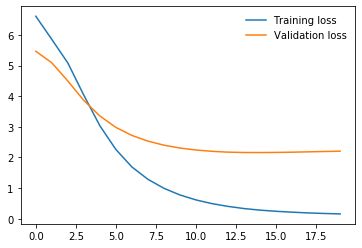

In [290]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(valid_losses, label = 'Validation loss')
plt.legend(frameon=False)

Looking into a sample of predictions:

In [291]:
getbatch = iter(get_batch(x_test, y_test , 16))
sentences, verbs = next(getbatch)

In [292]:
model.eval()
output = model(sentences.cuda().float())
ps = torch.exp(output)
top_p, top_class = ps.topk(10, dim=1)

In [293]:
for clas, t in zip(top_class, verbs):
    print(corpus.get_verb_from_index(t.item()) , ': ')
    print('\t' ,  end='' )
    for val in clas:
        print(corpus.get_verb_from_index(val.item()), end='\t' )
    print()

told
	told	said	contacted	reported	warning	wrote	made	consider	investigating	received	
handheld
	handheld	looks	use	diverting	appeal	ship	offered	look	carry	features	
sort
	sort	work	needs	make	published	report	brings	done	considered	discover	
ensure
	urged	update	despatch	caught	infected	wanted	combat	mentioned	sent	filtering	
said
	talking	think	become	said	thinking	realise	live	point	play	taking	
helps
	helps	equipped	keep	mobile	like	even	multimedia	used	seemed	transferred	
came
	came	said	video	broadband	going	put	get	according	thought	buying	
phones
	go	take	run	mobile	back	given	carry	want	say	set	
reading
	reading	learning	broadcast	made	believes	website	back	online	run	text	
end
	end	shipped	said	like	meant	trying	hold	travel	limited	compared	
mobile
	mobile	revolutionised	said	messaging	become	evolved	created	choosing	point	believes	
based
	based	uses	created	work	address	associated	remains	launch	installed	said	
gives
	gives	shut	tend	web	talk	started	lets	website	maintainin

In [189]:
i = 0
sent = np.where(np.array(sentences[i]) != 0)[0]
corpus.get_vocab_from_index(sent.tolist())

['news', 'told', 'bbc', 'head', 'paul', 'goosens']

In [190]:
probs = top_p[i].tolist()
vrbs = corpus.get_verb_from_index(top_class[i].tolist())

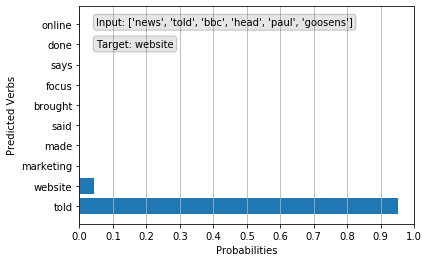

In [191]:
fig, ax = plt.subplots()
props = dict(boxstyle='round', facecolor='grey', alpha=0.2)
ax.text(0.05, 0.95, 'Input: '+str(corpus.get_vocab_from_index(sent.tolist())), transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
ax.text(0.05, 0.85, 'Target: '+corpus.get_verb_from_index(verbs[i].item()), transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
ax.barh(vrbs, probs, align='center')
plt.xlabel('Probabilities')
plt.ylabel('Predicted Verbs')
ax.set_xticks(np.arange(0,1.1,0.1))
ax.xaxis.grid(True)
plt.savefig(category+'-probs.pdf', dpi=500, bbox_inches='tight')
plt.show()